---

<p> Segunda Libreta sobre el trabajo de investigación: </p>

<center>

<p> 
<b>
"Estimación de la evapotranspiración espacio-temporal en arrozales usando imágenes satelitales, Departamento de Lambayeque" 
</b>
</p>

</center>

Autor: Cesar Francisco Vilca Gamarra 

Repositorio alojado en [GitHub](https://github.com/vilcagamarracf/Inv_arroz_METRIC) 

Marzo, 2022

---

# 2. Balance de Energía Superficial - Modelo METRIC

**Satellite-Based Energy Balance for Mapping Evapotranspiration With Internalized Calibration (METRIC)**

- METRIC is an image-processing model for calculating ET as a residual of the surface energy balance. 
- METRIC was developed by the University of Idaho for application to Landsat satellite imagery to maximize ET product resolution (30 m).
- METRIC uses as its foundation the pioneering SEBAL energy balance process developed in the Netherlands by Bastiaanssen et al.

Aplicación de referencia:
- [geeSEBAL en GitHub](https://github.com/et-brasil/geeSEBAL/blob/a8242225bcb184329372ee0dbdc411d1e9d5c766/JavaScrpit/tools.js)

## Inicio

Ejecutar todas las celdas ubicadas en esta sección para su uso posterior:
- Ingreso de creedenciales para usar Earth Engine en Colab (importa `ee` y luego `ee.Authenticate()`)
- Importar librerías como `geemap`, `pandas`, `matplotlib` entre otras.
- Ejecutar funciones realizadas para agilizar procesos repetitivos en ciertas ocasiones.

#### Ingreso de creedenciales para uso de Earth Engine

[geemap](https://geemap.org/) es un paquete de Python para obtener visualizaciones interactivas con Google Earth Engine (GEE).

In [16]:
import os
os.getcwd() # %pwd

'C:\\Users\\usuario\\Documents\\00-notebooks-2022'

In [1]:
import ee
ee.Initialize()

import numpy as np
import math
import pandas as pd

from pprint import pprint

import matplotlib.pyplot as plt
# import matplotlib.dates as mpl_dates # Modificar fechas por formato
# date_format = mpl_dates.DateFormatter('%Y-%m')

# Prueba: Cambiando estilo de fuente 
plt.rcParams['font.family'] = 'serif'  # default es 'sans-serif'
# plt.rcParams['font.family'] = 'sans-serif'

#### Funciones

Es necesario desarrollar funciones para ciertos componentes reutilizables:
- Modelo digital de elevación DEM
- Mapa de pendientes (grados)
- Mapa del Coseno del ángulo solar de incidencia Cosθ
- Mapa de transmitancias τ
- Mapa de albedo α
- Mapa de NDVI
- Mapa de LAI
- Mapa de Temperatura superficial en Kelvin
- Mapa de emisividad ε
- Mapa de Temperatura superficial corregido a partir de mapa de elevación `ts_dem`

Para poder estimar:
- R_n
- G
- H

Puede revisar las funciones en el repositorio de GitHub:
- https://github.com/vilcagamarracf/Inv_arroz_METRIC/tree/main/files/scripts

In [31]:
import geemap
import geemap.colormaps as cmp # Paletas para visualización de imágenes (cm se confunde con matplotlib)

%pylab inline 
from geemap import cartoee

from funciones import *
from vis_tools import *

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Por cada cambio se necesita usar importlib.reload
import importlib # Para volver a importar el archivo funciones.py posterior a cada cambio
import sys
importlib.reload(sys.modules['funciones'])

In [32]:
# Función para realizar gráficas de cartoee con barra de color
def get_grafica_cartoee_color(image, vis_params, title_map, label, save_fig=None):
    
    zoom_region = [-79.771781, -6.607186, -79.787761, -6.593991]

    fig = plt.figure(figsize=(8,6))

    # ee.Image a plotear
    ax = cartoee.get_map(image, region=zoom_region, vis_params=vis_params)

    # Añadir barra de color
    # https://matplotlib.org/stable/api/colorbar_api.html#module-matplotlib.colorbar   
    cb = cartoee.add_colorbar(
        ax, 
        vis_params=vis_params, 
        loc='right', 
        label=label, 
        posOpts=[0.86, 0.25, 0.02, 0.5]
    )# drawedges=True, extend='both')

    # Añadir grillas
    cartoee.add_gridlines(
        ax, 
        interval=0.005, 
        ytick_rotation=90, 
        linestyle=":", 
        linewidth=0
    ) # xtick_rotation=45

    # Añadir texto
    ax.text(-79.7768, -6.5962, title_map, fontsize=14)

    # add scale bar
    scale_bar_dict = {
          "length": 100, 
          "xy": (0.9, 0.05), 
          "linewidth": 2,
          "fontsize": 12,
          "color": "black",
          "unit": "m",
          "ha": "center",
          "va": "bottom",    
    }
    cartoee.add_scale_bar_lite(ax, **scale_bar_dict)
    
    ax.tick_params(axis = 'both', labelsize = 11)
    
    # Guardar graficas
    if save_fig != None:
        # plt.savefig(f'/Users/usuario/Downloads/{title_map}_{img_date}.jpg')
        # plt.savefig(f'/content/{title_map}_{img_date}.jpg')
        ruta = r'C:/Users/usuario/Documents/00-notebooks-2022/images/cartoee/'
        ruta_img = ruta + save_fig + '.jpg'
        plt.savefig(ruta_img)#, dpi=300)

    plt.show()

## Assets 

In [33]:
# Diccionario de visualización de imágenes Landsat 8 y 9 TOA
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 

In [34]:
# Assets
asset_dept = ee.FeatureCollection('users/CesarVilca/departamentos')
asset_prov = ee.FeatureCollection('users/CesarVilca/provincias')
asset_dist = ee.FeatureCollection('users/CesarVilca/distritos')

# Filtrado
deptSelectedName = 'LAMBAYEQUE'
provSelectedName = 'FERREÑAFE' # 'FERREÑAFE' 'CHICLAYO'
distSelectedName = 'FERREÑAFE' # 'FERREÑAFE' 'CHONGOYAPE'

dept_fcol = asset_dept.filterMetadata('DEPARTAMEN', 'equals', deptSelectedName)
prov_fcol = asset_prov.filterMetadata('PROVINCIA', 'equals', provSelectedName)
dist_fcol = asset_dist.filterMetadata('DISTRITO', 'equals', distSelectedName)

# ROI Caja
roi = dist_fcol.geometry().bounds()

empty = ee.Image().paint(dist_fcol, 2,2)
empty2 = ee.Image().paint(roi, 2, 2)

In [5]:
# Visualización
Map = geemap.Map(layer_ctrl = True) 
Map.centerObject(dist_fcol, 9)

Map.addLayer(dept_fcol, {'color':'red'}, f'Departamento {deptSelectedName}')
Map.addLayer(prov_fcol, {'color':'green'}, f'Provincia {provSelectedName} ')
Map.addLayer(dist_fcol, {'color':'blue'}, f'Distrito {distSelectedName}')

# Bordes
Map.addLayer(empty , {}, 'Distrito Seleccionado')
Map.addLayer(empty2, {}, 'Limites')

Map

Map(center=[-6.6205221157277006, -79.79111975903714], controls=(WidgetControl(options=['position', 'transparen…

In [35]:
# Área de evaluación: Ferreñafe - Áreas voladas
ruta_ferrenafe = r'files/Ferreñafe_areas_2.shp' # en Local

# Lectura como FeatureCollection con geemap
predios_agricolas = geemap.shp_to_ee(ruta_ferrenafe)
predios_vis = ee.Image().paint(predios_agricolas, 1, 1) # Para visualización con geemap

predios_bound = predios_agricolas.geometry().bounds()
predios_bound_vis = ee.Image().paint(predios_bound, 1, 1) # Para visualización con geemap

type(predios_agricolas)

ee.featurecollection.FeatureCollection

## Balance de Energía Superficial

En esta sección se desarrollará los 3 componentes de la ecuación de balance de energía superficial:
- Radiación Neta $R_n$
- Flujo de calor del suelo $G$
- Flujo de calor sensible del aire $H$

Tendremos como valores input imágenes satelitales Landsat 8 y 9, así como datos meteorológicos.



Reporte con imágenes Landsat 8 y 9 unidos con sus respectivos datos de Evapotranspiración horaria y velocidad de viento de la estación meteorológica INIA Vista Florida.

### Radiación Neta $R_n$

The net radiation flux at the surface ($R_n$) represents the actual radiant energy available at the surface.

$$
R_n = R_{S\downarrow} - \alpha R_{S\downarrow} + R_{L\downarrow} - R_{L\uparrow} - (1- \varepsilon_0)R_{L\downarrow}
$$

$$
R_n = (1- \alpha)R_{S\downarrow} + (R_{L\downarrow} - R_{L\uparrow}) - (1- \varepsilon_0)R_{L\downarrow}
$$

$$
\text{Net surface radiation} = \text{gains} - \text{losses}
$$

Dónde: 
- $R_n \;$ : Flujo de radiación neta $[W/m^2]$
- $\alpha \;\;\;\;$ : Albedo de superficie $[-]$
- $R_{S\downarrow}$ : Radiación de onda corta entrante $[W/m^2]$
- $R_{L\downarrow}$ : Radiación de onda larga entrante $[W/m^2]$
- $R_{L\uparrow}$ : Radiación de onda larga saliente $[W/m^2]$
- $\epsilon_0 \;\;\;$ : Emisividad del ancho de banda en la superficie / broad-band surface thermal emissivity

El término $(1- \epsilon_0)R_{L\downarrow}$ representa la fracción de radiación entrante de onda larga (incoming long-wave radiation) reflejada desde la superficie.

In [7]:
# 8 Imágenes seleccionadas
ids = [
    'LANDSAT/LC09/C02/T1/LC09_010065_20211212', # 0 - 12/12 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220113', # 1 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
    'LANDSAT/LC09/C02/T1/LC09_010065_20220129', # 2 - 01/29 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220310', # 3 - 03/10 - l8
    'LANDSAT/LC09/C02/T1/LC09_010065_20220403', # 4 - 04/03 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220521', # 5 - 05/21 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220529', # 6 - 05/29 - l8
    'LANDSAT/LC08/C02/T1/LC08_010065_20220614'  # 7 - 06/14 - l8
      ]

# Inputs
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

In [8]:
# Imagen Landsat seleccionada por index
img_id = ids[3]
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)

img_date = img_ee.date()
img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()

# Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

# Imágenes
img_ndvi = img_productos.select('NDVI')
img_savi = img_productos.select('SAVI')
img_lai  = img_productos.select('LAI')
img_albedo = img_productos.select('albedo')
img_Ts_c = img_productos.select('Ts_c')
img_Ts_K = img_productos.select('Ts_k')

# cos_theta_rel = img_productos.select('cos_theta')
# t_sw = img_productos.select('t_sw')
# e_0  = img_productos.select('e_0')

print(f'Rn de imagen {img_date_format1} procesada!')

Rn de imagen 10-03-2022 procesada!


In [9]:
print(f'Fecha: {img_date_format1}')

# Producir tabla con valores de los flujos [W/m^2] necesarios para obtener Radiación Neta 
R_n_stats = get_stats(R_n, predios_agricolas, 10)
R_n_stats_df = pd.DataFrame.from_dict(R_n_stats, orient='index').round(2)
display(R_n_stats_df) 

# Producir tabla de estadísticos sobre los productos elaborados
img_prod_stats = get_stats(img_productos, predios_agricolas, 30)
img_prod_stats_df = pd.DataFrame.from_dict(img_prod_stats, orient='index', dtype='float')#.round(3)
display(img_prod_stats_df)

Fecha: 10-03-2022


,R_l_in,R_l_out,R_n,R_s_in
max,378.75,462.20,692.36,846.36
mean,353.51,434.10,584.64,805.84
median,352.81,433.62,580.54,804.72
min,350.02,429.42,530.35,772.18
mode,352.31,431.89,572.49,804.72
stdDev,2.77,3.14,26.64,11.12


,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,slope,t_sw
max,1.824356,0.813376,0.577836,29.890949,303.040949,0.210209,0.907059,0.968244,0.976020,6.230337,0.673972
mean,1.004234,0.695226,0.439253,25.679101,298.829101,0.156955,0.863685,0.960042,0.973314,1.693220,0.673856
median,1.051343,0.728591,0.462851,25.549557,298.704816,0.163518,0.862504,0.960515,0.973465,1.860348,0.673853
min,-0.139684,0.057734,0.020029,24.946229,298.096229,0.038789,0.827631,0.948603,0.969539,0.000000,0.673762
mode,1.074093,0.759826,0.490374,25.421164,298.579211,0.163518,0.862504,0.961979,0.973954,0.930388,0.673840
stdDev,0.357172,0.119245,0.097244,0.560218,0.560218,0.030689,0.011948,0.003572,0.001179,0.962314,0.000031


In [43]:
# Notar
print(type(img_prod_stats['max']['LAI'])) # float
print(type(img_prod_stats_df['LAI']['max'])) # numpy.float64

<class 'float'>
<class 'numpy.float64'>


###### Prueba: Obtener gráficas de cada variable

Basado en las rampas de colores usadas en la aplicación [EEFLUX](http://eeflux-level1.appspot.com/):
- Temperatura Superficial ![](http://eeflux-level1.appspot.com/css/lst_legend.png)
- Albedo ![](http://eeflux-level1.appspot.com/css/albedo_legend.png)
- NDVI ![](http://eeflux-level1.appspot.com/css/ndvi_legend.png)
- ETrF ![](http://eeflux-level1.appspot.com/css/etrf_legend.png)
- EToF ![](http://eeflux-level1.appspot.com/css/etof_legend.png)
- Actual ET (mm/day) ![](http://eeflux-level1.appspot.com/css/eta_legend.png)

Para identificar cada color se puede usar el siguiente [enlace](https://www.ginifab.com/feeds/pms/pms_color_in_image.php).

In [10]:
albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061'] # 0 - 0.5
ndvi_cmap = ['0048fb', 'ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03'] # -0.2 - 1
ts_cmap = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026'] # 280 - 330 en K o 6.85 - 56.85 en °C
rn_cmp = ['560e0d', 'fd5903', 'fbfe04', '3aff01', '01feef', '0000fe', 'fd6dfd', 'ffffff']
rn_cmp_r = ['ffffff', 'fd6dfd', '0000fe', '01feef', '3aff01', 'fbfe04', 'fd5903', '560e0d']
# Revertir lista
# https://datagy.io/python-reverse-list/s
# cmp.plot_colormaps(width=12, height=0.4)

Generar gráfica de prueba.

In [11]:
# Generar 
# for id_ in ids:
# Imagen Landsat
variable = 'Rn'
img_id = ids[1]
landsat_id = img_id[11:12]
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)

img_date = img_ee.date()
img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()

# Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

# Imágenes
img_ndvi = img_productos.select('NDVI')
img_savi = img_productos.select('SAVI')
img_lai  = img_productos.select('LAI')
img_albedo = img_productos.select('albedo')
img_Ts_c = img_productos.select('Ts_c')
# img_Ts_K = img_productos.select('Ts_k')

# cos_theta_rel = img_productos.select('cos_theta')
# t_sw = img_productos.select('t_sw')
# e_0  = img_productos.select('e_0')

print(f'Rn de imagen {img_date_format1} procesada!')


# Estadisticas
R_n_stats = get_stats(R_n, predios_agricolas, 10)
R_n_stats_df = pd.DataFrame.from_dict(R_n_stats, orient='index').round(2)

img_prod_stats = get_stats(img_productos, predios_agricolas, 30)
img_prod_stats_df = pd.DataFrame.from_dict(img_prod_stats, orient='index')#.round(3)

display(R_n_stats_df)

Rn de imagen 13-01-2022 procesada!


,R_l_in,R_l_out,R_n,R_s_in
max,355.79,431.81,704.02,849.49
mean,329.84,401.28,622.51,799.22
median,327.86,398.86,623.52,799.13
min,318.57,389.04,532.21,760.33
mode,325.87,395.88,616.56,799.13
stdDev,7.05,8.28,27.34,12.54


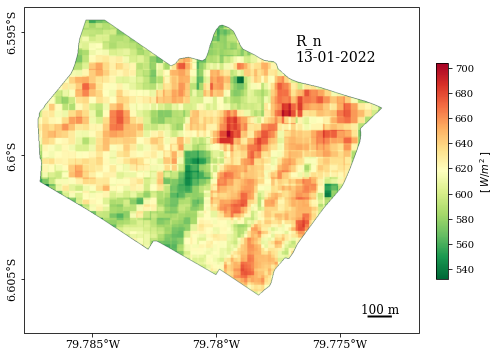

In [12]:
# R_n
vis_params_R_n = {'min': R_n_stats['min']['R_n'],
                  'max': R_n_stats['max']['R_n'], 
                  'palette': cmp.get_palette('RdYlGn_r')}

image = R_n.select('R_n').clip(predios_agricolas).blend(predios_vis)
vis_params = vis_params_R_n
variable = 'R_n'
title_map = f'{variable}\n{img_date_format1}'
label = '$[\; W/m^2 \;]$'
ruta = f'{variable}_{img_date_format2}_L{landsat_id}'

get_grafica_cartoee_color(image, 
                          vis_params, 
                          title_map, 
                          label,
                          save_fig=None)

In [ ]:
# R_n
vis_params_R_n = {'min': 500,
                  'max': 700, 
                  'palette': rn_cmp_r}

image = R_n.select('R_n').clip(predios_agricolas).blend(predios_vis)
vis_params = vis_params_R_n
variable = 'R_n'
title_map = f'{variable}\n{img_date_format1}'
label = '$[\; W/m^2 \;]$'
ruta = f'{variable}_{img_date}_L{landsat_id}'

get_grafica_cartoee_color(image, 
                          vis_params, 
                          title_map, 
                          label,
                          save_fig=None)

-----

Generando estadísticas de cada imagen.

In [13]:
for id_ in ids:

    # Imagen Landsat
    img_id = id_
    landsat_id = img_id[11:12]
    img_ee = ee.Image(img_id).clip(roi)
    img_toa = convert_RAW_to_TOA(img_ee)
    img_date = img_ee.date()
    img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
    img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()

    # Radiación Neta
    R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

    # Imágenes
    img_ndvi = img_productos.select('NDVI')
    img_savi = img_productos.select('SAVI')
    img_lai  = img_productos.select('LAI')
    img_albedo = img_productos.select('albedo')
    img_Ts_c = img_productos.select('Ts_c')
    # img_Ts_K = img_productos.select('Ts_k')

    # cos_theta_rel = img_productos.select('cos_theta')
    # t_sw = img_productos.select('t_sw')
    # e_0  = img_productos.select('e_0')

    print(f'Procesando Rn de imagen {img_date_format1}...')
    
    
    # Estadisticas --------------------------------------------------------------------------------
    
    R_n_stats = get_stats(R_n, predios_agricolas, 10)
    R_n_stats_df = pd.DataFrame.from_dict(R_n_stats, orient='index').round(2)

    img_prod_stats = get_stats(img_productos, predios_agricolas, 30)
    img_prod_stats_df = pd.DataFrame.from_dict(img_prod_stats, orient='index')#.round(3)
    
    # Guardar dataframe
    # img_prod_stats_df.to_csv(f'Estadisticas_{img_date_format2}.csv')
    
    # Mostrar dataframe
    display(R_n_stats_df)
#     print(f"R_n min-max: {R_n_stats_df['R_n'].min()} - {R_n_stats_df['R_n'].max()}")
    display(img_prod_stats_df)

Procesando Rn de imagen 12-12-2021...


,R_l_in,R_l_out,R_n,R_s_in
max,357.33,434.10,707.21,868.55
mean,336.62,409.46,612.19,822.22
median,337.13,409.88,607.44,822.35
min,315.91,387.52,517.22,786.20
mode,339.11,412.13,587.50,822.35
stdDev,7.97,9.20,36.18,11.77


,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,slope,t_sw
max,0.554053,0.467943,0.333643,26.499555,299.649555,0.238991,0.913931,0.985000,0.985000,6.230337,0.674302
mean,-0.038473,0.132272,0.077424,22.041137,295.191137,0.146637,0.865209,0.950857,0.970399,1.693220,0.674189
median,-0.045099,0.130938,0.077111,22.151023,295.318546,0.153726,0.865418,0.949588,0.969878,1.860348,0.674185
min,-0.284271,-0.208173,-0.074184,17.408391,290.558391,0.041380,0.827308,0.948287,0.969435,0.000000,0.674101
mode,-0.037012,0.134693,0.079208,22.596147,296.593129,0.170473,0.865418,0.949588,0.969878,0.930388,0.674179
stdDev,0.079890,0.064392,0.042190,1.746728,1.746728,0.040240,0.012435,0.006404,0.002731,0.962314,0.000039


Procesando Rn de imagen 13-01-2022...


,R_l_in,R_l_out,R_n,R_s_in
max,355.79,431.81,704.02,849.49
mean,329.84,401.28,622.51,799.22
median,327.86,398.86,623.52,799.13
min,318.57,389.04,532.21,760.33
mode,325.87,395.88,616.56,799.13
stdDev,7.05,8.28,27.34,12.54


,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,slope,t_sw
max,0.935767,0.642031,0.438215,26.100824,299.250824,0.206883,0.896870,0.985000,0.985000,6.230337,0.671267
mean,-0.007858,0.173278,0.091303,20.469317,293.619317,0.111805,0.843806,0.952030,0.970865,1.693220,0.671148
median,-0.035023,0.154073,0.080029,20.030456,293.160767,0.109039,0.843791,0.949827,0.969940,1.860348,0.671147
min,-0.277411,-0.148500,-0.069429,17.944078,291.094078,0.056113,0.802741,0.948280,0.969432,0.000000,0.671053
mode,-0.042958,0.126808,0.076280,19.591155,292.719740,0.114780,0.839195,0.949580,0.969878,0.930388,0.671122
stdDev,0.139226,0.122002,0.068931,1.547018,1.547018,0.030234,0.013283,0.008187,0.003492,0.962314,0.000038


Procesando Rn de imagen 29-01-2022...


,R_l_in,R_l_out,R_n,R_s_in
max,337.50,410.48,692.03,847.94
mean,316.62,385.21,625.90,798.01
median,316.95,385.13,627.51,797.71
min,308.52,377.20,534.50,759.02
mode,318.44,383.39,643.42,797.71
stdDev,3.34,3.70,25.55,12.40


,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,slope,t_sw
max,1.619720,0.759109,0.554878,20.938461,294.088461,0.227019,0.897753,0.966197,0.975345,6.230337,0.671351
mean,0.198340,0.353765,0.185670,17.493181,290.643181,0.110586,0.844939,0.951983,0.970655,1.693220,0.671225
median,0.120602,0.330252,0.162084,17.548401,290.700191,0.108847,0.844647,0.951232,0.970387,1.860348,0.671222
min,-0.147685,0.038631,0.015133,15.622040,288.772040,0.050530,0.803618,0.948523,0.969513,0.000000,0.671120
mode,0.097404,0.255753,0.150101,17.956234,291.111898,0.111857,0.844647,0.951232,0.970109,0.930388,0.671220
stdDev,0.256094,0.142867,0.096539,0.752842,0.752842,0.029637,0.013170,0.002561,0.000845,0.962314,0.000035


Procesando Rn de imagen 10-03-2022...


,R_l_in,R_l_out,R_n,R_s_in
max,378.75,462.20,692.36,846.36
mean,353.51,434.10,584.64,805.84
median,352.81,433.62,580.54,804.72
min,350.02,429.42,530.35,772.18
mode,352.31,431.89,572.49,804.72
stdDev,2.77,3.14,26.64,11.12


,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,slope,t_sw
max,1.824356,0.813376,0.577836,29.890949,303.040949,0.210209,0.907059,0.968244,0.976020,6.230337,0.673972
mean,1.004234,0.695226,0.439253,25.679101,298.829101,0.156955,0.863685,0.960042,0.973314,1.693220,0.673856
median,1.051343,0.728591,0.462851,25.549557,298.704816,0.163518,0.862504,0.960515,0.973465,1.860348,0.673853
min,-0.139684,0.057734,0.020029,24.946229,298.096229,0.038789,0.827631,0.948603,0.969539,0.000000,0.673762
mode,1.074093,0.759826,0.490374,25.421164,298.579211,0.163518,0.862504,0.961979,0.973954,0.930388,0.673840
stdDev,0.357172,0.119245,0.097244,0.560218,0.560218,0.030689,0.011948,0.003572,0.001179,0.962314,0.000031


Procesando Rn de imagen 03-04-2022...


,R_l_in,R_l_out,R_n,R_s_in
max,325.16,397.17,651.92,826.90
mean,304.04,373.48,563.97,792.66
median,303.31,372.68,561.54,792.69
min,301.07,369.43,517.42,758.15
mode,303.18,372.43,560.45,791.21
stdDev,2.54,2.87,18.29,10.70


,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,slope,t_sw
max,1.517619,0.768674,0.541722,18.555802,291.705802,0.225250,0.898770,0.965176,0.975008,6.230337,0.673434
mean,1.052980,0.681717,0.459726,14.614110,287.764110,0.185776,0.861553,0.960530,0.973475,1.693220,0.673322
median,1.066526,0.689509,0.465979,14.452101,287.608260,0.188258,0.861571,0.960665,0.973524,1.860348,0.673318
min,0.044078,0.238657,0.123197,13.913064,287.063064,0.100740,0.824045,0.950441,0.970145,0.000000,0.673235
mode,1.066526,0.689509,0.471701,14.421545,287.577863,0.203374,0.859979,0.960665,0.973524,0.930388,0.673299
stdDev,0.197198,0.047824,0.047124,0.577501,0.577501,0.020323,0.011642,0.001972,0.000651,0.962314,0.000029


Procesando Rn de imagen 21-05-2022...


,R_l_in,R_l_out,R_n,R_s_in
max,338.32,410.17,539.62,737.96
mean,322.77,391.88,467.75,704.59
median,323.05,392.11,467.49,702.58
min,308.27,376.28,401.61,670.11
mode,324.82,393.88,471.53,708.69
stdDev,4.45,5.13,21.65,12.03


,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,slope,t_sw
max,0.872771,0.630935,0.423360,21.788111,294.938111,0.303627,0.833784,0.958728,0.972880,6.230337,0.663886
mean,0.239493,0.317291,0.213517,18.712963,291.862963,0.216256,0.796123,0.952395,0.970790,1.693220,0.663759
median,0.213040,0.295855,0.204040,18.795583,291.936469,0.215272,0.793724,0.952119,0.970695,1.860348,0.663757
min,-0.051337,0.141291,0.071783,15.445496,288.595496,0.122331,0.757104,0.949487,0.969831,0.000000,0.663650
mode,0.208983,0.274540,0.194372,19.142274,292.297493,0.221216,0.793724,0.951936,0.970649,0.930388,0.663752
stdDev,0.106280,0.065850,0.040152,1.003001,1.003001,0.026690,0.013603,0.001063,0.000351,0.962314,0.000034


Procesando Rn de imagen 29-05-2022...


,R_l_in,R_l_out,R_n,R_s_in
max,380.19,460.74,555.69,724.77
mean,363.05,440.46,453.25,690.64
median,363.11,440.60,454.50,688.72
min,344.59,420.77,370.26,655.01
mode,360.11,436.87,452.52,688.72
stdDev,5.11,5.87,29.46,12.26


,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,slope,t_sw
max,0.990326,0.677419,0.450411,30.512336,303.662336,0.318548,0.823314,0.959903,0.973268,6.230337,0.662229
mean,0.222009,0.311605,0.205215,27.381695,300.531695,0.206426,0.784578,0.952220,0.970733,1.693220,0.662094
median,0.206896,0.298723,0.202047,27.423484,300.577443,0.202709,0.782455,0.952056,0.970681,1.860348,0.662093
min,-0.081507,0.123817,0.054575,23.488523,296.638523,0.092930,0.744036,0.949185,0.969731,0.000000,0.661980
mode,0.199624,0.291091,0.206040,26.858737,299.922160,0.195787,0.782455,0.952180,0.970666,0.930388,0.662099
stdDev,0.122167,0.073731,0.047414,1.056719,1.056719,0.039338,0.013941,0.001222,0.000403,0.962314,0.000036


Procesando Rn de imagen 14-06-2022...


,R_l_in,R_l_out,R_n,R_s_in
max,386.03,466.33,522.68,704.59
mean,369.76,447.81,445.21,668.80
median,367.87,445.64,444.52,667.30
min,347.97,423.42,350.80,631.85
mode,362.63,440.12,439.52,666.68
stdDev,7.99,9.11,29.51,12.60


,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,slope,t_sw
max,0.687171,0.564996,0.374299,31.961642,305.111642,0.314650,0.807201,0.956872,0.972268,6.230337,0.659323
mean,0.145284,0.264075,0.168860,28.679619,301.829619,0.190679,0.766265,0.951453,0.970479,1.693220,0.659188
median,0.181641,0.278310,0.188720,28.280544,301.422697,0.192800,0.764497,0.951812,0.970591,1.860348,0.659188
min,-0.114732,0.085178,0.035070,24.142331,297.292331,0.085689,0.723844,0.948853,0.969621,0.000000,0.659063
mode,0.232373,0.286231,0.206115,30.513420,300.390561,0.202662,0.763783,0.952056,0.970649,0.930388,0.659184
stdDev,0.141349,0.089439,0.065356,1.630059,1.630059,0.042736,0.014451,0.001413,0.000466,0.962314,0.000038


Generando gráficas de cada variable para cada imagen.

In [ ]:
# Inputs iniciales

for id_ in ids:

    # Imagen Landsat
    img_id = id_
    landsat_id = img_id[11:12]
    img_ee = ee.Image(img_id).clip(roi)
    img_toa = convert_RAW_to_TOA(img_ee)
    img_date = img_ee.date()
    img_date_format1 = img_date.format('dd-MM-YYYY').getInfo()
    img_date_format2 = img_date.format('YYYY-MM-dd').getInfo()

    # Radiación Neta
    R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

    # Imágenes
    img_ndvi = img_productos.select('NDVI')
    img_savi = img_productos.select('SAVI')
    img_lai  = img_productos.select('LAI')
    img_albedo = img_productos.select('albedo')
    img_Ts_c = img_productos.select('Ts_c')
    # img_Ts_K = img_productos.select('Ts_k')

    # cos_theta_rel = img_productos.select('cos_theta')
    # t_sw = img_productos.select('t_sw')
    # e_0  = img_productos.select('e_0')

    print(f'Procesando Rn de imagen {img_date_format1}...')
    
    
    # Estadisticas --------------------------------------------------------------------------------
    
    R_n_stats = get_stats(R_n, predios_agricolas, 10)
    R_n_stats_df = pd.DataFrame.from_dict(R_n_stats, orient='index').round(2)

#     img_prod_stats = get_stats(img_productos, predios_agricolas, 30)
#     img_prod_stats_df = pd.DataFrame.from_dict(img_prod_stats, orient='index')#.round(3)

    
    # R_n --------------------------------------------------------------------------------------
    
    variable = 'Rn'
    vis_params_R_n = {'min': 0, #R_n_stats['min']['R_n'],
                      'max': 700, #R_n_stats['max']['R_n'], 
                      'palette': rn_cmp_r}#cmp.get_palette('gist_rainbow_r')} # gist_rainbow, RdYlGn_r

    image = R_n.select('R_n').clip(predios_agricolas).blend(predios_vis)
    vis_params = vis_params_R_n
    variable = 'R_n'
    label = '$[\; W/m^2 \;]$'
    title_map = f'{variable}\n{img_date_format1}'
    ruta = f'{variable}_{img_date_format2}_L{landsat_id}'
    
    print(f"R_n min-max: {R_n_stats_df['R_n'].min()} - {R_n_stats_df['R_n'].max()}")
    
    get_grafica_cartoee_color(image, vis_params, title_map, label, save_fig=ruta)

    
    # Albedo --------------------------------------------------------------------------------------
    
#     vis_params_alb = {'min': 0, #img_prod_stats['min']['albedo'], 
#                       'max': 0.5, #img_prod_stats['max']['albedo'], 
#                       'palette': albedo_cmap} #cmp.get_palette('afmhot')} # RdYlGn_r

#     image = img_albedo.clip(predios_agricolas).blend(predios_vis)
#     # image = image.updateMask(image.lte(0.22).And(image.gt(0.17)))

#     vis_params = vis_params_alb
#     variable = 'Albedo'
#     label = '$[\; - \;]$'
#     title_map = f'{variable}\n{img_date_format1}'
#     ruta = f'{variable}_{img_date_format2}_L{landsat_id}'

#     get_grafica_cartoee_color(image, vis_params, title_map, label, save_fig=ruta)

    
#     # Temperatura Superficial -------------------------------------------------------------------
    
#     vis_params_ts = {'min': 10,#img_prod_stats['min']['Ts_c'],
#                      'max': 35,#img_prod_stats['max']['Ts_c'],
#                      'palette': cmp.get_palette('RdYlBu_r')}

#     image = img_Ts_c.clip(predios_agricolas).blend(predios_vis)
#     vis_params = vis_params_ts
#     variable = 'Ts'
#     label = '$[\; °C \;]$'
#     title_map = f'{variable}\n{img_date_format1}'
#     ruta = f'{variable}_{img_date_format2}_L{landsat_id}'

#     get_grafica_cartoee_color(image, vis_params, title_map, label, save_fig=None)

    
    # NDVI --------------------------------------------------------------------------------------
    
#     vis_params_ndvi = {'min': -0.2, 
#                        'max': 1, # img_prod_stats['max']['NDVI'], 
#                        'palette': ndvi_cmap} #cmp.get_palette('ndvi')}

#     image = img_ndvi.clip(predios_agricolas).blend(predios_vis)

# #     if img_prod_stats['min']['NDVI'] < 0:
#       # image = image.where(image.lte(0), 0) # Asignar valor 0 a negativos
# #       image = image.updateMask(image.gt(0)) # Eliminar pixeles negativos y mantener positivos

#     vis_params = vis_params_ndvi
#     variable = 'NDVI'
#     title_map = f'{variable}\n{img_date_format1}'
#     label = '$[\; - \;]$'
#     ruta = f'{variable}_{img_date_format2}_L{landsat_id}'

#     get_grafica_cartoee_color(image, vis_params, title_map, label, save_fig=ruta)

    
#     # LAI --------------------------------------------------------------------------------------
    
#     vis_params_lai = {'min': 0, 
#                       'max': img_prod_stats['max']['LAI'], 
#                       'palette': cmp.get_palette('RdYlGn')}

#     image = img_lai.clip(predios_agricolas).blend(predios_vis)

#     # if img_prod_stats['LAI']['min'] < 0:
#       # image = image.where(image.lte(0), 0) # Asignar valor 0 a negativos
#       # image = image.updateMask(image.gt(0)) # Eliminar pixeles negativos y mantener positivos
    
#     vis_params = vis_params_lai
#     variable = 'LAI'
#     title_map = f'{variable}\n{img_date_format1}'
#     label = '$[\; - \;]$'
#     ruta = f'{title_map}_{img_date_format2}_L{landsat_id}'

#     get_grafica_cartoee_color(image, vis_params, title_map, label, save_fig=None)
    

###### Prueba: Elaboración de boxplot

Matplotlib - Boxplot:
- https://matplotlib.org/stable/gallery/index.html#statistics
- https://matplotlib.org/stable/gallery/statistics/boxplot.html#sphx-glr-gallery-statistics-boxplot-py

Ojo con los ee.Reducer:
- [Reducer / Statistics of an Image Region - Pixels in the region](https://developers.google.com/earth-engine/guides/reducers_reduce_region#pixels-in-the-region)
- [Reducer / Weighted Reductions](https://developers.google.com/earth-engine/guides/reducers_weighting): By default, reducers applied to imagery weight the inputs according to the mask value. This is relevant in the context of fractional pixels created through operations such as clip(). Adjust this behavior by calling unweighted() on the reducer. Using an unweighted reducer forces all pixels in the region to have the same weight. 
- [ee.Reducer.median](https://developers.google.com/earth-engine/apidocs/ee-reducer-median)
- [ee.Reducer.mean](https://developers.google.com/earth-engine/apidocs/ee-reducer-mean)

In [ ]:
# Inputs
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

lista_dates = []
lista_ndvi_boxplot = []
lista_savi_boxplot = []
lista_lai_boxplot = []
lista_albedo_boxplot = []

lista_boxplot = []

for id in ids:
    
    # Imagen Landsat
    img_id = id
    img_ee = ee.Image(img_id).clip(roi)
    img_toa = convert_RAW_to_TOA(img_ee)
    img_date = img_ee.date().format('YYYY-MM-dd').getInfo()
    lista_dates.append(img_date)

    # Radiación Neta
    R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

    # Imágenes
    img_ndvi = img_productos.select('NDVI')
    img_savi = img_productos.select('SAVI')
    img_lai  = img_productos.select('LAI')
    img_albedo = img_productos.select('albedo')

    # Convertir ee.Image a numpy.array
    ndvi_list_values = img_ndvi.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('NDVI').getInfo()
    savi_list_values = img_savi.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('SAVI').getInfo()
    lai_list_values  = img_lai.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('LAI').getInfo()
    albedo_list_values = img_albedo.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('albedo').getInfo()

    # ndvi_array = np.array(ndvi_list_values)
    # lista_prueba = ndvi_array.flatten('C').tolist() # https://www.javatpoint.com/numpy-flatten

    lista_ndvi_boxplot.append(ndvi_list_values)
    lista_savi_boxplot.append(savi_list_values)
    lista_lai_boxplot.append(lai_list_values)
    lista_albedo_boxplot.append(albedo_list_values)

    print(f'Rn de imagen {img_date} procesada!') 

In [ ]:
# Visualización de Boxplot con Matplotlib
title_boxplot = 'Boxplot'
lista_boxplot = lista_albedo_boxplot 
# lista_ndvi_boxplot, lista_savi_boxplot, lista_lai_boxplot, lista_albedo_boxplot

# Boxplot NDVI
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey=True)

axs[0].boxplot(lista_boxplot,labels=lista_dates)
axs[0].set_title(title_boxplot)
axs[0].axhline(0, color='k', ls='--', lw=1)

axs[1].boxplot(lista_boxplot,
               labels=lista_dates,
               showfliers=False)
axs[1].set_title(f'{title_boxplot} showfliers=False')
axs[1].axhline(0, color='k', ls='--', lw=1)

# axs[0].set_ylim(top=1)
# axs[1].set_ylim(top=1)

fig.subplots_adjust(wspace=0.05)
plt.show()

In [ ]:
# Boxplot grupal
lista_parametros = [lista_ndvi_boxplot, lista_savi_boxplot, 
                    lista_lai_boxplot, lista_albedo_boxplot]
lista_parametros_titles = ['NDVI', 'SAVI', 'LAI', 'Albedo']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axs = axs.flatten()

for i, lista in enumerate(lista_parametros):
    axs[i].boxplot(lista,
                   labels=lista_dates,
                   showfliers=True)
    axs[i].set_title(lista_parametros_titles[i]+' Boxplot')
    axs[i].axhline(0, color='k', ls='--', lw=1)
#     axs[i].set_ylim(top=1)

fig.subplots_adjust(wspace=0.1)
plt.show()

**Boxplot con seaborn**

Boxplot:
- https://seaborn.pydata.org/generated/seaborn.boxplot.html

Para control de gráfico
- https://seaborn.pydata.org/tutorial/aesthetics.html
- https://stackoverflow.com/questions/58476654/how-to-remove-or-hide-x-axis-labels-from-a-seaborn-matplotlib-plot
- https://python-graph-gallery.com/33-control-colors-of-boxplot-seaborn

Links para customizar el boxplot:
- https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html
- https://matplotlib.org/stable/gallery/text_labels_and_annotations/legend_demo.html
- https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html

In [ ]:
# Creamos una función que genere dataframes
def prepare_df_vertical(lista_escogida, lista_title):
    
    lista_pd = []
    
    for i, lista in enumerate(lista_escogida):
        prueba = pd.DataFrame(list(zip(lista)), columns=['Valores'])
        prueba['Fecha'] = lista_dates[i]
        prueba['Tipo'] = lista_title
        lista_pd.append(prueba)

    df = pd.concat(lista_pd)
    
    return df

In [ ]:
# Una vez creado la función, generar dataframes y luego concatenarlos entre si
# lista_parametros = [lista_ndvi_boxplot, lista_savi_boxplot, lista_lai_boxplot, lista_albedo_boxplot]
lista_parametros = [lista_ndvi_boxplot, lista_savi_boxplot, lista_albedo_boxplot]

# lista_parametros_titles = ['NDVI', 'SAVI', 'LAI', 'Albedo']
lista_parametros_titles = ['NDVI', 'SAVI', 'Albedo']

listas = []

for i, lista in enumerate(lista_parametros):
    df = prepare_df_vertical(lista, lista_parametros_titles[i])
    listas.append(df)

df_final = pd.concat(listas)
df_final

In [ ]:
# Widget para seleccionar un color html
import ipywidgets as widgets

widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)

In [ ]:
import seaborn as sns

In [ ]:
# Obteniendo DDS sabiendo que comenzó el '2021-12-01'
# lista_dates = ['2021-12-12', '2022-01-13', '2022-01-29', '2022-03-10', '2022-04-03']

# https://stackoverflow.com/questions/12126318/subtracting-dates-with-python

dds = []

from datetime import datetime
inicio_camp = datetime(2021, 12, 1)

for fechas in lista_dates:
    fecha_dt = datetime.strptime(fechas, '%Y-%m-%d')
    dif = fecha_dt - inicio_camp
    dds.append(dif.days)

dds

In [ ]:
# Boxplot con seaborn
fig = plt.figure(figsize=(8,5)) # Recibe valores en pulgadas, para cambiar usar cm = 1/2.54

ax = sns.boxplot(x="Fecha", y="Valores", hue="Tipo", data=df_final, 
                 palette=['#1bb61e','#99da0b','#f53232'], 
                 fliersize=0, 
                 linewidth=1.5,
                 width=0.4, showcaps=False,
#                 medianprops={"color": "white", "linewidth": 1.5},
                boxprops={"edgecolor": "black","linewidth": 1}
                )
titulo = 'Boxplot - Parametros NDVI, SAVI y Albedo'
ax.set_title(titulo) # , fonts2_Prueba_en_local.ipynbze=20, fontfamily='serif'

ax.set_ylim(top=1)

ax.axhline(0, color='k', ls='--', lw=1)
# ax.axhline(0.17, color='g', ls='--', lw=1)
# ax.axhline(0.22, color='g', ls='--', lw=1)

ax.set(xlabel=None, ylabel=None)  # remove the axis label, 'DDS'

# ax.tick_params(axis='x', labelsize=16)  
# ax.tick_params(axis='y', labelsize=16) 

# --- Prueba: Días despues de siembra DDS ---- 
# x_ticks_labels = dds # Alterando xtickslabels: 'DDS'
# ax.set_xticklabels(x_ticks_labels)
# ax.set(xlabel='DDS')
# ---------- 

ax.legend(title='', loc='upper left'
#           bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.
         )
# ax.get_legend().remove() # Remover leyenda
sns.despine()
ax.yaxis.grid(True, alpha=0.3)
plt.tight_layout()

path_name = 'images/Boxplot_8x5_'
plt.savefig(f'{path_name}Prueba.jpeg', dpi=300)

In [ ]:
# violinplot con seaborn
fig = plt.figure(figsize=(8,5))

ax = sns.violinplot(x="Fecha", y="Valores", hue="Tipo", data=df_final, 
                    palette="Spectral", 
#                     fliersize=0,
                    linewidth=1
                   )

ax.set_title('Violinplot - Parametros NDVI, SAVI y Albedo') # , fontsize=20

ax.set_ylim(top=1)

ax.axhline(0, color='k', ls='--', lw=1)
# ax.axhline(0.17, color='g', ls='--', lw=1)
# ax.axhline(0.22, color='g', ls='--', lw=1)

ax.set(xlabel=None)  # remove the axis label
ax.set(ylabel=None)

ax.tick_params(axis='x') # , labelsize=16
ax.tick_params(axis='y') # , labelsize=16

ax.legend(title='', loc='upper left')

sns.despine()
ax.yaxis.grid(True, alpha=0.3)

plt.tight_layout()

path_name = 'images/Violinplot_8x5_'
plt.savefig(f'{path_name}prueba.jpeg', dpi=300)

In [ ]:
# Guardar un array como .txt
ruta = r'/Users/usuario/Documents/00-notebooks-2022/files/'

array_albedo = np.array(lista_albedo_boxplot)
array_nvdi = np.array(lista_ndvi_boxplot)
array_savi = np.array(lista_savi_boxplot)
array_lai  = np.array(lista_lai_boxplot)

# numpy.savetxt(fname, X, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)[source]
np.savetxt(f'{ruta}array_albedo.txt', array_albedo)
np.savetxt(f'{ruta}array_nvdi.txt', array_nvdi)
np.savetxt(f'{ruta}array_savi.txt', array_savi)
np.savetxt(f'{ruta}array_lai.txt', array_lai)

In [ ]:
# Lectura de numpy.array en .txt para leer boxplot
np_albedo = np.loadtxt(f'{ruta}array_albedo.txt').tolist()

In [ ]:
# Boxplot
plt.figure(figsize=(9, 6))
plt.boxplot(np_albedo);

In [ ]:
def get_boxplot(lista, title):
  title_boxplot = title
  lista_boxplot = lista
  # Boxplot NDVI
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey=True)

  axs[0].boxplot(lista_boxplot,labels=lista_dates)
  axs[0].set_title(title_boxplot)
  # axs[0].set_ylim(top=1)
  axs[0].axhline(0, color='k', ls='--', lw=1)

  axs[1].boxplot(lista_boxplot,
                labels=lista_dates,
                showfliers=False)
  axs[1].set_title(f'{title_boxplot} showfliers=False')
  # axs[1].set_ylim(top=1)
  axs[1].axhline(0, color='k', ls='--', lw=1)

  fig.subplots_adjust(wspace=0.05)
  plt.show()

In [ ]:
get_boxplot(lista_ndvi_boxplot, 'Albedo boxplot')

In [ ]:
get_boxplot(lista_savi_boxplot, 'SAVI boxplot')

In [ ]:
get_boxplot(lista_lai_boxplot, 'LAI boxplot')

In [ ]:
# Visualizando una solo boxplot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)
ax1.boxplot(lista_boxplot[0],
            labels=[lista_dates[0]],
            showfliers=False)
ax1.set_ylim(0,1)
ax1.set_title('NDVI Boxplot');

In [ ]:
# Prueba de Matplotlib: Object-based method
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 6), sharey=True)
axs[0].boxplot(lista_boxplot[0],
                 labels=[lista_dates[0]])
axs[0].set_title('NDVI boxplot')
axs[0].set_ylim(0,1)

axs[1].boxplot(lista_boxplot[1],
                 labels=[lista_dates[1]])
axs[1].set_title('NDVI boxplot')
axs[1].set_ylim(0,1)

axs[2].boxplot(lista_boxplot[2],
                 labels=[lista_dates[2]])
axs[2].set_title('NDVI boxplot')
axs[2].set_ylim(0,1)

axs[3].boxplot(lista_boxplot[3],
                 labels=[lista_dates[3]])
axs[3].set_title('NDVI boxplot')
axs[3].set_ylim(0,1)

axs[4].boxplot(lista_boxplot[4],
                 labels=[lista_dates[4]])
axs[4].set_title('NDVI boxplot')
axs[4].set_ylim(0,1)

plt.show()

In [ ]:
# Primer camino para obtener pixeles de imagen dentro de una region rectangular
prueba = img_ndvi.sampleRectangle(region=predios_agricolas, defaultValue=0)
prueba.get('B5').getInfo()#.get('NDVI')

array = np.array(prueba.get('B5').getInfo())
# array

# plt.imshow(array)
# plt.show()

# Reducir a 1 dimension 
lista_prueba = array.flatten('C').tolist() # https://www.javatpoint.com/numpy-flatten

# Elaborar boxplot:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

plt.boxplot(lista_prueba);

#### Evaluando parámetros de Radiación Neta


##### Radiación Neta

In [11]:
# ['R_l_in', 'R_l_out', 'R_n', 'R_s_in']
R_n_stats_df['R_n']

max       692.36
mean      584.64
median    580.54
min       530.35
mode      572.49
stdDev     26.64
Name: R_n, dtype: float64

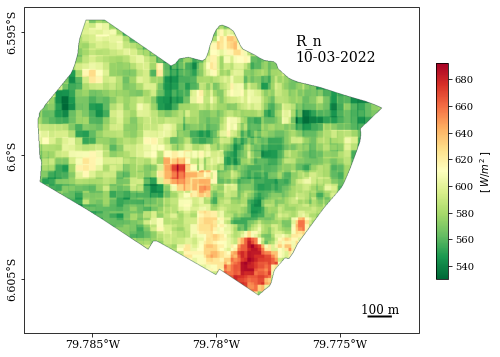

In [12]:
# Visualización cartoee
vis_params_R_n = {'min': R_n_stats['min']['R_n'],
                  'max': R_n_stats['max']['R_n'], 
                  'palette': cmp.get_palette('RdYlGn_r')}

image = R_n.select('R_n').clip(predios_agricolas).blend(predios_vis)
vis_params = vis_params_R_n
title_map = f'R_n\n{img_date_format1}' # dd-mm-YYYY
label = '$[\; W/m^2 \;]$'

get_grafica_cartoee_color(image, vis_params, title_map, label, save_fig=None)

In [13]:
# Visualización geemap
Map = geemap.Map()#height='800px') 
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_R_n, title_map) 

Map.add_colorbar(vis_params_R_n, label=label, orientation="vertical")

Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# El exportar requiere una escala -> No es posible descargar tal como está 
# (el valor 10 se asemeja al mapa realizado pero no es el mismo)
# geemap.ee_export_image(
#     R_n, filename='R_n_10.tif', scale=10, region=predios_agricolas.geometry()
# )

##### Albedo

Según Hiroguchi, Ikuo (1992), los valores típicos de albedo superficial para campos de arroz es de 0.17 - 0.22.

In [14]:
img_prod_stats_df['albedo']

max       0.210209
mean      0.156955
median    0.163518
min       0.038789
mode      0.163518
stdDev    0.030689
Name: albedo, dtype: float64

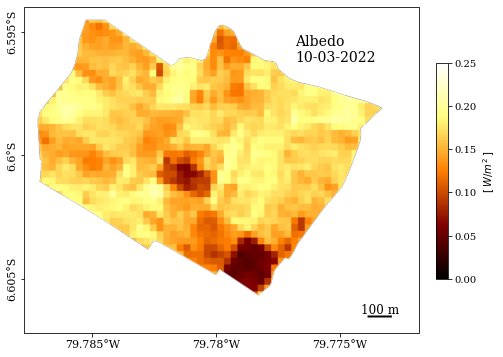

In [15]:
# Visualización
vis_params_alb = {'min': 0,    #float(img_prod_stats['min']['albedo']), 
                  'max': 0.25, #float(img_prod_stats['max']['albedo']), 
                  'palette': cmp.get_palette('afmhot')} # RdYlGn_r, afmhot

image_alb = img_albedo.clip(predios_agricolas).blend(predios_vis)
# image = image.updateMask(image.lte(0.22).And(image.gt(0.17)))

vis_params = vis_params_alb
title_map = f'Albedo\n{img_date_format1}'
label = '$[\; W/m^2 \;]$'

get_grafica_cartoee_color(image_alb, vis_params, title_map, label, save_fig=None)

In [16]:
# geemap
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image_alb, vis_params_alb , 'img_albedo') 

Map.add_colorbar(vis_params_alb, label="Albedo [-]", orientation="vertical")

Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

##### Temperatura Superficial (Tasumi, 2003)

In [44]:
img_prod_stats_df['Ts_c']

max       29.890949
mean      25.679101
median    25.549557
min       24.946229
mode      25.421164
stdDev     0.560218
Name: Ts_c, dtype: float64

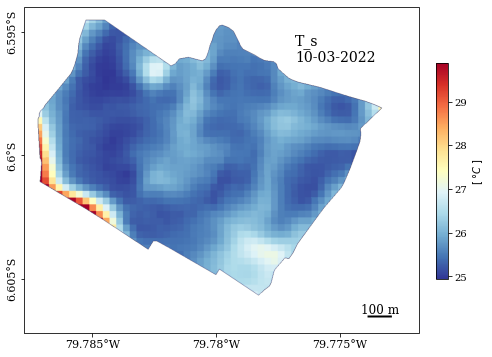

In [18]:
# Visualización
vis_params_ts = {'min': img_prod_stats['min']['Ts_c'],
                 'max': img_prod_stats['max']['Ts_c'],
                 'palette': cmp.get_palette('RdYlBu_r')}

image = img_Ts_c.clip(predios_agricolas).blend(predios_vis)
vis_params = vis_params_ts
title_map = f'T_s\n{img_date_format1}'
label = '$[\; °C \;]$'

get_grafica_cartoee_color(image, vis_params, title_map, label, save_fig=None)

In [19]:
# Visualización
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_ts, title_map) 

Map.add_colorbar(vis_params_ts, label='Ts [°C]', orientation="vertical")
Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

###### Comparativa entre productos TOA y SR

**Brightness Temperature - Landsat 9 T1_TOA**

In [45]:
# Landsat 9 T1_TOA
img_ee = (
    ee.Image('LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220113')
    .clip(predios_bound)
    .select('B10')
    .subtract(273.15) # en °C
)

stats = get_stats(img_ee, predios_agricolas, 30)
display(stats)

{'max': {'B10': 30.252435302734398},
 'mean': {'B10': 25.16806699612595},
 'median': {'B10': 24.7337348090278},
 'min': {'B10': 23.240289306640648},
 'mode': {'B10': 24.326654950310225},
 'stdDev': {'B10': 1.368432452037965}}

In [46]:
vis_rgb_toa = {
    'min':stats['min']['B10'],
    'max':stats['max']['B10'],
    'palette':cmp.get_palette('RdYlBu_r')
}

img = img_ee.clip(predios_agricolas).blend(predios_vis)

Map = geemap.Map()
Map.centerObject(img_ee, 16)
Map.addLayer(img, vis_rgb_toa, 'img_toa')
Map.add_colorbar(vis_rgb_toa, label='[°C]', orientation="vertical")
Map

Map(center=[-6.600084886957517, -79.78024151067439], controls=(WidgetControl(options=['position', 'transparent…

**Surface Temperature - Landsat 9 T1_L2**

In [47]:
img_ee = (
    ee.Image('LANDSAT/LC09/C02/T1_L2/LC09_010065_20220113')
    .clip(predios_bound)
    .select('ST_B10')
    .multiply(0.00341802).add(149.0)
    .subtract(273.15) # en °C
)

stats = get_stats(img_ee, predios_agricolas, 30)
display(stats)

{'max': {'ST_B10': 46.62453326000002},
 'mean': {'ST_B10': 37.23928371111823},
 'median': {'ST_B10': 36.78405368000003},
 'min': {'ST_B10': 31.845014780000042},
 'mode': {'ST_B10': 35.908898142500014},
 'stdDev': {'ST_B10': 2.6992843748464552}}

In [48]:
vis_rgb_SR = {
    'min':stats['min']['ST_B10'],
    'max':stats['max']['ST_B10'],
    'palette':cmp.get_palette('RdYlBu_r')
}

image = img_ee.clip(predios_agricolas).blend(predios_vis)

Map = geemap.Map()
Map.centerObject(img_ee, 16)
Map.addLayer(image, vis_rgb_SR, 'img_L9_SR')
Map.add_colorbar(vis_rgb_SR, label='[°C]', orientation="vertical")
Map

Map(center=[-6.600084886957517, -79.78024151067439], controls=(WidgetControl(options=['position', 'transparent…

##### e_NB, e_0

**Narrow band transmissivity e_NB**: representing the surface emissivity within the band range of the satellite thermal sensor.
- Requerido para: Outgoing long-wave radiation
    
**Broad-band surface emissivity e_0** 
- Requerido para: Surface Temperature (Ts)

In [49]:
image_ee = ee.Image('LANDSAT/LC09/C02/T1/LC09_010065_20220113') # 13-01-2022
img_toa = convert_RAW_to_TOA(image_ee).clip(predios_agricolas)

img_ndvi = get_ndvi_L8(img_toa)
ndvi_stats = get_stats(img_ndvi, predios_agricolas, 30)

img_savi = get_savi_L8(img_toa)
savi_stats = get_stats(img_savi, predios_agricolas, 30)

img_lai = get_lai_L8(img_savi)
lai_stats = get_stats(img_lai, predios_agricolas, 30)

display(ndvi_stats) # OJO: valores negativos en fecha 01_13
display(savi_stats)
display(lai_stats)

{'max': {'NDVI': 0.6420312854228066},
 'mean': {'NDVI': 0.17327774490273354},
 'median': {'NDVI': 0.15407262282843226},
 'min': {'NDVI': -0.14850036576444783},
 'mode': {'NDVI': 0.12680810834467832},
 'stdDev': {'NDVI': 0.12200182929639757}}

{'max': {'SAVI': 0.43821519872524595},
 'mean': {'SAVI': 0.09130291297169937},
 'median': {'SAVI': 0.08002918002318105},
 'min': {'SAVI': -0.06942890601407817},
 'mode': {'SAVI': 0.07627992554175134},
 'stdDev': {'SAVI': 0.06893112293221625}}

{'max': {'LAI': 0.9357667883714836},
 'mean': {'LAI': -0.007857637227923056},
 'median': {'LAI': -0.03502348109447997},
 'min': {'LAI': -0.27741118071792076},
 'mode': {'LAI': -0.04295823386435922},
 'stdDev': {'LAI': 0.13922576736371392}}

In [50]:
ndvi_cmap = ['0048fb', 'ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03'] # -0.2 - 1

vis_ndvi = {'min': -0.2,
            'max': 1,
            'palette': ndvi_cmap} #cmp.palettes.afmhot

vis_lai = {'min':lai_stats['min']['LAI'],
           'max':lai_stats['max']['LAI'],
           'palette':cmp.get_palette('terrain')}

Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa, vis_rgb, 'RGB TOA')
Map.addLayer(img_ndvi, vis_ndvi, 'NDVI')
# Map.addLayer(img_lai, vis_lai, 'LAI')

Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

In [54]:
# e_0 : Surface emissivity is computed using an empirical equation by Tasumi (2003) based on soil and vegetative
# thermal spectral emissivities housed in the MODIS UCSB Emissivity Library (2004)
e_0 = img_lai.expression( '0.95 + 0.01*LAI', {'LAI':img_lai}).rename('e_0') # LAI <= 3 y NDVI > 0

e_0 = e_0.where(img_ndvi.lt(0), 0.985) # NDVI < 0
e_0 = e_0.where(img_lai.gt(3), 0.98).rename('e_0') # LAI > 3; NDVI > 0

e_0_stats_dict = get_stats(e_0, predios_agricolas, 30)
e_0_stats_df = pd.DataFrame.from_dict(e_0_stats_dict, orient='index').round(3)
display(e_0_stats_df)

# e_NB
e_NB = img_lai.expression('0.97 + 0.0033*LAI', {'LAI':img_lai}).rename('e_NB') # LAI <= 3 y NDVI > 0

e_NB = e_NB.where(img_ndvi.lt(0), 0.985) # NDVI < 0
e_NB = e_NB.where(img_lai.gt(3).And(img_ndvi.gt(0)), 0.98) # LAI > 3; NDVI > 0

e_NB_stats_dict = get_stats(e_NB, predios_agricolas, 30)
e_NB_stats_df = pd.DataFrame.from_dict(e_NB_stats_dict, orient='index').round(3)
display(e_NB_stats_df)

,e_0
max,0.985
mean,0.952
median,0.950
min,0.948
mode,0.950
stdDev,0.008


,e_NB
max,0.985
mean,0.971
median,0.970
min,0.969
mode,0.970
stdDev,0.003


In [51]:
# Verificación 
img_s2_01_11 = ee.Image('COPERNICUS/S2_SR/20220111T153621_20220111T154058_T17MPN').multiply(0.0001).clip(predios_bound)
img_s2_01_16 = ee.Image('COPERNICUS/S2_SR/20220116T153619_20220116T153730_T17MPN').multiply(0.0001).clip(predios_bound)
# Nota: El día 01_13 se registra valores negativos de NDVI -> 
# Pudo haber riego ya que en la imagen img_s2_01_16 se logra ver rastros 

**Broad-band surface emissivity e_0** 

In [55]:
vis_e_0 = {'min': e_0_stats_dict['min']['e_0'],
           'max': e_0_stats_dict['max']['e_0'],
           'palette':cmp.get_palette('binary')}

Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa, vis_rgb, 'RGB TOA')
Map.addLayer(img_s2_01_11, vis_rgb, 'img_s2_01_11')
Map.addLayer(img_s2_01_16, vis_rgb, 'img_s2_01_16')

Map.addLayer(e_0, vis_e_0, 'e_0')
Map.add_colorbar(vis_e_0, label='[-]', orientation="vertical")
Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

**Narrow band transmissivity e_NB**

In [29]:
e_NB_stats_df['e_NB']

max       0.985
mean      0.971
median    0.970
min       0.969
mode      0.970
stdDev    0.003
Name: e_NB, dtype: float64

In [30]:
# Visualización
vis_params_e_nb = {'min': e_NB_stats_dict['min']['e_NB'],
                   'max': e_NB_stats_dict['max']['e_NB'],
                   'palette': cmp.get_palette('binary')}

image = img_productos.select('e_NB').clip(predios_agricolas)

vis_params = vis_params_e_nb
title_map = 'e_nb'
label = '$[\; - \;]$'

Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(e_NB, vis_params_e_nb, title_map) 

Map.add_colorbar(vis_params_e_nb, label=label, orientation="vertical")

Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

##### NDVI

In [41]:
img_prod_stats_df['NDVI']

max       0.813376
mean      0.695226
median    0.728591
min       0.057734
mode      0.759826
stdDev    0.119245
Name: NDVI, dtype: float64

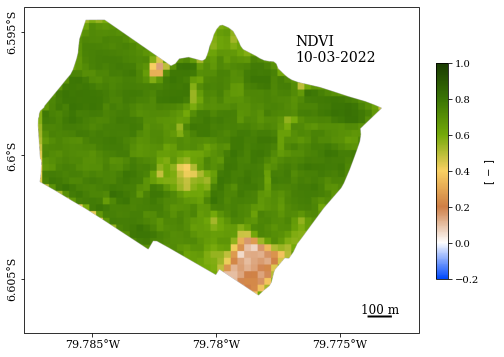

In [42]:
# Visualización
ndvi_cmap = ['0048fb', 'ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03'] # -0.2 - 1

vis_params_ndvi = {'min': -0.2, 
                   'max': 1, 
                   'palette': ndvi_cmap}

image = img_ndvi.clip(predios_agricolas)

if img_prod_stats['min']['NDVI'] < 0:
  # image = image.where(image.lte(0), 0) # Asignar valor 0 a negativos
  image = image.updateMask(image.gt(0)) # Eliminar pixeles negativos y mantener positivos
    
vis_params = vis_params_ndvi
title_map = f'NDVI\n{img_date_format1}'
label = '$[\; - \;]$'

get_grafica_cartoee_color(image, vis_params, title_map, label, save_fig=None)

In [43]:
# Visualización
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_ndvi, title_map) 

Map.add_colorbar(vis_params_ndvi, label= 'NDVI [-]', orientation= 'vertical')

Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

##### Área Foliar

In [71]:
img_prod_stats_df['LAI']

max       1.824356
mean      1.004234
median    1.051343
min      -0.139684
mode      1.074093
stdDev    0.357172
Name: LAI, dtype: float64

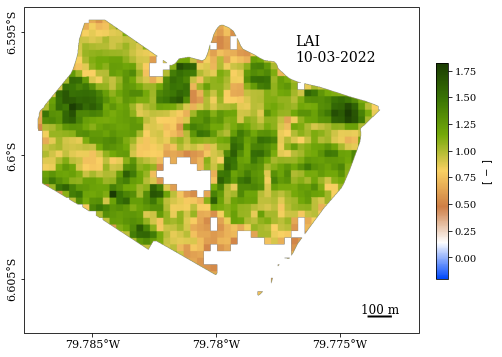

In [74]:
# Visualización
vis_params_lai = {'min': -0.2, 
                  'max': img_prod_stats['max']['LAI'], 
                  'palette': ndvi_cmap} # cmp.get_palette('RdYlGn')

image = img_lai.clip(predios_agricolas).blend(predios_vis).updateMask(img_lai.gt(0.5))

# Para obtener G con la equación empírica de Tasumi es necesario el mapa de LAI
# Para: 
#     LAI < 0.5 : G = 1.8*(Ts_K - 273.15) + 0.084*Rn
#     LAI >= 0.5 : G = 0.05*Rn + 0.18*exp() 

# if img_prod_stats['LAI']['min'] < 0:
  # image = image.where(image.lte(0), 0) # Asignar valor 0 a negativos
  # image = image.updateMask(image.gt(0)) # Eliminar pixeles negativos y mantener positivos

vis_params = vis_params_lai
title_map = f'LAI\n{img_date_format1}'
label = '$[\; - \;]$'

get_grafica_cartoee_color(image, vis_params, title_map, label, save_fig=None)

In [73]:
# Visualización
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_lai, 'LAI') 

Map.add_colorbar(vis_params_lai, label="LAI [-]", orientation="vertical")

Map

Map(center=[-6.600107155901065, -79.78025931943186], controls=(WidgetControl(options=['position', 'transparent…

### Flujo de calor del suelo / Soil Heat Flux $G$

#### Desarrollo

Flujo de calor del suelo $G$

$$
\frac{G}{R_n} = ( T_s - 273.15 ) (0.0038 + 0.0074 \alpha ) (1-0.98 \; \text{NDVI}^4) \; \; \; \; \text{(26)}
$$

Where:
- $T_s$ : surface temperature (K)
- $\alpha$ : surface albedo

In [61]:
# Obtener G/R_n

# Forma 1: Usando expression
G_Rn = img_Ts_K.expression(
        '(Ts_K - 273.15)*(0.0038 + 0.0074*albedo)*(1-0.98*NDVI**4)',
        {'Ts_K': img_Ts_K,
         'albedo': img_albedo,
         'NDVI': img_ndvi}
    ).rename('G_Rn').clip(predios_agricolas)

# Forma 2: Usando métodos de forma lineal (menos comprensible)
# G_R_n = (
#     img_Ts_c # Ts - 273.15
#     .multiply(img_albedo.multiply(0.0074).add(0.0038)) # albedo*0.0074 + 0.0038
#     .multiply(img_ndvi.select('NDVI').pow(4).multiply(-0.98).add(1)) 
#     .rename('G_R_n').clip(predios_agricolas)
# ) # img_Ts_c = img_Ts_k.subtract(273.15)


# Rangos de G/R_n
G_Rn_minmax = G_Rn.reduceRegion(ee.Reducer.minMax(),
                                geometry=predios_agricolas,
                                scale=30).values().reverse().getInfo()
print(f'G_Rn_minmax: {G_Rn_minmax}')


# Obtener G
G = G_Rn.multiply(R_n.select('R_n')).rename('G')

# Rangos de G
G_minmax = G.reduceRegion(ee.Reducer.minMax(), scale=30).values().reverse().getInfo()
print(f'G_minmax: {G_minmax[0]:.5f} W/m² - {G_minmax[1]:.5f} W/m²')

G_Rn_minmax: [0.07645872882224285, 0.13806823420923267]
G_minmax: 42.04784 W/m² - 86.86905 W/m²


In [70]:
img_prod_stats_df['LAI']

max       1.824356
mean      1.004234
median    1.051343
min      -0.139684
mode      1.074093
stdDev    0.357172
Name: LAI, dtype: float64

In [ ]:
# # Forma 2: Tasumi (2003) using soil heat flux data collected by Wright (1982), 
# # USDA-ARS for irrigated crops near Kimberly, Idaho

# if pix_lai.getInfo() < 0.5:
#     G_pix = ee.Number.expression(
#         '1.8*(pix_ts-273.15)+0.084*R_n_calculated', # (pix_ts-273.15) cuando pix_ts es en Kelvin para obtener °C
#         {'pix_ts':pix_ts,   # pix_ts está en K
#          'R_n_calculated':R_n_calculated
#          }
#         )
# else:
#     G_pix = ee.Number.expression(
#         '0.05 + 0.18*pix_lai*R_n_calculated',
#         {'pix_lai':pix_lai.multiply(-0.521).exp(),
#          'R_n_calculated':R_n_calculated
#          }
#         )

In [67]:
# Visualización: Flujo de calor del suelo G
vis_rgb_tasumi = {'min': 0.0,
                  'max': 0.3,
                  'bands': ['B4_SR', 'B3_SR', 'B2_SR']}

G_vis = {'min':G_minmax[0],
         'max':G_minmax[1], 
         'palette': cmp.get_palette('RdYlGn_r')}


Map = geemap.Map(layer_ctrl=True)#height='800px') 
Map.centerObject(predios_agricolas, 16)

Map.addLayer(img_sr_tasumi.clip(predios_bound), vis_rgb_tasumi, 'RGB SR') 

Map.addLayer(G, G_vis, 'G') 
# Map.addLayer(G.updateMask(G.gt(0)), {'min':0, 'max': G_minmax[1], 'palette': cmp.get_palette('RdYlGn_r')}, 'G_gt0') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Map(center=[-6.599795740070353, -79.78072031868163], controls=(WidgetControl(options=['position', 'transparent…

### Flujo de calor sensible / Sensible Heat Flux $H$

#### Descripción

METRIC differs from previous applications of SEBAL principally in how the 'H function' is calibrated for each specific satellite image. In both METRIC and SEBAL, H (W m-2) is estimated from an aerodynamic function

$$
H = \rho_{\text{air}} C_p \frac{dT}{ r_{\text{ah}} } 
$$

Where:
- $\rho_{\text{air}}$ : air density (kg m-3)
- $C_p$ : specific heat of air at constant pressure (J kg-1 K-1)
- $r_{\text{ah}}$ : aerodynamic resistance (s m-1) between two near surface heights, z1 and z2 (generally 0.1 and 2 m) computed as a function of estimated aerodynamic roughness of the particular pixel. 

In METRIC, the $r_{\text{ah}}$ calculation **uses wind speed extrapolated from some blending height above the ground surface (typically 100 to 200 m) and an iterative stability correction scheme based on the Monin-Obhukov functions (Allen et al. 1996)**. The *dT* parameter (K) represents the near-surface temperature difference between z1 and z2. 
- *dT* is used because of the difficulty in estimating surface temperature ($T_s$) accurately from satellite due to uncertainty in atmospheric attenuation or contamination and radiometric calibration of the sensor. 

- In addition, $T_s$, as measured by satellite (i.e., radiometric or kinetic temperature) **can deviate from** the "aerodynamic" temperature that derives the heat transfer process by several degrees (Kustas et al. 1994; Norman et al. 1995; Qualls and Brutsaert 1996). 
> Además, la Ts , medida por satélite (es decir, la temperatura radiométrica o cinética) **puede desviarse de** la temperatura "aerodinámica" que deriva del proceso de transferencia de calor en varios grados (Kustas et al. 1994; Norman et al. 1995; Qualls y Brutsaert 1996).

The temperature gradient *dT* is designed to "float" above the surface, beyond the height for sensible heat roughness ($z_{oh}$) and zero plane displacement, and can be approximated as a relatively simple linear function of $T_s$ as pioneered by Bastiaanssen (1995)

$$
dT = a + b \; T_{s \; \text{datum}}
$$

where:

- $a$ and $b$ : empirically determined constants for a given satellite image  
- $T_{s \; \text{datum}}$ : surface temperature adjusted to a common elevation data for each image pixel using a digital elevation model and customized lapse rate. 

Bastiaanssen (1995) provided empirical evidence for using the linear relation between *dT* and $T_s$. Theoretically, assuming some essentially constant temperature at a blending height well above the surface, for example at 100-200 m, where temperature is nearly independent of $H$, and with all instability effects incorporated into $r_{\text{ah}}$, Eq. (28) suggests that *dT* and thus, $T_s$, will be largely proportional to H for a fixed aerodynamic condition. Therefore, one can anticipate a segment of the temperature profile, represented by *dT*, to be proportional to both $H$ and to $T_s$. 



The application of Eq. (29) appears to extend well across a range of surface roughness, because as roughness increases and $r_{ah}$ decreases, *dT*, for the same value of $H$, decreases due to a more efficient transfer of $H$, and $T_s$ reduces for the same reason. 

The determination of a and b is described in a following section. 

The use of *dT* indexed to $T_s$ that does not rely on absolute values for $T_s$ substantially reduces error in the calculation of $H$. This approach constitutes on one of the pioneering components of the SEBAL model developed by Bastiaanssen (1995). 

The use of $T_{s \; \text{datum}}$ in Eq. (29) corrects for cooling impacts on $T_s$ due to increasing evaluation within an image that are not related to *dT* and sensible heat flux.

**Aerodynamic Transport**

The value for $r_{\text{ah}}$ is **strongly influenced by** the buoyancy within the boundary layer **driven by** the rate of sensible heat flux. Because both $r_{\text{ah}}$ and $H$ are unknown at each pixel, an iterative solution is required. 

During the first iteration, $r_{\text{ah}}$ is computed assuming neutral stability

$$
r_{\text{ah}} = \frac{\ln{(z_2/z_1)}}{{u*} \; k} \; \; \; \; \qquad (30)
$$

Where:
- $z_1$ and $z_2$ : heights above the zero-plane displacement of the vegetation where the endpoints of *dT* are defined 
- $u*$ : friction velocity (m s-1) 
- $k$ : von Karman's constant **(0.41)**. 

Friction velocity $u*$ is computed during the first iteration using **the logarithmic wind law for neutral atmospheric conditions**

$$
u* = \frac{ ku_{200} }{ \ln{(200/z_{om})} } \; \; \; \; \qquad (31)
$$

Where:
- $u_{200}$ : wind speed (m s-1) at a blending height assumed to be 200 m, and
- $z_{om}$ : momentum roughness length (m). $z_{om}$ is a measure of the form drag and skin friction for the layer of air that interacts with the surface.

$u*$ is computed for each pixel inside the process model **using a specific roughness length for each pixel**, but with $u_{200}$ assumed to be constant over all pixels of the image since it is defined as occuring at a "blending height" unaffected by surface features. Eqs. (30) and (31) support the use of a temperature gradient defined between two heights that are both above the surface. This allows one to estimate $r_{\text{ah}}$ without having to estimate a second aerodynamic roughness for sensible heat transfer ($z_{oh}$), since height $z_1$ is defined to be at an elevation above $z_{oh}$. This is an advantage because $z_{oh}$ can be difficult to estimate for sparse vegetation. 



The wind speed at an assumed blending height (200 m) above the weather station, $u_{200}$, is calculated as

$$
u_{200} = \frac{ u_w \ln{(200/z_{omw})} }{ \ln{(z_x/z_{omw})} } \qquad (32)
$$

Where:
- $u_w$ : wind speed measured at a weather station at $z_x$ height above the surface
- $z_{omw}$ : the roughness length for the weather station surface, similar to Allen and Wright (1997).

All units for $z$ are the same. The value for $u_{200}$ is assumed constant for the satellite image. This asumption allows for the use of a constant relation between *dT* and $T_s$.

Tasumi et al. (2005b) showed ET as calculated by METRIC to be relatively insensitive to the value for $z_{om}$. In METRIC, the momentum roughness length $z_{om}$ **is estimated for each pixel according to land use type or amount of vegetation**. General landuse type is used where the variation in $z_{om}$ as a function of vegetation amount is not well established. General values are given in Brutsaert (1982) and Allen et al. (1996). In agricultural areas, $z_{om}$ and, in turn, crop height is generally proportional to the LAI, and is therefore calculated as a function of LAI for “short” agricultural crops (less than about 1 m in height) using a relationship from Tasumi (2003)

$$
z_{om} = 0.018 \; \text{LAI} \qquad (33)
$$

where $z_{om}$ has units of m and LAI is dimensionless.

A minimum value for $z_{om} = 0.005$ m represents roughness typical of bare agricultural soils. Eq. (33) tends to underestimate $z_{om}$ for corn which is typically 2 to 3 m in height (Tasumi 2003), and a different function would be required for vines and trees. Because of the difficulties in estimating $z_{om}$ from a general function of LAI for all vegetation types within an image, Bastiaanssen (2000) suggested customizing a function for $z_{om}$ based on NDVI that is developed for each satellite image 

$$
z_{om} = \exp{[( a_1 \text{NDVI}) + b_1]} \qquad (34a)
$$

or, as modified by Allen (2002)

$$
z_{om} = \exp{[( a_1 \text{NDVI}/\alpha) + b_1]} \qquad (34b)
$$

where
- $a_1$ and $b_1$ : regression constants derived from a plot of $\ln{(z_{om})}$ versus NDVI or $\ln{(z_{om})}$ versus NDVI/$\alpha$ for two or more conditions in the image representing specific vegetation types. 

Eqs. (34a) and (34b) must be fitted to local vegetation and conditions. Generally $\alpha$ is lower for taller vegetation such as trees due to shading. Therefore, the use of albedo helps to distinguish between tall and short vegetation types that may have similar NDVI, but different albedo. Variations on Eqs. (34a) and (34b) can be explored by the user to improve the predictive accuracy, including use of other parameters.






**The effects of mountainous terrain and elevation on wind speed** are complicated and difficult to quantify (Oke 1987). In METRIC, $z_{om}$ for image pixels in mountains is adjusted on a rudimentary basis to attempt to account for effects of general terrain roughness on momentum and heat transfer. 

An empirical adjustment is made by multiplying $z_{om}$, as calculated using Eqs. (33) and (34a) and (34b) or from general land classification, by a function determined locally in Idaho **using slope** as computed from a digital elevation model

$$
z_{om_min} = z_{om} \left( 1 + \frac{(180/\pi)s - 5}{20} \right) \qquad (35)
$$

To further adjust the heat transfer equation for mountanious terrain, $u_{200}$ at mountainous image pixels is multiplied by a wind speed weighting coefficient ($\omega$) before computing $u*$ and $r_{ah}$. $w$ is calculated as

$$
\omega = 1+0.1 \left( \frac{\text{Elevation} - \text{Elevation}_{\text{station}}}{1000} \right) \qquad (36)
$$

where:
- $\text{Elevation}$: elevation of the pixel (m), and 
- $\text{Elevation}_{\text{station}}$: elevation where the wind speed is measured. 

Equations (35) and (36) were developed during METRIC applications in mountainous regions of southern Idaho (Tasumi 2003).


**Air density** in the aerodynamic equation is calculated using standard equations for mean atmospheric pressure and the universal gas law and simplifying for the effect of vapor pressure (virtual temperature is estimated as 1.01 $T_s$) as done by Allen et al. (1998)

$$
\rho_{air} = \frac{1000P}{1.01(T_s - dT)R}
$$

where:
- $\rho_{air}$ : air density (kg m-3)
- $P$ : mean atmospheric pressure for the pixel elevation (kPa)
- $R$ : specific gas constant (287 J kg-1 K-1)
- $T_s - dT$ : surrogate (K) for near-surface air temperature at the pixel 


#### Desarrollo

##### Selección de pixeles 

**Referencia**
- Bhattarai, N., Quackenbush, L. J., Im, J., & Shaw, S. B. (2017). A new optimized algorithm for automating endmember pixel selection in the SEBAL and METRIC models. *Remote Sensing of Environment*, 196, 178-192. [10.1016/j.rse.2017.05.009](http://dx.doi.org/10.1016/j.rse.2017.05.009)

**Selección de pixeles fríos y calientes**

- In terms of identifying a cold pixel, the search method seeks to find
the coldest pixels with the highest NDVI. There is not necessarily one
pixel that has both the lowest Ts and the highest NDVI. Thus, instead
of searching for a single pixel, the method searches for a subset of pixels that have both low NDVI and high Ts.
- Specifically, the cold pixel selection process starts by searching for **pixels that have a Ts value within the lowest n1% (e.g. n1 = 1) of the Ts histogram** and NDVI values in
the top n2% (e.g. n2 = 1) of the NDVI histogram.
- The search continues by increasing the value of n2 first (i.e. increasing n2 in increments of 1 up to 10, keeping n1 = 1) and then increasing n1 (up to 10 in increments of 1) until 10 pixels are identified.

In [36]:
# Datos
# 2 de Diciembre 2021: Almácigo
# 4 de Enero 2022: Transplante

# 8 Imágenes seleccionadas
ids = [
    'LANDSAT/LC09/C02/T1/LC09_010065_20211212', # 0 - 12/12 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220113', # 1 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
    'LANDSAT/LC09/C02/T1/LC09_010065_20220129', # 2 - 01/29 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220310', # 3 - 03/10 - l8
    'LANDSAT/LC09/C02/T1/LC09_010065_20220403', # 4 - 04/03 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220521', # 5 - 05/21 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220529', # 6 - 05/29 - l8
    'LANDSAT/LC08/C02/T1/LC08_010065_20220614'  # 7 - 06/14 - l8
      ]

# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

# dem.reduceRegion(ee.Reducer.minMax(), geometry=predios_agricolas,scale=30).getInfo() 
# {'elevation_max': 54, 'elevation_min': 40}

In [37]:
albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061'] # 0 - 0.5
ndvi_cmap = ['0048fb', 'ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03'] # -0.2 - 1
ts_cmap = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026'] # 280 - 330 en K o 6.85 - 56.85 en °C
rn_cmp = ['560e0d', 'fd5903', 'fbfe04', '3aff01', '01feef', '0000fe', 'fd6dfd', 'ffffff']
rn_cmp_r = ['ffffff', 'fd6dfd', '0000fe', '01feef', '3aff01', 'fbfe04', 'fd5903', '560e0d']
# Revertir lista
# https://datagy.io/python-reverse-list/s
# cmp.plot_colormaps(width=12, height=0.4)

In [38]:
# Imagen Landsat
img_id = ids[7]
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)
img_date = img_ee.date().format('YYYY-MM-dd').getInfo()

# Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

# Imágenes
img_ndvi = img_productos.select('NDVI')
img_savi = img_productos.select('SAVI')
img_lai  = img_productos.select('LAI')
img_albedo = img_productos.select('albedo')
img_Ts_c = img_productos.select('Ts_c')
img_Ts_k = img_productos.select('Ts_k')
img_slope = img_productos.select('slope')

cos_theta_rel = img_productos.select('cos_theta')
t_sw = img_productos.select('t_sw')
e_0  = img_productos.select('e_0')

img_toa = img_toa.clip(predios_bound)

img_Ts_c = img_Ts_c.clip(predios_agricolas)
img_ndvi = img_ndvi.clip(predios_agricolas)
img_albedo = img_albedo.clip(predios_agricolas)

print(f'Rn de imagen {img_date} procesada!')

img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index')


# Diccionarios de visualización
vis_params_ndvi = {
    'min': -0.2, # img_productos_dict['min']['NDVI'],
    'max': 1,    # img_productos_dict['max']['NDVI'],
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn')
}

vis_params_ts = {
    'min': img_productos_dict['min']['Ts_c'],
    'max': img_productos_dict['max']['Ts_c'],
    'palette':cmp.get_palette('RdYlBu_r')
}

vis_params_alb = {
    'min': 0,
    'max': 0.25,
    'palette': cmp.get_palette('afmhot') #cmp.get_palette('afmhot') albedo_cmap
}


# cmp.palettes.gist_rainbow
display(img_productos_df)

Rn de imagen 2022-06-14 procesada!


,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,slope,t_sw
max,0.687171,0.564996,0.374299,31.961642,305.111642,0.314650,0.807201,0.956872,0.972268,6.230337,0.659323
mean,0.145284,0.264075,0.168860,28.679619,301.829619,0.190679,0.766265,0.951453,0.970479,1.693220,0.659188
median,0.181641,0.278310,0.188720,28.280544,301.422697,0.192800,0.764497,0.951812,0.970591,1.860348,0.659188
min,-0.114732,0.085178,0.035070,24.142331,297.292331,0.085689,0.723844,0.948853,0.969621,0.000000,0.659063
mode,0.232373,0.286231,0.206115,30.513420,300.390561,0.202662,0.763783,0.952056,0.970649,0.930388,0.659184
stdDev,0.141349,0.089439,0.065356,1.630059,1.630059,0.042736,0.014451,0.001413,0.000466,0.962314,0.000038


Imagen Sentinel-2 que servirá de ayuda para una mejor selección de pixeles fríos y calientes.

In [ ]:
img_s2_id = 'COPERNICUS/S2/20220615T153619_20220615T154006_T17MPN' # 2022-06-14
# img_s2_id = 'COPERNICUS/S2/20211212T153621_20211212T154103_T17MPN' # 2021-12-12

img_s2 = ee.Image(img_s2_id) 
img_s2_vis = img_s2.multiply(0.0001).clip(predios_bound)
img_s2_date = img_s2.date().format('YYYY-MM-dd').getInfo()

print(img_s2_date)

In [ ]:
vis_rgb_s2 = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2'], 'gamma': 0.4} 

A continuación se realizará el friltrado de pixeles. Mediante la revisión de mapas de temperatura, NDVI y albedo es posible visualizar focos de calor.

###### Funciones `recorte_por_percentiles` y `get_pixel_values` 

In [39]:
def recorte_por_percentiles(n1, n2, img_ndvi, img_ts, geometry, filtrado=None):
    
    # Para NDVI > 0, retorna el percentil n1
    perc_n1 = ee.Number(
        img_ndvi.updateMask(img_ndvi.gte(0))
        .reduceRegion(ee.Reducer.percentile([n1]), geometry=geometry, scale=30)
        .values()
        )
    
    if filtrado == 'cold':
        # Para los valores de ndvi mayores al percentil perc_n1, retornar sus temperaturas
        ts_recortado_p_n1 = img_ts.updateMask(img_ndvi.gte(perc_n1))
    else:
        img_ndvi = img_ndvi.clip(geometry)
        img_ts = img_ts.clip(geometry)
        # Para los valores de ndvi menores al percentil perc_n1, retornar sus temperaturas
        ts_recortado_p_n1 = img_ts.updateMask(img_ndvi.lte(perc_n1))
        
    
    perc_n2 = ee.Number(
        ts_recortado_p_n1
        .reduceRegion(ee.Reducer.percentile([n2]), geometry=geometry, scale=30)
        .values()
        )
    
    if filtrado == 'cold':
        # Los valores más bajos de temperatura
        pixeles = ts_recortado_p_n1.updateMask(ts_recortado_p_n1.lte(perc_n2))
    else:
        # Los valores más altos de temperatura
        pixeles = ts_recortado_p_n1.updateMask(ts_recortado_p_n1.gte(perc_n2))
            
    return pixeles

In [40]:
# Obtener Valores de acuerdo al pixel seleccionado

def get_pixel_values(punto, pixeles, d2, img_productos, dem):
    
    # Seleccionando imagenes a partir de img_productos
    img_ndvi = img_productos.select('NDVI')
    img_savi = img_productos.select('SAVI')
    img_lai  = img_productos.select('LAI')
    img_albedo = img_productos.select('albedo')
    img_Ts_c = img_productos.select('Ts_c')
    img_Ts_K = img_productos.select('Ts_k')
    cos_theta_rel = img_productos.select('cos_theta')
    t_sw = img_productos.select('t_sw')
    e_0  = img_productos.select('e_0')
    img_slope = img_productos.select('slope')
   
    # Reductores
    pix_ndvi  = ee.Number(img_ndvi.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('NDVI'))
    pix_lai   = ee.Number(img_lai.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('LAI'))
    pix_savi  = ee.Number(img_savi.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('SAVI'))

    pix_elev  = ee.Number(dem.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('elevation'))
    pix_slope = ee.Number(img_slope.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('slope'))
    
    pix_alb   = ee.Number(img_albedo.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('albedo'))
    pix_ts_K    = ee.Number(pixeles.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('Ts_k'))
  
    pix_theta = ee.Number(cos_theta_rel.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('cos_theta'))
    pix_t_sw  = ee.Number(t_sw.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('t_sw'))
    pix_e_0   = ee.Number(e_0.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('e_0'))
                       
    
    # Radiación Neta R_n
    R_n_calculated = ee.Number.expression(
        """
        (1-pix_alb)*1367*pix_theta/d2*pix_t_sw 
        + pix_e_0*5.67*10**(-8)*( 0.85*(-pix_t_sw_log)**0.09 - 1 )*pix_ts_K_pow4
        """,
        {
            'pix_alb': pix_alb,
            'pix_theta': pix_theta,
            'd2': d2,
            'pix_t_sw': pix_t_sw,
            'pix_t_sw_log': pix_t_sw.log(),
            'pix_e_0': pix_e_0,
            'pix_ts_K_pow4': pix_ts_K.pow(4) # en K
        }
    )
    
    # Flujo de Calor del Suelo G
    # Forma 1: Using an empirical equation by Bastiaanssen (2000) representing values near midday 
    
    G_pix = ee.Number.expression(
        '(Ts_K - 273.15)*(0.0038 + 0.0074*albedo)*(1-0.98*NDVI_pow4)*R_n_calculated',
        {
            'Ts_K': pix_ts_K,
            'albedo': pix_alb,
            'NDVI_pow4': pix_ndvi.pow(4),
            'R_n_calculated': R_n_calculated
        }
    )
    
    
    # Forma 2: Tasumi (2003) using soil heat flux data collected by Wright (1982), 
    # USDA-ARS for irrigated crops near Kimberly, Idaho
    
#     if pix_lai.getInfo() < 0.5:
#         G_pix = ee.Number.expression(
#             '1.8*(pix_ts-273.15)+0.084*R_n_calculated', # (pix_ts-273.15) cuando pix_ts es en Kelvin para obtener °C
#             {'pix_ts':pix_ts,   # pix_ts está en K
#              'R_n_calculated':R_n_calculated
#              }
#             )
#     else:
#         G_pix = ee.Number.expression(
#             '0.05 + 0.18*pix_lai*R_n_calculated',
#             {'pix_lai':pix_lai.multiply(-0.521).exp(),
#              'R_n_calculated':R_n_calculated
#              }
#             )
    
    # Producir un diccionario para exportar

    R_n_calculated = R_n_calculated.getInfo()
    G_pix = G_pix.getInfo()
    
    pix_values_list = ee.List(
        [R_n_calculated, G_pix, pix_ndvi, pix_savi, pix_lai, pix_alb, pix_ts_K, pix_t_sw, pix_e_0, pix_elev, pix_slope])
                          # pix_elev, pix_slope, pix_theta,
    columns = ['R_n', 'G', 'NDVI', 'SAVI', 'LAI', 'Albedo', 'Ts', 'T_sw', 'e_0', 'Elev_m', 'Slope_d']
                        
    pix_values = ee.Dictionary.fromLists(columns, pix_values_list).getInfo()
    
    return pix_values

###### Pixeles Fríos

Pixeles Fríos: 
Encontrar el grupo de pixeles con
- NDVI alto
- Temperatura superficial baja

Procedimiento:
- Obtener percentil n1 para imagen NDVI con valores positivos [(ee.Reducer.percentile)](https://developers.google.com/earth-engine/apidocs/ee-reducer-percentile)
- Obtener valores de NDVI > n1 
- Recortar mapa de temperatura para valores Ts < $n_2$ en función de valores de NDVI > $n_1$
- Seleccionar un pixel y anotar coordenadas

In [ ]:
# # Prueba For
# for n2_i in [10, 20, 30, 40, 50]:
#     # Selección de Pixel Frío - Recorte de mapas
#     n1 =  50  # n1 : Percentil para NDVI
#     n2 =  n2_i  # n2 : Percentil para temperatura

#     pixeles_frios = recorte_por_percentiles(
#         n1, n2, img_ndvi, img_Ts_k, predios_agricolas, filtrado='cold').subtract(273.15)

#     pixeles_frios_minmax = (
#         pixeles_frios.reduceRegion(ee.Reducer.minMax(), scale=30)
#         .values().reverse().getInfo()
#     )

#     # Inputs para gráfico
#     paleta = 'RdYlBu_r'  # Rampa de color azul y rojo
#     # paleta = 'binary_r'  # Color negro indica el pixel más frío

#     vis_params_pix = {
#         'min': pixeles_frios_minmax[0],
#         'max': pixeles_frios_minmax[1],
#         'palette': cmp.get_palette(paleta)
#     }

#     image = pixeles_frios.blend(predios_vis)
#     vis_params = vis_params_pix

#     title_map = f'Pix Fríos \n{img_date}\nn1: {n1} - n2: {n2}'
#     path_fig = f'/pixeles/{img_date}/{img_date}_n1_{n1}_n2_{n2}_Pix_F_{paleta}'
#     label = '$[\; °C\;]$'

#     # Resultado
#     print(img_date)
#     print(f'Tmin - Tmax: {pixeles_frios_minmax}')

#     get_grafica_cartoee_color(image, 
#                               vis_params, 
#                               title_map, 
#                               label,
#                               save_fig=path_fig)

2022-06-14
Tmin - Tmax: [24.14233075457588, 26.639202309329562]


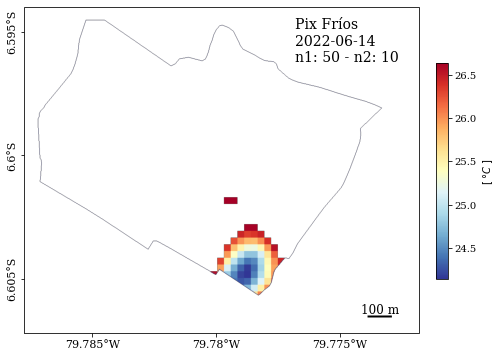

In [41]:
# Selección de Pixel Frío - Recorte de mapas
n1 =  50  # n1 : Percentil para NDVI
n2 =  10  # n2 : Percentil para temperatura

pixeles_frios_K = recorte_por_percentiles(
    n1, n2, img_ndvi, img_Ts_k, predios_agricolas, filtrado='cold')

pixeles_frios_C = pixeles_frios_K.subtract(273.15)
pixeles_frios_minmax = (
    pixeles_frios_C.reduceRegion(ee.Reducer.minMax(), scale=30)
    .values().reverse().getInfo()
)

# Inputs para gráfico
paleta = 'RdYlBu_r'  # Rampa de color azul y rojo
# paleta = 'binary_r'  # Color negro indica el pixel más frío

vis_params_pix = {
    'min': pixeles_frios_minmax[0],
    'max': pixeles_frios_minmax[1],
    'palette': cmp.get_palette(paleta)
}

image = pixeles_frios_C.blend(predios_vis)
vis_params = vis_params_pix

title_map = f'Pix Fríos \n{img_date}\nn1: {n1} - n2: {n2}'
path_fig = f'/pixeles/{img_date}_n1_{n1}_n2_{n2}_Pix_F_{paleta}'
label = '$[\; °C\;]$'

# Resultado
print(img_date)
print(f'Tmin - Tmax: {pixeles_frios_minmax}')

get_grafica_cartoee_color(image, 
                          vis_params, 
                          title_map, 
                          label,
                          save_fig=path_fig)

In [42]:
# Visualización
vis_params_pix = {
    'min': pixeles_frios_minmax[0],
    'max': pixeles_frios_minmax[1],
    'palette': cmp.get_palette('binary') # Color negro el pixel más frío
}

image = pixeles_frios_C.blend(predios_vis)
vis_params = vis_params_pix
title_map = 'Pixeles fríos'
label = '$[\; °C\;]$'


# Obtener visualización con geemap.Map
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)

Map.addLayer(img_toa.clip(predios_bound).blend(predios_vis), vis_rgb, 'RGB TOA')
# Map.addLayer(img_s2_vis.blend(predios_vis), vis_rgb_s2, f'Sentinel {img_s2_date}')

Map.addLayer(img_Ts_c, vis_params_ts, 'img_Ts_c')
Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
Map.addLayer(img_albedo, vis_params_alb, 'img_albedo')

Map.addLayer(image, vis_params, title_map)

Map.add_colorbar(vis_params_ndvi, label="NDVI [-]", orientation="horizontal")
Map.add_colorbar(vis_params_alb, label="Albedo [-]", orientation="horizontal")#, discrete=True)
Map.add_colorbar(vis_params, label="Ts [°C]", orientation="horizontal")
Map.add_colorbar(vis_params_ts, label="Ts [°C]", orientation="horizontal")

Map

Map(center=[-6.599795740070353, -79.78072031868163], controls=(WidgetControl(options=['position', 'transparent…

In [43]:
Map.user_rois.geometry().coordinates().getInfo() 

# '2022-03-10': [-79.784451, -6.597031]
# '2022-06-14': [-79.778717, -6.60486]

[-79.778717, -6.60486]

In [45]:
# Pixel Frío
pix_cold_n1 = n1 
pix_cold_n2 = n2
print(f'n1: {pix_cold_n1} - n2: {pix_cold_n2}')

# Ejemplo de pixel: 
# coordenada = [-79.784444, -6.597026] # '2022-03-10'
# coordenada = [-79.784451, -6.597031] # '2022-03-10'
coordenada = [-79.778717, -6.60486] # '2022-06-14'
# coordenada = [-79.778724, -6.604617] # '2022-06-14'
pix_cold = ee.Geometry.Point(coordenada)

print(img_date)

# pix_cold = Map.user_rois.geometry()
print(f'Pixel Frío: {pix_cold.coordinates().getInfo()}')

pix_cold_values = get_pixel_values(pix_cold, pixeles_frios_K, d2, img_productos, dem)
pix_cold_values
# print(f'Rn: {pix_hot_values[0]:.5f} W/m²\nG : {pix_hot_values[1]:.5f} W/m²')

n1: 50 - n2: 10
2022-06-14
Pixel Frío: [-79.778717, -6.60486]


{'Albedo': 0.18027162954042425,
 'Elev_m': 45,
 'G': 52.368545441846976,
 'LAI': 0.5995532712843418,
 'NDVI': 0.535677137507801,
 'R_n': 459.59391174654314,
 'SAVI': 0.3480963199786044,
 'Slope_d': 2.084105344420737,
 'T_sw': 0.6590985260789601,
 'Ts': 297.29233075457586,
 'e_0': 0.9559955327128433}

In [46]:
pix_cold_values

{'Albedo': 0.18027162954042425,
 'Elev_m': 45,
 'G': 52.368545441846976,
 'LAI': 0.5995532712843418,
 'NDVI': 0.535677137507801,
 'R_n': 459.59391174654314,
 'SAVI': 0.3480963199786044,
 'Slope_d': 2.084105344420737,
 'T_sw': 0.6590985260789601,
 'Ts': 297.29233075457586,
 'e_0': 0.9559955327128433}

In [195]:
pix_cold_values['Albedo']

0.14747596702162694

In [196]:
print(pix_cold_values['Ts'])
print(pix_cold_values['Ts']-273.15)

298.0962288109693
24.94622881096933


```
n1: 50 - n2: 10
2022-03-10
Pixel Frío: [-79.784485, -6.597054]
{'Albedo': 0.14747596702162694,
 'Elev_m': 47,
 'G': 51.084164766642715,
 'LAI': 1.0059053271800849,
 'NDVI': 0.7395504864139549,
 'R_n': 592.2853219180588,
 'SAVI': 0.45378351611273904,
 'Slope_d': 0,
 'T_sw': 0.6738524132498025,
 'Ts': 298.0962288109693,
 'e_0': 0.9600590532718009}
```

###### Pixeles Calientes

In [22]:
# En la parte inferior izquierda se encuentra un área de estacionamiento el cual afecta en la temperatura 
# superficial a las áreas cercanas. Por ello, es necesario trazar otra área mas específica para que 
# no se afecte la selección de pixeles.

# 1. Primero se debe correr por defecto el código
# 2. Una vez ubicada el área, dibujamos un rectángulo en dicha zona para obtener sus coordenadas
# Map.user_rois.geometry().coordinates().getInfo()
# Produce:
# [[[-79.779268, -6.605731],
#   [-79.779268, -6.603185],
#   [-79.777055, -6.603185],
#   [-79.777055, -6.605731],
#   [-79.779268, -6.605731]]]

# 3. Le damos el formato a las coordenadas
# https://developers.google.com/earth-engine/apidocs/ee-geometry-rectangle
ee_Rectangle = ee.Geometry.Rectangle([
    [-79.779268, -6.603185],
    [-79.777055, -6.605731]
])
# 4. Asignamos la nueva geometría como input en geometría

Tmin - Tmax: [30.582448240611086, 31.961641608368097]


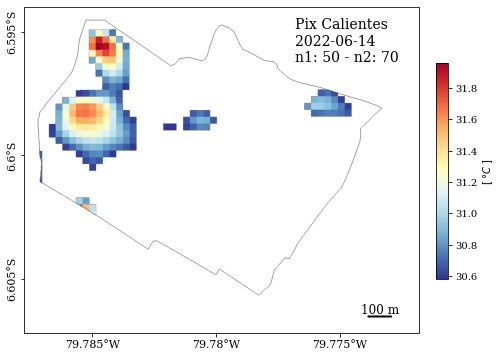

In [47]:
# Selección de Pixel Caliente - Recorte de mapas
n1 =  50 # n1 : Percentil para NDVI
n2 =  70 # n2 : Percentil para temperatura

pixeles_hot_K = recorte_por_percentiles(
    n1, n2, img_ndvi, img_Ts_k, 
    geometry=predios_agricolas # ee_Rectangle, predios_agricolas
)
    
pixeles_hot_C = pixeles_hot_K.subtract(273.15) 

pixeles_hot_minmax = (
    pixeles_hot_C.reduceRegion(ee.Reducer.minMax(), scale=30)
    .values().reverse().getInfo()
)

print(f'Tmin - Tmax: {pixeles_hot_minmax}')

# Obtener gráfica con cartoee
paleta = 'RdYlBu_r'
# paleta = 'binary_r' # Color negro o rojo el pixel más caliente

vis_params_pix = {
    'min': pixeles_hot_minmax[0],
    'max': pixeles_hot_minmax[1],
    'palette': cmp.get_palette(paleta) 
}

# ee_RectangleVis = ee.Image().paint(ee_Rectangle, 1, 1)
image = pixeles_hot_C.blend(predios_vis) # predios_vis, ee_RectangleVis
vis_params = vis_params_pix
title_map = f'Pix Calientes \n{img_date}\nn1: {n1} - n2: {n2}'
path_fig  = f'/pixeles/{img_date}_n1_{n1}_n2_{n2}_Pix_C_{paleta}'

label = '$[\; °C\;]$'

get_grafica_cartoee_color(image, 
                          vis_params, 
                          title_map, 
                          label,
                          save_fig=None)

In [48]:
# Visualización
vis_params_pix = {
    'min': pixeles_hot_minmax[0],
    'max': pixeles_hot_minmax[1],
    'palette': cmp.get_palette('binary') # Color negro el pixel más frío
}

image = pixeles_hot_C#.blend(predios_vis)
vis_params = vis_params_pix
title_map = 'Pixeles calientes'
label = '$[\; °C\;]$'

# Obtener visualización con geemap.Map
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)

Map.addLayer(img_toa.clip(predios_bound).blend(predios_vis), vis_rgb, 'RGB TOA')
# Map.addLayer(img_s2_vis.blend(predios_vis), vis_rgb_s2, f'Sentinel {img_s2_date}')

# Map.addLayer(img_Ts_c, vis_params_ts, 'img_Ts_c')
Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
# Map.addLayer(img_albedo, vis_params_alb, 'img_albedo')

Map.addLayer(image, vis_params, title_map)
# Map.addLayer(ee_Rectangle, {}, 'ee_Rectangle')

Map.add_colorbar(vis_params_ndvi, label="NDVI [-]", orientation="horizontal")
Map.add_colorbar(vis_params_alb, label="Albedo [-]", orientation="horizontal")#, discrete=True)
Map.add_colorbar(vis_params, label="Ts [°C]", orientation="horizontal")
Map.add_colorbar(vis_params_ts, label="Ts [°C]", orientation="horizontal")

Map

Map(center=[-6.599795740070353, -79.78072031868163], controls=(WidgetControl(options=['position', 'transparent…

In [50]:
Map.user_rois.geometry().coordinates().getInfo()
# '2022-03-10': [-79.777915, -6.604077]
# '2022-06-14': [-79.784722, -6.595663]

[-79.784722, -6.595663]

In [ ]:
# Visualización
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

# Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
# Map.addLayer(image, vis_params_ts, title_map) 
image_prueba = pixeles_hot.clip(ee_Rectangle) 
Map.addLayer(image_prueba, vis_params, title_map)
# Map.add_colorbar(vis_params_ts, label='Ts [°C]', orientation="vertical")
Map

In [51]:
# Pixel Caliente
pix_hot_n1 = n1 
pix_hot_n2 = n2
print(f'n1: {pix_hot_n1} - n2: {pix_hot_n2}')

# Ejemplo de pixel: 
# pix_hot_coord = [-79.777929, -6.604078] # 1 - '2022-03-10'
pix_hot_coord = [-79.784722, -6.595663] # 1 - '2022-03-10'
pix_hot = ee.Geometry.Point(pix_hot_coord)

print(img_date)

pix_hot = Map.user_rois.geometry()
print(f'Pixel Caliente: {pix_hot.coordinates().getInfo()}')

pix_hot_values = get_pixel_values(pix_hot, pixeles_hot_K, d2, img_productos, dem)
pix_hot_values
# print(f'Rn: {pix_hot_values[0]:.5f} W/m²\nG : {pix_hot_values[1]:.5f} W/m²')

n1: 50 - n2: 70
2022-06-14
Pixel Caliente: [-79.784722, -6.595663]


{'Albedo': 0.09296234559946691,
 'Elev_m': 45,
 'G': 72.39619576236872,
 'LAI': -0.09892950797142068,
 'NDVI': 0.104389721627409,
 'R_n': 504.7681848956557,
 'SAVI': 0.04442048314401466,
 'Slope_d': 0,
 'T_sw': 0.6592205310499065,
 'Ts': 305.1116416083681,
 'e_0': 0.9490107049202857}

In [186]:
pix_hot_values

{'Albedo': 0.059276969490978756,
 'Elev_m': 45,
 'G': 75.07979433887446,
 'LAI': -0.05378127008041063,
 'NDVI': 0.16754176610978513,
 'R_n': 654.3278460503692,
 'SAVI': 0.07040657755799914,
 'Slope_d': 1.3158267333620515,
 'T_sw': 0.6738651710171829,
 'Ts': 300.24166153683376,
 'e_0': 0.9494621872991958}

In [187]:
pix_hot_values['Albedo']

0.059276969490978756

In [190]:
print(pix_hot_values['Ts']) # K
print(pix_hot_values['Ts']-273.15) # C

300.24166153683376
27.091661536833783


```
n1: 40 - n2: 80
2022-03-10
Pixel Caliente: [-79.777929, -6.604078]
{'Albedo': 0.059276969490978756,
 'Elev_m': 45,
 'G': 75.07979433887446,
 'LAI': -0.05378127008041063,
 'NDVI': 0.16754176610978513,
 'R_n': 654.3278460503692,
 'SAVI': 0.07040657755799914,
 'Slope_d': 1.3158267333620515,
 'T_sw': 0.6738651710171829,
 'Ts': 300.24166153683376,
 'e_0': 0.9494621872991958}
```

##### Selección datos de estación

In [ ]:
# 8 Imágenes seleccionadas
# ids = [
#     'LANDSAT/LC09/C02/T1/LC09_010065_20211212', # 0 - 12/12 - l9
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220113', # 1 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220129', # 2 - 01/29 - l9
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220310', # 3 - 03/10 - l8
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220403', # 4 - 04/03 - l9
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220521', # 5 - 05/21 - l9
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220529', # 6 - 05/29 - l8
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220614'  # 7 - 06/14 - l8
#       ]

fechas_imgs = []

for img_id in ids:
    img_ee = ee.Image(img_id)
    img_date = img_ee.date().format('YYYY-MM-dd').getInfo()
    fechas_imgs.append(img_date)

# fechas_imgs = '2021-12-12',
#  '2022-01-13',
#  '2022-01-29',
#  '2022-03-10',
#  '2022-04-03',
#  '2022-05-21',
#  '2022-05-29',
#  '2022-06-14']

In [ ]:
ruta_csv = 'EE_Vista_Florida.csv'
df_estacion_vf = pd.read_csv(ruta_csv, na_values='---') 
df_estacion_vf.Date = pd.to_datetime(df_estacion_vf.Date, format='%d/%m/%Y')
# df_estacion_vf

# Cambio de formato en columna Time de object a numeric (para visualizar mejor con matplotlib)
df_prueba = df_estacion_vf.copy()
df_prueba['Time'] = pd.to_numeric(df_prueba['Time'].str.replace(":", "."))

# Extraemos los datos de la estación para las fechas de existencia de imagen satelital
datos_hora_imagen = df_prueba[df_prueba['Date'].isin(fechas_imgs)]
# datos_hora_imagen

# Visualizamos y comparamos los dataframes según la hora de filtrado
display(datos_hora_imagen[datos_hora_imagen['Time']==10.30])
display(datos_hora_imagen[datos_hora_imagen['Time']==11.00])

In [ ]:
filtrado_ws = (
    datos_hora_imagen[(datos_hora_imagen['Date'] == img_date) & (datos_hora_imagen['Time']==10.30)]['Wind Speed']
    .values[0]
)

print(filtrado_ws) # [km/h]

filtrado_et = (
    datos_hora_imagen[(datos_hora_imagen['Date'] == img_date) & (datos_hora_imagen['Time']==11)]['ET']
    .values[0]
)
print(filtrado_et)

##### Parte iterativa

Replicando la hoja en excel:

1. Ts_dem
1. R_n
2. G
3. Zom_flat (flat model momentum roughness length)
4. Zom (Adjusting momentum roughness length for slopes)
5. Wind coeff (Mountain wind speed adjustment coefficient)

Primer paso para la primera iteración

7. u*1 (Friction velocity, is computed using logarithmic wind law for neutral atmospheric conditions)
    - u_200 (Wind speed at a [blending height](https://glossary.ametsoc.org/wiki/Blending_height) assumed to be 200 m) 
        - u_w (Wind speed measured at a weather station at Z_x height above the surface)
        - Z_om_w (Roughness length for the weather station surface)
        - Z_x
    - Z_om
8. rah1 : Aerodynamic resistance between two near surface heights, during the first iteration, the aerodynamic resistance to heat transport is computed for neutral atmospheric stability conditions

A partir de aquí ya se necesita calcular para ambos tipos de pixeles
9. dT1 (Temperature difference T1-T2 between two heights z1 and z2)
10. p1 (Air density)
11. H1
12. L1 

Corrección

12. Ym200 1
13. Yh(z2)1
14. Yh(z1)1

In [2]:
# 2022-06-14
# filtrado_ws = 1.6  # km/h
# filtrado_et = 0.46  # mm/h

# 2022-03-10
filtrado_ws = 3.2  # km/h
filtrado_et = 0.53  # mm/h

In [3]:
# pix_c_values = pix_cold_values
# pix_h_values = pix_hot_values

pix_c_values = {
     'Albedo': 0.14747596702162694,
     'Elev_m': 47,
     'G': 51.084164766642715,
     'LAI': 1.0059053271800849,
     'NDVI': 0.7395504864139549,
     'R_n': 592.2853219180588,
     'SAVI': 0.45378351611273904,
     'Slope_d': 0,
     'T_sw': 0.6738524132498025,
     'Ts': 298.0962288109693 - 273.15,
     'e_0': 0.9600590532718009
}


pix_h_values = {
     'Albedo': 0.059276969490978756,
     'Elev_m': 45,
     'G': 75.07979433887446,
     'LAI': -0.05378127008041063,
     'NDVI': 0.16754176610978513,
     'R_n': 654.3278460503692,
     'SAVI': 0.07040657755799914,
     'Slope_d': 1.3158267333620515,
     'T_sw': 0.6738651710171829,
     'Ts': 300.24166153683376 - 273.15,
     'e_0': 0.9494621872991958
}

display('pixel frío', pix_c_values) # Pixel frío seleccionado
display('pixel caliente', pix_h_values) # Pixel caliente seleccionado

'pixel frío'

{'Albedo': 0.14747596702162694,
 'Elev_m': 47,
 'G': 51.084164766642715,
 'LAI': 1.0059053271800849,
 'NDVI': 0.7395504864139549,
 'R_n': 592.2853219180588,
 'SAVI': 0.45378351611273904,
 'Slope_d': 0,
 'T_sw': 0.6738524132498025,
 'Ts': 24.94622881096933,
 'e_0': 0.9600590532718009}

'pixel caliente'

{'Albedo': 0.059276969490978756,
 'Elev_m': 45,
 'G': 75.07979433887446,
 'LAI': -0.05378127008041063,
 'NDVI': 0.16754176610978513,
 'R_n': 654.3278460503692,
 'SAVI': 0.07040657755799914,
 'Slope_d': 1.3158267333620515,
 'T_sw': 0.6738651710171829,
 'Ts': 27.091661536833783,
 'e_0': 0.9494621872991958}

In [4]:
# Funciones a emplear
# 0. Velocidad de fricción
def get_u_star(u_200, Z_om, correccion=None):
    
    """u_star Friction velocity
    Inputs:
    - u_200
    - Z_om
    - correccion (opcional): La corrección se aplica cuando se realiza la iteración con valores de 
    correción por estabilidad y200m
    Retorna:
    - u_star
    """
    
    # u*1: Friction velocity (eq 31)
    k_const = 0.41 # von Karman's constant
    if correccion == None:
        u_star = k_const*u_200*1/(math.log(200/Z_om)) # blending height: 200 m 
    else: 
        y200m = correccion['y200m']
        u_star = k_const*u_200*1/(math.log(200/Z_om) - y200m)
    
    return u_star

# 1. Resistencia Aerodinámica
def get_rah(u_star, correccion=None):
    
    '''r_ah Aerodynamic resistance (eq 30) [s/m]
    Inputs:
    - u_star
    - correccion (opcional): La corrección se aplica cuando se realiza la iteración con valores de 
    correción por estabilidad yhz2 e yhz1
    Retorna:
    - r_ah 
    '''
    
    # r_ah 1 Aerodynamic resistance (eq 30) [s/m]
    k_const = 0.41
    z2 = 2
    z1 = 0.1
    
    if correccion == None:
        r_ah = math.log(z2/z1)/(u_star*k_const)
    else:
        yhz1 = correccion['yhz1']
        yhz2 = correccion['yhz2']
        r_ah = ( math.log(z2/z1) + yhz1 - yhz2 )/(u_star*k_const)
        # La correccion se aplica cuando se realiza la iteración con valores
        # de correccion por estabilidad yhz2, yhz1
    
    return r_ah

# 2. Densidad del aire
def get_air_dens(pix_elev, air_temp_K):
    
    '''air_dens_p Air density
    Inputs:
    - pix_elev
    - temp_K
    Retorna:
    - air_dens_p
    '''
    
    # (eq 37) For 20 °C: 293° = 273° + 20°
    # P estimated using a digital elevation map
    air_pressure_P = 101.3*( (293.15-0.0065*pix_elev)/293.15)**5.26  
    air_dens_p = 1000*air_pressure_P/(1.01*(air_temp_K)*287)
                                      
    return air_dens_p

# 3. dT
def get_dT(pix_values, Inst_ETr, Kc, r_ah, air_dens):
    
    # Eq 28
    # Inst_ETr : Instantaneous ET [mm/hr]
    # Cp : Air specific heat [J/kg/K]
    # lambda_LE : Latent heat of vaporization [J/kg]
    # Kc : Crop coefficient [-]
    # Ts_c : Surface Temperature [°C]
    
    # Obtener LE primero
    Cp = 1004 
    Ts_c = pix_values['Ts']
    lambda_LE = ( 2.501-0.002361*(Ts_c) )*10**6 
    # Kc = 1.05 # Kc = 0 para pixel caliente 
    LE = Inst_ETr * Kc * lambda_LE / 3600 # Eq 53 
    
    # Luego H despejando de Eq 1
    # H = R_n - G - LE  , todos en [W/m2] 
    R_n = pix_values['R_n']
    G = pix_values['G']
    if G < 0:
        G = 0
    H = R_n - G - LE 
    dT = r_ah * H /(air_dens * Cp)
    
    resultados = {'R_n': R_n, 
                  'G' : G,
                  'LE': LE,
                  'H0' : H,
                  'dT0': dT}
    
    return resultados

# 4. H final
def get_H(pixel_c, pixel_h):
    
    """ H inputs
    pixel_c : Pixel Frío (dict)
    pixel_h : Pixel Caliente (dict)
    
    Procesa de cada pixel:
    - dT0
    - Ts_dem
    
    Retorna:
    - Coeficientes a y b
    - dT1 a partir de coeficientes a y b
    - H1 a partir de r_ah, dT1 y air_dens_p 
    """
    # Coeficientes a y b a partir de los dT obtenidos por pixel
    pix_c_dt = pixel_c['dT0'] # Pixel frío
    pix_h_dt = pixel_h['dT0'] # Pixel caliente
    pix_c_Ts_dem = pixel_c['Ts_dem']
    pix_h_Ts_dem = pixel_h['Ts_dem']

    a = (pix_h_dt - pix_c_dt)/(pix_h_Ts_dem - pix_c_Ts_dem) # Eq 48
    b = pix_c_dt - a * pix_c_Ts_dem  # a*Ts_dem + b = dT, Eq 49

#     print(f'Coeficientes a y b\n a: {a}\n b: {b}')

    # Obtenemos dT1 a partir de los coeficientes
    pix_c_dt1 = a*pix_c_Ts_dem + b
    pix_h_dt1 = a*pix_h_Ts_dem + b

    # print(f'dT1\n pix_c: {pix_c_dt1}\n pix_h: {pix_h_dt1}')
    
    # print(f"H antes\n pix_c: {pixel_c['H0']}\n pix_h: {pixel_h['H0']}")
    
    # H finalmente
    pix_c_H = pixel_c['air_dens_p']*1004*pix_c_dt1/pixel_c['r_ah']
    pix_h_H = pixel_c['air_dens_p']*1004*pix_h_dt1/pixel_h['r_ah']
    
    # print(f'H después\n pix_c: {pix_c_H}\n pix_h: {pix_h_H}')
    
    coeficientes = {
        'a_coef': a,
        'b_coef': b
    }
    
    pixel_c = {**pixel_c, **{'dT1': pix_c_dt1, 'H1': pix_c_H}, **coeficientes}
    pixel_h = {**pixel_h, **{'dT1': pix_h_dt1, 'H1': pix_h_H}, **coeficientes}
    
    return pixel_c, pixel_h

###### Primera iteración

**Proceso**

Procesado inicial (asumiendo condiciones atmosféricas neutrales)
1. H y dT
1. Corrección por estabilidad
1. Iteraciones
    1. Iteración (u_star, r_ah, air_dens_p y dT)
    1. H y dT
    1. Corrección por estabilidad

In [5]:
def procesado_inicial(pixel_values, filtrado_ws, filtrado_ETr, Kc):
    
    # Selección de parámetros
    pixel_elev = pixel_values['Elev_m']
    pixel_ts = pixel_values['Ts'] # °C
    
    # 1. Ts_dem
    Tlapse_rate = 6.5 # C/km
    Elev_station = 3  # m
    Ts_dem = pixel_ts + Tlapse_rate/1000*(pixel_elev-Elev_station)
    
    # Resultado: Ts_dem
    
    
    # 2. Momentum roughness length Z_om
    pixel_lai = pixel_values['LAI']
    pixel_slope = pixel_values['Slope_d']
    # Flat model momemtum roughnes length
    if pixel_lai < 0.2778:
        Z_om_flat = 0.005 # m
        # represents roughness typical of bare agricultural soils
    else:
        Z_om_flat = 0.018*pixel_lai
    
    # Adjusting momentm roughness length for slopes (Z_om_mtn)
    if pixel_slope < 5:
        Z_om = Z_om_flat
    else:
        Z_om = Z_om_flat * ( 1+(pixel_slope-5)/20 )
    
    # Resultado: Z_om
    
    
    # 3. Friction velocity
    # z_om_w: Roughness length for the weather station surface (Brutsaert, 1982) eq 40 en manual
    # z_om_w = 0.12*h     # h: Average vegetation height around the weather station 
    # siendo h la altura del grass de la estación met (relativo a cada estación)
    h = 0.15
    z_om_w = 0.12*h

    # u_200: Wind speed at a blending height assumed to be 200 m (eq 32)
    blending_h = 200

    # dato_ws: Velocidad del viento medido por estación meteorológica a las 10:30 
    dato_ws = filtrado_ws 
    u_w = dato_ws*1000/3600 # dato_ws en Km/hr -> m/s
    z_x = 2.5  # altura del anemómetro, varía de 2 a 2.80m (relativo a cada estación)
    u_200 = u_w*math.log(blending_h/z_om_w)/math.log(z_x/z_om_w) # [m/s]    
        
    # u*1: Friction velocity (eq 31)
    u_star = get_u_star(u_200, Z_om)

    # Resultado: u_star
    
    
    # 4. Aerodynamic resistance r_ah1 (eq 30) [s/m]
    r_ah = get_rah(u_star)
    
    
    # 5. Air density p (eq 37) For 20 °C: 293° = 273° + 20°
    air_dens_p = get_air_dens(pixel_elev, air_temp_K=20+273.15)
    
    
    # 6. dT (eq 28)
    resultado1 = get_dT(pixel_values, filtrado_ETr, Kc, r_ah, air_dens_p)
    # A continuación se debe obtener los coeficientes a y b
    
    resultado2 = {
        'Ts': pixel_ts,
        'Ts_dem':Ts_dem,
        'Z_om': Z_om,
        'u_200': u_200,
        'u*': u_star,
        'r_ah': r_ah,
        'air_dens_p': air_dens_p
    }
    
    # Combinar ambos diccionarios de resultados
    resultado = {**resultado2, **resultado1}
    
    return resultado

**Stability Correction Functions**

In order to account for the buoyancy effects generated by surface heating, METRICtm
and SEBAL apply the Monin-Obukhov theory in an iterative process.

Atmospheric conditions of stability have a large effect on the aerodynamic resistance
(rah) and must be considered in the computation of sensible heat flux (H), especially for
dry conditions.

METRICtm and SEBAL repeat the computation of H through a number of iterations, each one correcting for buoyancy effects, **until the value for rah stabilizes**. Stabilization usually occurs after four or five iterations. 

**The Monin-Obukhov length (L) is used to define the stability conditions of the atmosphere in the iterative process** (note, this is not the same “L” as used in the SAVI computation). L is the height at which forces of buoyancy (or lack of) and mechanical mixing are equal. 

Se realiza la longitud de Monin-Obukhov, luego se corrige la velocidad de fricción u*, luego se corrige la resistencia aerodinámica r_ah .

In [6]:
def stability_corr(pixel_procesado):
    
    # Monin-Obukhov theory
    
    # Inputs
    H1 = pixel_procesado['H1']
    air_dens = pixel_procesado['air_dens_p']
    u_star = pixel_procesado['u*']
    Ts_k = pixel_procesado['Ts']+273.15
    Cp = 1004
    
    # The Monin-Obukhov length (L) defines 
    # the stability conditions of the atmosphere in the iterative process
    if H1 == 0:
        L = -1000
    else: 
        L = -air_dens*Cp*u_star**3*Ts_k/(0.41*9.81*H1)
    
   
    # When L<0, the lower atmospheric boundary layer is unstable
    # and when L>0, the boundary layer is stable
   
    if L > 0:  
        # Stable conditions
        x200m = -5*2/L
        x2m   = -5*2/L
        x01m  = -5*0.1/L
        
    else:      
        # Unstable conditions
        # y200m
        x200m = (1-16*200/L)**0.25
        y200m = 2*math.log((1+x200m)/2) + math.log((1+x200m**2)/2) - 2*math.atan(x200m)+0.5*math.pi
        
        # yhz2
        x2m  = (1-16*2/L)**0.25
        yhz2 = 2*math.log((1+x2m**2)/2)
        
        # yhz1
        x01m = (1-16*0.1/L)**0.25
        yhz1 = 2*math.log((1+x01m**2)/2)
    
    valores_L = {
        'y200m': y200m,
        'yhz2': yhz2,
        'yhz1': yhz1
    }
    
    return valores_L

Para el pixel caliente, se asume que el suelo debe estar lo suficientemente seco para producir un valor de LE igual a 0. Para obtener dicho valor, se considera un Kc igual a 0 para resultar en LE igual a 0.

- LE: latent energy consumed by ET, latent heat flux

In [7]:
# Primera iteración
pix_c_procesado_inicial = procesado_inicial(pix_c_values, filtrado_ws, filtrado_et, Kc=1.05)
pix_h_procesado_inicial = procesado_inicial(pix_h_values, filtrado_ws, filtrado_et, Kc=0) 

u_200 = pix_c_procesado_inicial['u_200']

print('Resultados de primera iteración (asumiendo condiciones atmosféricas neutrales)')
display(pix_c_procesado_inicial)
display(pix_h_procesado_inicial)

Resultados de primera iteración (asumiendo condiciones atmosféricas neutrales)


{'Ts': 24.94622881096933,
 'Ts_dem': 25.232228810969332,
 'Z_om': 0.018106295889241526,
 'u_200': 1.6783886788354512,
 'u*': 0.07391548719650626,
 'r_ah': 98.85159875107153,
 'air_dens_p': 1.185589673411557,
 'R_n': 592.2853219180588,
 'G': 51.084164766642715,
 'LE': 377.50826035474125,
 'H0': 163.6928967966748,
 'dT0': 13.593941955781405}

{'Ts': 27.091661536833783,
 'Ts_dem': 27.364661536833783,
 'Z_om': 0.005,
 'u_200': 1.6783886788354512,
 'u*': 0.06493942422808016,
 'r_ah': 112.5150733732493,
 'air_dens_p': 1.1858665380543776,
 'R_n': 654.3278460503692,
 'G': 75.07979433887446,
 'LE': 0.0,
 'H0': 579.2480517114948,
 'dT0': 54.74012213013582}

In [8]:
# Obtener dT y luego H
pix_c_procesado, pix_h_procesado = get_H(pix_c_procesado_inicial, pix_h_procesado_inicial)
# Agrega dT1 y H1

# Corrección por estabilidad
pix_c_stability_cor = stability_corr(pix_c_procesado)
pix_h_stability_cor = stability_corr(pix_h_procesado)

display(pix_c_procesado, pix_c_stability_cor)
display(pix_h_procesado, pix_h_stability_cor)

{'Ts': 24.94622881096933,
 'Ts_dem': 25.232228810969332,
 'Z_om': 0.018106295889241526,
 'u_200': 1.6783886788354512,
 'u*': 0.07391548719650626,
 'r_ah': 98.85159875107153,
 'air_dens_p': 1.185589673411557,
 'R_n': 592.2853219180588,
 'G': 51.084164766642715,
 'LE': 377.50826035474125,
 'H0': 163.6928967966748,
 'dT0': 13.593941955781405,
 'dT1': 13.593941955781418,
 'H1': 163.69289679667494,
 'a_coef': 19.29541770546336,
 'b_coef': -473.27245259169894}

{'y200m': 6.308811314938449,
 'yhz2': 3.76908737065589,
 'yhz1': 1.3304642354169103}

{'Ts': 27.091661536833783,
 'Ts_dem': 27.364661536833783,
 'Z_om': 0.005,
 'u_200': 1.6783886788354512,
 'u*': 0.06493942422808016,
 'r_ah': 112.5150733732493,
 'air_dens_p': 1.1858665380543776,
 'R_n': 654.3278460503692,
 'G': 75.07979433887446,
 'LE': 0.0,
 'H0': 579.2480517114948,
 'dT0': 54.74012213013582,
 'dT1': 54.74012213013583,
 'H1': 579.1128144821818,
 'a_coef': 19.29541770546336,
 'b_coef': -473.27245259169894}

{'y200m': 7.830863815260884,
 'yhz2': 5.32130147635036,
 'yhz1': 2.5758496337255012}

In [9]:
# 2da iteracion

def iteracion(u_200, pixel_procesado, pixel_valores, pixel_stability_cor, H0):
    
    """Inputs
    u_star: u_200, Z_om, correccion
    r_ah: u_star, correccion
    p: pix_elev, air_temp_K= Ts - dT0 + 273.15 
    dT0: 
    """
    # u_star
    u_star_adj = get_u_star(u_200, pixel_procesado['Z_om'], correccion=pixel_stability_cor) # u_star
    
    # rah
    r_ah_adj = get_rah(u_star_adj, correccion=pixel_stability_cor) # r_ah
    
    # Densidad del aire (depende del dT0 de la iteracion anterior)
    p_adj = get_air_dens(pixel_valores['Elev_m'], air_temp_K=pixel_procesado['Ts']-pixel_procesado['dT0']+273.15)
    
    # dT
    dT = r_ah_adj * H0 /(p_adj * 1004)

    # Presentar resultados
    resultados = {
        'Ts': pixel_procesado['Ts'],
        'Ts_dem': pixel_procesado['Ts_dem'], # Añadido para obtener H
        'Z_om': pixel_procesado['Z_om'],
        'u*': u_star_adj,
        'r_ah': r_ah_adj,
        'air_dens_p' : p_adj,
        'dT0': dT
    }
    
    return resultados 

La variación entre densidades del agua depende del parámetro dT0 que en el pixel caliente sale con valor alto. Para la primera iteración se usó el dato de 20°C de temperatura para obtener las densidades del agua. El parámetro dT depende de H.

In [10]:
# Segunda iteración
pix_c_iter = iteracion(u_200, pix_c_procesado, pix_c_values, pix_c_stability_cor, pix_c_procesado_inicial['H0'])
pix_h_iter = iteracion(u_200, pix_h_procesado, pix_h_values, pix_h_stability_cor, pix_h_procesado_inicial['H0'])

# Coeficientes
pix_c_post_iter, pix_h_post_iter = get_H(pix_c_iter, pix_h_iter)

display(pix_c_iter, pix_c_post_iter)
display(pix_h_iter, pix_h_post_iter)

{'Ts': 24.94622881096933,
 'Ts_dem': 25.232228810969332,
 'Z_om': 0.018106295889241526,
 'u*': 0.229303228362168,
 'r_ah': 5.925789994687495,
 'air_dens_p': 1.2216267805871956,
 'dT0': 0.7908676895385256}

{'Ts': 24.94622881096933,
 'Ts_dem': 25.232228810969332,
 'Z_om': 0.018106295889241526,
 'u*': 0.229303228362168,
 'r_ah': 5.925789994687495,
 'air_dens_p': 1.2216267805871956,
 'dT0': 0.7908676895385256,
 'dT1': 0.7908676895385256,
 'H1': 163.6928967966748,
 'a_coef': 0.09790183430515415,
 'b_coef': -1.6794137946627303}

{'Ts': 27.091661536833783,
 'Ts_dem': 27.364661536833783,
 'Z_om': 0.005,
 'u*': 0.2488056237358776,
 'r_ah': 2.453481823565724,
 'air_dens_p': 1.4160268667592573,
 'dT0': 0.9996367649329952}

{'Ts': 27.091661536833783,
 'Ts_dem': 27.364661536833783,
 'Z_om': 0.005,
 'u*': 0.2488056237358776,
 'r_ah': 2.453481823565724,
 'air_dens_p': 1.4160268667592573,
 'dT0': 0.9996367649329952,
 'dT1': 0.9996367649329956,
 'H1': 499.72564022969516,
 'a_coef': 0.09790183430515415,
 'b_coef': -1.6794137946627303}

In [11]:
# Corrección por estabilidad
pix_c_stability_cor = stability_corr(pix_c_post_iter)
pix_h_stability_cor = stability_corr(pix_h_post_iter)

display(pix_c_post_iter, pix_c_stability_cor)
display(pix_h_post_iter, pix_h_stability_cor)

{'Ts': 24.94622881096933,
 'Ts_dem': 25.232228810969332,
 'Z_om': 0.018106295889241526,
 'u*': 0.229303228362168,
 'r_ah': 5.925789994687495,
 'air_dens_p': 1.2216267805871956,
 'dT0': 0.7908676895385256,
 'dT1': 0.7908676895385256,
 'H1': 163.6928967966748,
 'a_coef': 0.09790183430515415,
 'b_coef': -1.6794137946627303}

{'y200m': 3.374651358102572,
 'yhz2': 1.063630612804781,
 'yhz1': 0.11000859022092178}

{'Ts': 27.091661536833783,
 'Ts_dem': 27.364661536833783,
 'Z_om': 0.005,
 'u*': 0.2488056237358776,
 'r_ah': 2.453481823565724,
 'air_dens_p': 1.4160268667592573,
 'dT0': 0.9996367649329952,
 'dT1': 0.9996367649329956,
 'H1': 499.72564022969516,
 'a_coef': 0.09790183430515415,
 'b_coef': -1.6794137946627303}

{'y200m': 3.9507765422227865,
 'yhz2': 1.523371329091866,
 'yhz1': 0.20899925549945955}

----

In [12]:
def guardar_resultados(lista_a_guardar, pixel_a_extraer, lista_variables):
    
    n_ciclos = len(lista_variables)
    
    for i in range(n_ciclos):
        valor = pixel_a_extraer[lista_variables[i]]
        lista_a_guardar[i].append(valor)
        
    return lista_a_guardar

###### Evaluación de fecha: 2022-03-10

In [13]:
# Establecer listas de inicio
resultados_pix_f = [[], [], []]
resultados_pix_c = [[], [], []]
variables = ['r_ah', 'air_dens_p', 'dT0']

resultados_coef = [[], []]
variables_coef = ['a_coef', 'b_coef']

# 1er Iteración
pix_c_procesado_inicial = procesado_inicial(pix_c_values, filtrado_ws, filtrado_et, Kc=1.05)
pix_h_procesado_inicial = procesado_inicial(pix_h_values, filtrado_ws, filtrado_et, Kc=0) 

u_200 = pix_c_procesado_inicial['u_200']

resultados_pix_f = guardar_resultados(resultados_pix_f, pix_c_procesado_inicial, variables)
resultados_pix_c = guardar_resultados(resultados_pix_c, pix_h_procesado_inicial, variables)

pix_c_procesado, pix_h_procesado = get_H(pix_c_procesado_inicial, pix_h_procesado_inicial)

resultados_coef = guardar_resultados(resultados_coef, pix_c_procesado, variables_coef)

pix_c_stability_cor = stability_corr(pix_c_procesado)
pix_h_stability_cor = stability_corr(pix_h_procesado)

# 2da iteración
pix_c_iter = iteracion(u_200, pix_c_procesado, pix_c_values, pix_c_stability_cor, pix_c_procesado_inicial['H0'])
pix_h_iter = iteracion(u_200, pix_h_procesado, pix_h_values, pix_h_stability_cor, pix_h_procesado_inicial['H0'])

resultados_pix_f = guardar_resultados(resultados_pix_f, pix_c_iter, variables)
resultados_pix_c = guardar_resultados(resultados_pix_c, pix_h_iter, variables)

pix_c_post_iter, pix_h_post_iter = get_H(pix_c_iter, pix_h_iter)

resultados_coef = guardar_resultados(resultados_coef, pix_c_post_iter, variables_coef)

pix_c_stability_cor = stability_corr(pix_c_post_iter)
pix_h_stability_cor = stability_corr(pix_h_post_iter)

# Proceso Iterativo (es necesario realizar una iteracion para luego utilizar el bucle while)
x = 0
fin_iteraciones = 40

while x < fin_iteraciones:
    
    pix_c_iter = iteracion(u_200, pix_c_post_iter, pix_c_values, pix_c_stability_cor, pix_c_procesado_inicial['H0'])
    pix_h_iter = iteracion(u_200, pix_h_post_iter, pix_h_values, pix_h_stability_cor, pix_h_procesado_inicial['H0'])
    
    resultados_pix_f = guardar_resultados(resultados_pix_f, pix_c_iter, variables)
    resultados_pix_c = guardar_resultados(resultados_pix_c, pix_h_iter, variables)
    
    pix_c_post_iter, pix_h_post_iter = get_H(pix_c_iter, pix_h_iter)
    
    resultados_coef = guardar_resultados(resultados_coef, pix_c_post_iter, variables_coef)

    pix_c_stability_cor = stability_corr(pix_c_post_iter)
    pix_h_stability_cor = stability_corr(pix_h_post_iter)
    
    x+=1

print(f'{x} iteraciones realizadas!')

40 iteraciones realizadas!


In [14]:
# Elaborando los diccionarios para ploteo
resultados_pix_c_dict = {}
for i in range(3):
    resultados_pix_c_dict[variables[i]] = resultados_pix_f[i]

print(resultados_pix_c_dict.keys())

resultados_pix_h_dict = {}
for i in range(3):
    resultados_pix_h_dict[variables[i]] = resultados_pix_c[i]
    
print(resultados_pix_h_dict.keys())

dict_keys(['r_ah', 'air_dens_p', 'dT0'])
dict_keys(['r_ah', 'air_dens_p', 'dT0'])


**Parte iterativa: Resultados**

This iterative process is repeated until the successive values for $\text{dT}_{\text{hot}}$ and $\text{r}_{\text{ah}}$ at the "hot" pixel have stabilized. 

Next, compute the final corrected value or the sensible heat flux (H) at each pixel, which will be used in the computation of the instantaneous ET at each pixel.

In [17]:
# ruta = 'images/parte_iterativa/'
# os.mkdir(ruta)
os.listdir('images/parte_iterativa/')

['2022-03-10-Pixel Caliente_air_dens_p.jpg',
 '2022-03-10-Pixel Caliente_dT0.jpg',
 '2022-03-10-Pixel Caliente_r_ah.jpg',
 '2022-03-10-Pixel Frío_air_dens_p.jpg',
 '2022-03-10-Pixel Frío_dT0.jpg',
 '2022-03-10-Pixel Frío_r_ah.jpg']

Pixel Frío


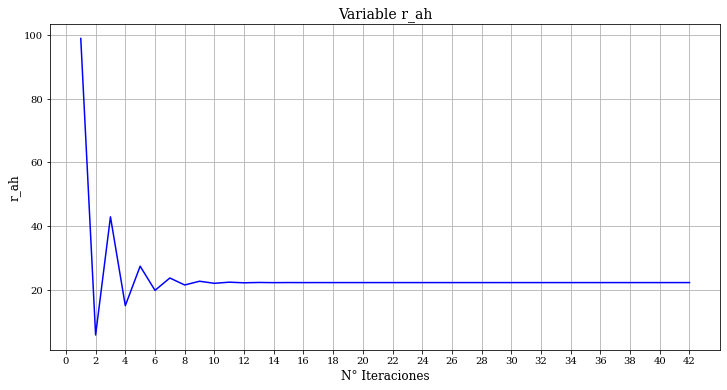

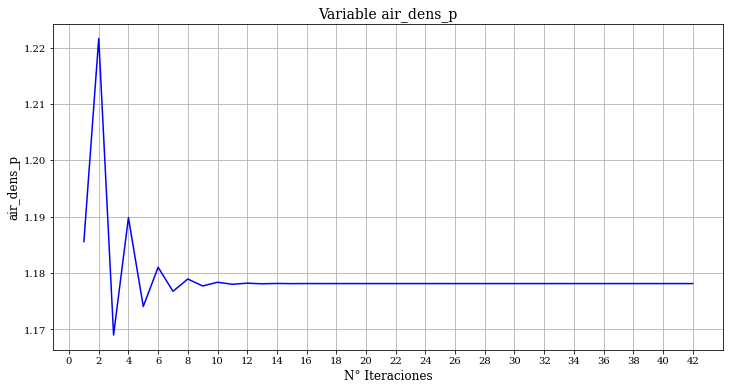

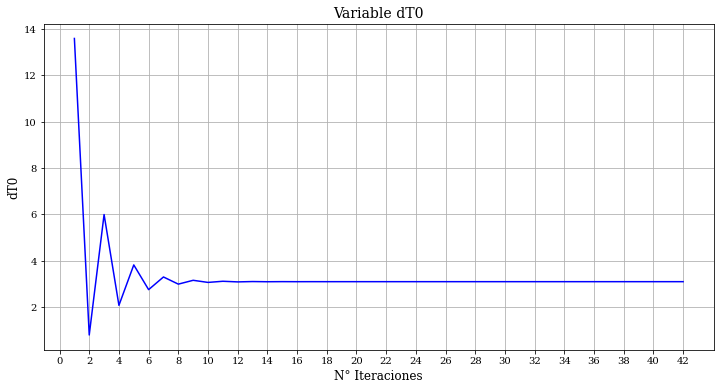

In [18]:
# Pixel frío
fecha = '2022-03-10'

resultados = resultados_pix_c_dict
color_l = 'blue' # 'darkred', 'blue'
pixel = 'Frío' # 'Frío', 'Caliente'
title_name = f'Pixel {pixel}'
print(title_name)

for variables in resultados.keys():

    variable = variables

    plt.figure(figsize=(12,6)) # Ojo con plt.figure(1, figsize=(12,6))
    
    # Estilos
    plt.title(f'Variable {variable}', fontsize='14')#, color='darkred')
    plt.xlabel('N° Iteraciones', fontsize='12')
    plt.ylabel(variable, fontsize='12')
    plt.grid()
    
    # Gráfica
    valores = [i for i in range (1, fin_iteraciones+2+1)]
    plt.xticks(np.arange(0, fin_iteraciones+2+1, step=2))
    plt.plot(valores, resultados[variable], color=color_l)
    
    # Guardar gráfica
#     ruta = 'images/parte_iterativa/'
#     nombre_img = f'{fecha}-{title_name}_{variable}.jpg'
#     plt.savefig(ruta + nombre_img)
    ;

Pixel Caliente


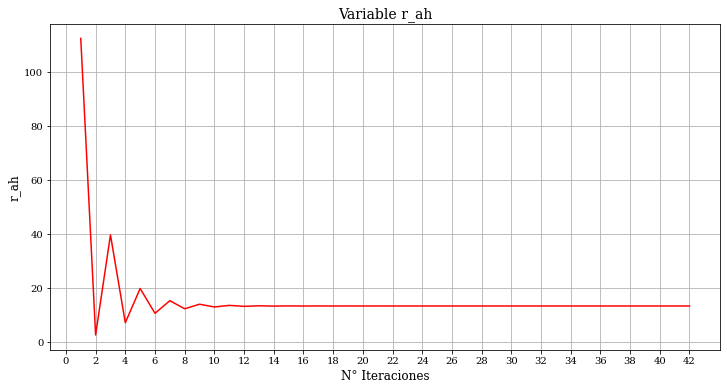

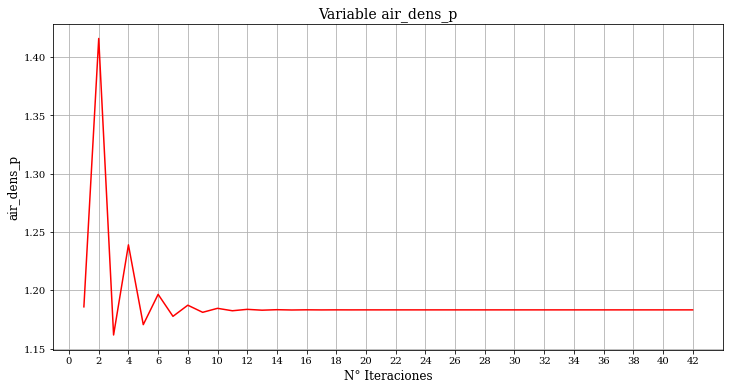

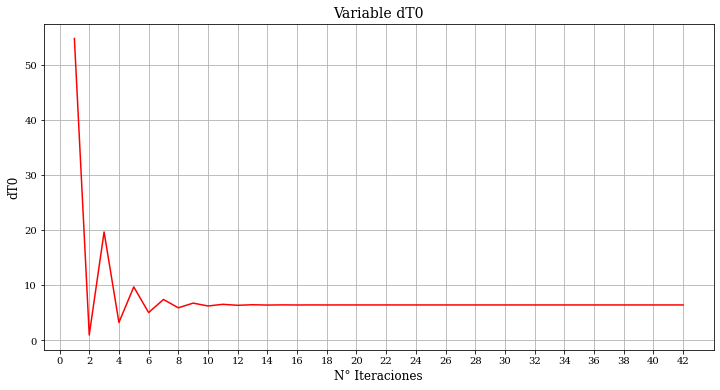

In [19]:
# Pixel Caliente

fecha = '2022-03-10'

resultados = resultados_pix_h_dict
color_l = 'red' # 'darkred', 'blue'
pixel = 'Caliente' # 'Frío', 'Caliente'
title_name = f'Pixel {pixel}'
print(title_name)

for variables in resultados.keys():

    variable = variables

    plt.figure(figsize=(12,6)) # Ojo con plt.figure(1, figsize=(12,6))
    
    # Estilos
    plt.title(f'Variable {variable}', fontsize='14')#, color='darkred')
    plt.xlabel('N° Iteraciones', fontsize='12')
    plt.ylabel(variable, fontsize='12')
    plt.grid()
    
    # Gráfica
    valores = [i for i in range (1, fin_iteraciones+3)]
    plt.xticks(np.arange(0, fin_iteraciones+3, step=2))
    plt.plot(valores, resultados[variable], color=color_l)
    
    # Guardar gráfica
#     ruta = 'images/parte_iterativa/'
#     nombre_img = f'{fecha}-{title_name}_{variable}.jpg'
#     plt.savefig(ruta + nombre_img)
    ;

**Coeficientes a y b**

a_coef:  1.5712909279958112
b_coef:  -36.55479960326469


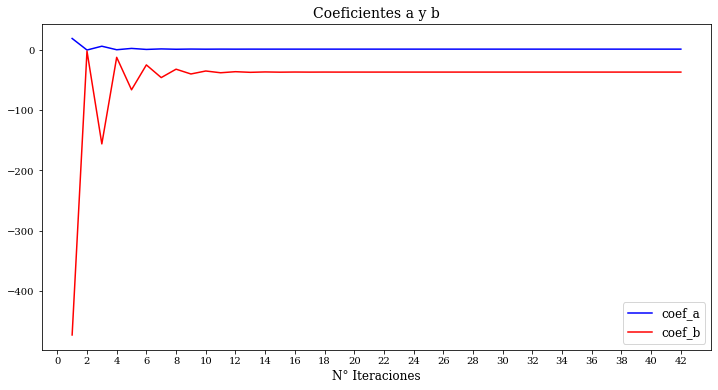

In [29]:
coef_a = resultados_coef[0] 
coef_b = resultados_coef[1]

# resultados.keys()
print('a_coef: ', coef_a[-1])
print('b_coef: ', coef_b[-1])

plt.figure(figsize=(12,6)) # Ojo con plt.figure(1, figsize=(12,6))
valores = [i for i in range (1, fin_iteraciones+3)]

plt.title(f'Coeficientes a y b', fontsize='14')

# plt.title(f'Variable {variable}', fontsize='14')#, color='darkred')
plt.xlabel('N° Iteraciones', fontsize='12')
# plt.ylabel(variable, fontsize='12')

plt.xticks(np.arange(0, fin_iteraciones+3, step=2))
plt.plot(valores, coef_a, label='coef_a', color='blue')
plt.plot(valores, coef_b, label='coef_b', color='red')

plt.legend(fontsize='12');

**Comparativa de resultados entre ambos tipos de pixeles Frío y Caliente**

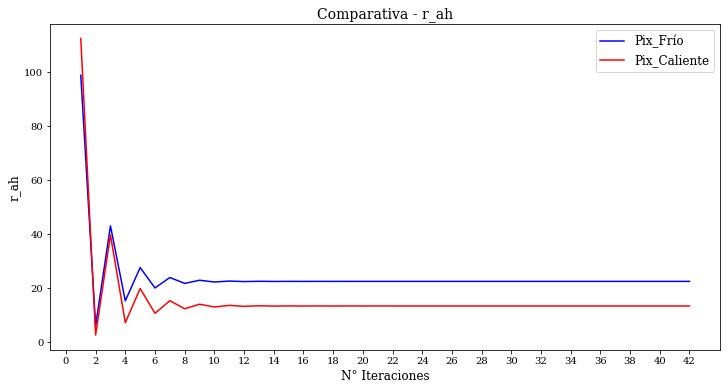

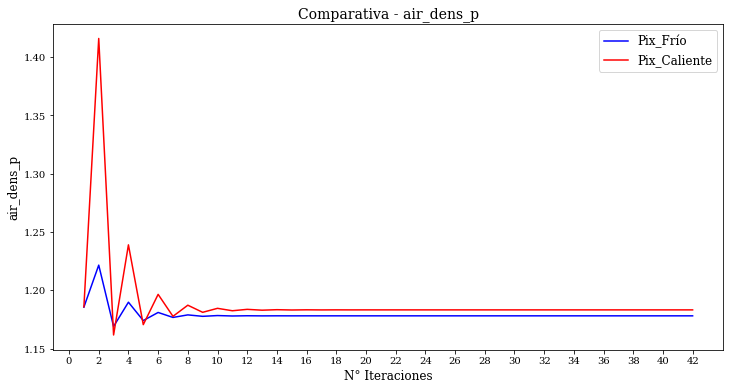

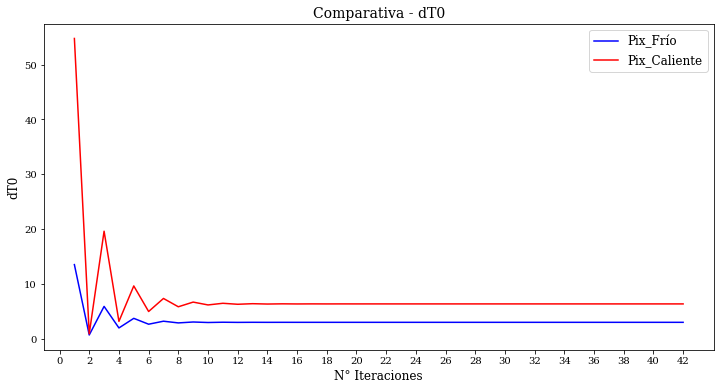

In [20]:
for variable in ['r_ah', 'air_dens_p', 'dT0']:
    
    plt.figure(figsize=(12,6)) # Ojo con plt.figure(1, figsize=(12,6))
    valores = [i for i in range (1, fin_iteraciones+3)]

    plt.title(f'Comparativa - {variable}', fontsize='14')

    # plt.title(f'Variable {variable}', fontsize='14')#, color='darkred')
    plt.xlabel('N° Iteraciones', fontsize='12')
    plt.ylabel(variable, fontsize='12')

    plt.xticks(np.arange(0, fin_iteraciones+3, step=2))
    plt.plot(valores, resultados_pix_c_dict[variable], label='Pix_Frío', color='blue')
    plt.plot(valores, resultados_pix_h_dict[variable], label='Pix_Caliente', color='red')

    plt.legend(fontsize='12');

###### Evaluación de fecha 2022-06-14

In [52]:
# 2022-06-14
filtrado_ws = 1.6  # km/h
filtrado_et = 0.46  # mm/h

In [53]:
# Ingresar aquí los valores de cada pixel seleccionado para esta fecha

pix_c_values = {
    'Albedo': 0.18027162954042425,
    'Elev_m': 45,
    'G': 52.368545441846976,
    'LAI': 0.5995532712843418,
    'NDVI': 0.535677137507801,
    'R_n': 459.59391174654314,
    'SAVI': 0.3480963199786044,
    'Slope_d': 2.084105344420737,
    'T_sw': 0.6590985260789601,
    'Ts': 297.29233075457586,
    'e_0': 0.9559955327128433
}

pix_h_values = {
    'Albedo': 0.09296234559946691,
    'Elev_m': 45,
    'G': 72.39619576236872,
    'LAI': -0.09892950797142068,
    'NDVI': 0.104389721627409,
    'R_n': 504.7681848956557,
    'SAVI': 0.04442048314401466,
    'Slope_d': 0,
    'T_sw': 0.6592205310499065,
    'Ts': 305.1116416083681,
    'e_0': 0.9490107049202857
}

display('pixel frío', pix_c_values) # Pixel frío seleccionado
display('pixel caliente', pix_h_values) # Pixel caliente seleccionado

'pixel frío'

{'Albedo': 0.18027162954042425,
 'Elev_m': 45,
 'G': 52.368545441846976,
 'LAI': 0.5995532712843418,
 'NDVI': 0.535677137507801,
 'R_n': 459.59391174654314,
 'SAVI': 0.3480963199786044,
 'Slope_d': 2.084105344420737,
 'T_sw': 0.6590985260789601,
 'Ts': 297.29233075457586,
 'e_0': 0.9559955327128433}

'pixel caliente'

{'Albedo': 0.09296234559946691,
 'Elev_m': 45,
 'G': 72.39619576236872,
 'LAI': -0.09892950797142068,
 'NDVI': 0.104389721627409,
 'R_n': 504.7681848956557,
 'SAVI': 0.04442048314401466,
 'Slope_d': 0,
 'T_sw': 0.6592205310499065,
 'Ts': 305.1116416083681,
 'e_0': 0.9490107049202857}

In [54]:
# Establecer listas de inicio
resultados_pix_f = [[], [], []]
resultados_pix_c = [[], [], []]
variables = ['r_ah', 'air_dens_p', 'dT0']

resultados_coef = [[], []]
variables_coef = ['a_coef', 'b_coef']

# 1er Iteración
pix_c_procesado_inicial = procesado_inicial(pix_c_values, filtrado_ws, filtrado_et, Kc=1.05)
pix_h_procesado_inicial = procesado_inicial(pix_h_values, filtrado_ws, filtrado_et, Kc=0) 

u_200 = pix_c_procesado_inicial['u_200']

resultados_pix_f = guardar_resultados(resultados_pix_f, pix_c_procesado_inicial, variables)
resultados_pix_c = guardar_resultados(resultados_pix_c, pix_h_procesado_inicial, variables)

pix_c_procesado, pix_h_procesado = get_H(pix_c_procesado_inicial, pix_h_procesado_inicial)

resultados_coef = guardar_resultados(resultados_coef, pix_c_procesado, variables_coef)

pix_c_stability_cor = stability_corr(pix_c_procesado)
pix_h_stability_cor = stability_corr(pix_h_procesado)

# 2da iteración
pix_c_iter = iteracion(u_200, pix_c_procesado, pix_c_values, pix_c_stability_cor, pix_c_procesado_inicial['H0'])
pix_h_iter = iteracion(u_200, pix_h_procesado, pix_h_values, pix_h_stability_cor, pix_h_procesado_inicial['H0'])

resultados_pix_f = guardar_resultados(resultados_pix_f, pix_c_iter, variables)
resultados_pix_c = guardar_resultados(resultados_pix_c, pix_h_iter, variables)

pix_c_post_iter, pix_h_post_iter = get_H(pix_c_iter, pix_h_iter)

resultados_coef = guardar_resultados(resultados_coef, pix_c_post_iter, variables_coef)

pix_c_stability_cor = stability_corr(pix_c_post_iter)
pix_h_stability_cor = stability_corr(pix_h_post_iter)

# Proceso Iterativo (es necesario realizar una iteracion para luego utilizar el bucle while)
x = 0
fin_iteraciones = 40

while x < fin_iteraciones:
    
    pix_c_iter = iteracion(u_200, pix_c_post_iter, pix_c_values, pix_c_stability_cor, pix_c_procesado_inicial['H0'])
    pix_h_iter = iteracion(u_200, pix_h_post_iter, pix_h_values, pix_h_stability_cor, pix_h_procesado_inicial['H0'])
    
    resultados_pix_f = guardar_resultados(resultados_pix_f, pix_c_iter, variables)
    resultados_pix_c = guardar_resultados(resultados_pix_c, pix_h_iter, variables)
    
    pix_c_post_iter, pix_h_post_iter = get_H(pix_c_iter, pix_h_iter)
    
    resultados_coef = guardar_resultados(resultados_coef, pix_c_post_iter, variables_coef)

    pix_c_stability_cor = stability_corr(pix_c_post_iter)
    pix_h_stability_cor = stability_corr(pix_h_post_iter)
    
    x+=1

print(f'{x} iteraciones realizadas!')

40 iteraciones realizadas!


In [55]:
# Elaborando los diccionarios para ploteo
resultados_pix_c_dict = {}
for i in range(3):
    resultados_pix_c_dict[variables[i]] = resultados_pix_f[i]

print(resultados_pix_c_dict.keys())

resultados_pix_h_dict = {}
for i in range(3):
    resultados_pix_h_dict[variables[i]] = resultados_pix_c[i]
    
print(resultados_pix_h_dict.keys())

dict_keys(['r_ah', 'air_dens_p', 'dT0'])
dict_keys(['r_ah', 'air_dens_p', 'dT0'])


In [56]:
# ruta = 'images/parte_iterativa/'
# os.mkdir(ruta)
os.listdir('images/parte_iterativa/')

['2022-03-10-Pixel Caliente_air_dens_p.jpg',
 '2022-03-10-Pixel Caliente_dT0.jpg',
 '2022-03-10-Pixel Caliente_r_ah.jpg',
 '2022-03-10-Pixel Frío_air_dens_p.jpg',
 '2022-03-10-Pixel Frío_dT0.jpg',
 '2022-03-10-Pixel Frío_r_ah.jpg']

Pixel Frío


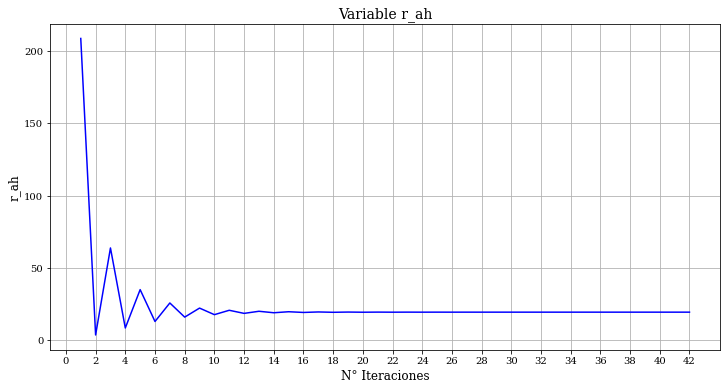

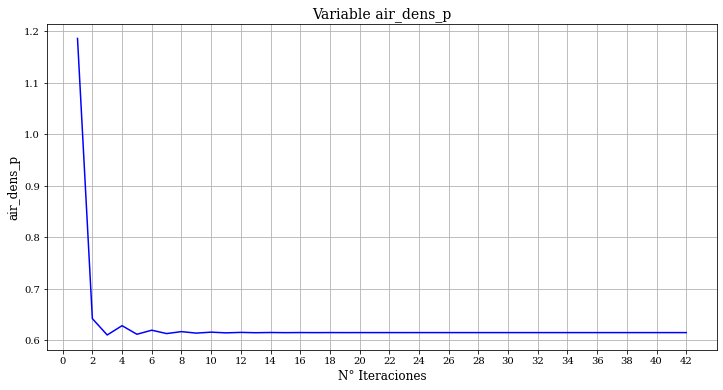

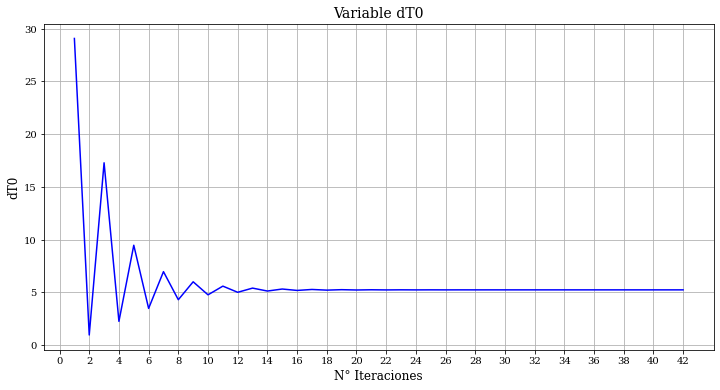

In [57]:
# Pixel frío
fecha = '2022-06-14'

resultados = resultados_pix_c_dict
color_l = 'blue' # 'darkred', 'blue'
pixel = 'Frío' # 'Frío', 'Caliente'
title_name = f'Pixel {pixel}'
print(title_name)

for variables in resultados.keys():

    variable = variables

    plt.figure(figsize=(12,6)) # Ojo con plt.figure(1, figsize=(12,6))
    
    # Estilos
    plt.title(f'Variable {variable}', fontsize='14')#, color='darkred')
    plt.xlabel('N° Iteraciones', fontsize='12')
    plt.ylabel(variable, fontsize='12')
    plt.grid()
    
    # Gráfica
    valores = [i for i in range (1, fin_iteraciones+2+1)]
    plt.xticks(np.arange(0, fin_iteraciones+2+1, step=2))
    plt.plot(valores, resultados[variable], color=color_l)
    
    # Guardar gráfica
#     ruta = 'images/parte_iterativa/'
#     nombre_img = f'{fecha}-{title_name}_{variable}.jpg'
#     plt.savefig(ruta + nombre_img)
    ;

Pixel Caliente


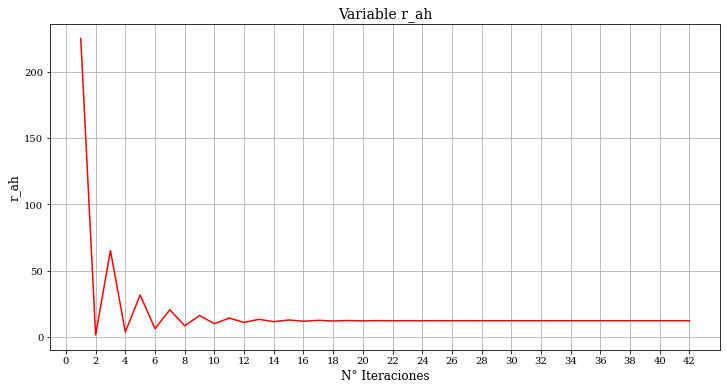

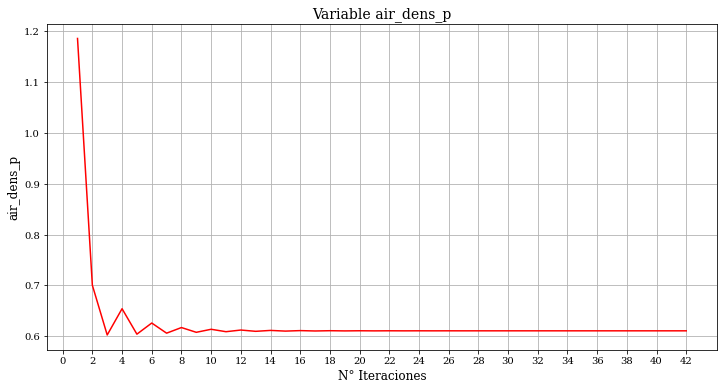

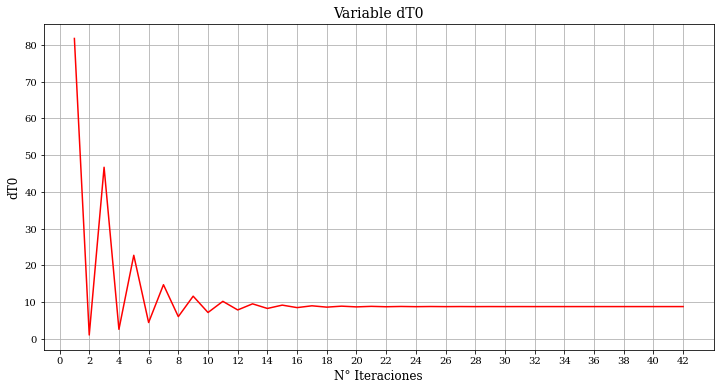

In [58]:
# Pixel Caliente

fecha = '2022-03-10'

resultados = resultados_pix_h_dict
color_l = 'red' # 'darkred', 'blue'
pixel = 'Caliente' # 'Frío', 'Caliente'
title_name = f'Pixel {pixel}'
print(title_name)

for variables in resultados.keys():

    variable = variables

    plt.figure(figsize=(12,6)) # Ojo con plt.figure(1, figsize=(12,6))
    
    # Estilos
    plt.title(f'Variable {variable}', fontsize='14')#, color='darkred')
    plt.xlabel('N° Iteraciones', fontsize='12')
    plt.ylabel(variable, fontsize='12')
    plt.grid()
    
    # Gráfica
    valores = [i for i in range (1, fin_iteraciones+3)]
    plt.xticks(np.arange(0, fin_iteraciones+3, step=2))
    plt.plot(valores, resultados[variable], color=color_l)
    
    # Guardar gráfica
#     ruta = 'images/parte_iterativa/'
#     nombre_img = f'{fecha}-{title_name}_{variable}.jpg'
#     plt.savefig(ruta + nombre_img)
    ;

###### Longitud de la rugosidad que gobierna la transferencia de momentum / Momentum roughness length $z_{om}$ [m]

Measure of the form drag and skin friction for the layer of air that interacts with the surface. 

$$
z_{om} = 0.018 \; \text{LAI} \qquad (33)
$$

In [ ]:
# img_lai.select('LAI').reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

In [ ]:
# Momentum roughness length z_om (m) - Tasumi (2003)
# z_om = img_lai.select('LAI').multiply(0.018).rename('z_om')
# z_om.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

In [ ]:
# @markdown Visualización: LAI y NDVI

# # NDVI > 0 
# img_ndvi_gt0 = img_ndvi.updateMask(img_ndvi.select('NDVI').gt(0)).select('NDVI')

# Map = geemap.Map(height='800px') 
# Map.centerObject(roi, 11)

# # Map.addLayer(img_sr_tasumi, {'bands': ['B4_SR', 'B3_SR', 'B2_SR'], 'max': 0.3, 'min': 0.0}, 'RGB SR') 

# Map.addLayer(img_toa, vis_rgb, 'img_toa')
# Map.addLayer(img_lai.select('LAI'), vis_ndvi, 'img_lai')
# Map.addLayer(img_ndvi.select('NDVI'), vis_ndvi, 'img_ndvi')
# Map.addLayer(img_ndvi_gt0, vis_ndvi, 'img_ndvi_gt0')

# Map.addLayer(empty, {}, 'Chongoyape')
# Map.addLayer(empty2, {}, 'Chongoyape_caja')

# Map

###### Velocidad de viento a la altura w $u_w$ $[\text{m s}^{-1}]$ 

Datos de estación Vista Florida 2021-2022. Inicio: `1/10/2021`

In [ ]:
# 8 Imágenes seleccionadas
# ids = [
#     'LANDSAT/LC09/C02/T1/LC09_010065_20211212', # 0 - 12/12 - l9
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220113', # 1 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220129', # 2 - 01/29 - l9
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220310', # 3 - 03/10 - l8
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220403', # 4 - 04/03 - l9
#     'LANDSAT/LC09/C02/T1/LC09_010065_20220521', # 5 - 05/21 - l9
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220529', # 6 - 05/29 - l8
#     'LANDSAT/LC08/C02/T1/LC08_010065_20220614'  # 7 - 06/14 - l8
#       ]

fechas_imgs = []

for img_id in ids:
    img_ee = ee.Image(img_id)
    img_date = img_ee.date().format('YYYY-MM-dd').getInfo()
    fechas_imgs.append(img_date)

# fechas_imgs = '2021-12-12',
#  '2022-01-13',
#  '2022-01-29',
#  '2022-03-10',
#  '2022-04-03',
#  '2022-05-21',
#  '2022-05-29',
#  '2022-06-14']

In [ ]:
ruta_csv = 'EE_Vista_Florida.csv'
df_estacion_vf = pd.read_csv(ruta_csv, na_values='---') 
df_estacion_vf.Date = pd.to_datetime(df_estacion_vf.Date, format='%d/%m/%Y')
# df_estacion_vf

# Cambio de formato en columna Time de object a numeric (para visualizar mejor con matplotlib)
df_prueba = df_estacion_vf.copy()
df_prueba['Time'] = pd.to_numeric(df_prueba['Time'].str.replace(":", "."))

# Extraemos los datos de la estación para las fechas de existencia de imagen satelital
datos_hora_imagen = df_prueba[df_prueba['Date'].isin(fechas_imgs)]
# datos_hora_imagen

# Visualizamos y comparamos los dataframes según la hora de filtrado
display(datos_hora_imagen[datos_hora_imagen['Time']==10.30])
display(datos_hora_imagen[datos_hora_imagen['Time']==11.00])

In [ ]:
fecha = img_date
hora = 10.30

print(fecha)
filtrado = datos_hora_imagen[(datos_hora_imagen['Date']==fecha) & (datos_hora_imagen['Time']==hora)]
filtrado

In [ ]:
datos_hora_imagen[(datos_hora_imagen['Date']==fecha) & (datos_hora_imagen['Time']>=10)].head(13)

In [ ]:
filtrado_ws = (
    datos_hora_imagen[(datos_hora_imagen['Date'] == img_date) & (datos_hora_imagen['Time']==10.30)]['Wind Speed']
    .values[0]
)

print(filtrado_ws) # [km/h]

filtrado_et = (
    datos_hora_imagen[(datos_hora_imagen['Date'] == img_date) & (datos_hora_imagen['Time']==11)]['ET']
    .values[0]
)
print(filtrado_et)

###### Código pasado: Lectura de archivo .csv y visualización con plotly

In [ ]:
# @markdown Generar reporte de velocidad de viento

# # Lectura de datos de la estación meteorológica Tinajones
ruta_csv = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/Tinajones_datos_met_2021.csv'

# df_tinajones = pd.read_csv(ruta_csv, na_values='S/D')
df_tinajones.FECHA = pd.to_datetime(df_tinajones.FECHA, format='%d/%m/%Y')

vel_viento_15hr = df_tinajones[df_tinajones['HORA']=='15:00']

# # Lectura de datos del reporte de imágenes satelitales generado con Earth Engine
ruta_reportel8 = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/reporteL8_RAW_2021.csv'

# df_reportel8 = pd.read_csv(ruta_reportel8)
fechas_reportel8 = df_reportel8['Fecha Corta'].tolist()

vel_viento_15hr = vel_viento_15hr[vel_viento_15hr['FECHA'].isin(fechas_reportel8)]
vel_viento_15hr

In [ ]:
vel_viento_ruta = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/vel_viento_15hr.csv'
vel_viento_15hr = pd.read_csv(vel_viento_ruta)
vel_viento_15hr

In [ ]:
# @markdown Visualización de datos de velocidad de viento [m/s]
plt.figure(figsize=(15,6))

# Eje Y izquierdo
plt.plot(vel_viento_15hr['FECHA'].apply(pd.to_datetime), 
         vel_viento_15hr['VELOCIDAD DEL VIENTO (m/s)'], 
         'd-')

plt.title('Velocidad del viento 15:00 hrs'), 
plt.ylabel('VELOCIDAD DEL VIENTO [m/s]')

# Eje X : Fechas
fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

plt.grid();

In [ ]:
import plotly.graph_objects as go

# @markdown Gráfica con Plotly: Sentinel-2, Landsat 8 y Landsat 9

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=vel_viento_15hr['FECHA'].apply(pd.to_datetime), 
               y=vel_viento_15hr['VELOCIDAD DEL VIENTO (m/s)'],
               name='Sentinel-2', 
              #  marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y:.2f} m/s',
               line = dict(width=2)#, dash='dot')
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = 'Velocidad del viento 15:00 hrs - Estación Tinajones'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x unified",
    title = title_plotly,
    # yaxis_range = [0,100],
    # xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)] 
    margin=dict(t=75, b=25, l=0, r=0),
    legend=dict(x=0.3, y=1.10),
    legend_orientation='h',
    # https://plotly.com/python/reference/layout/#layout-legend-orientation
    )

# Nombres en ejes
fig.update_yaxes(title_text='VELOCIDAD DEL VIENTO [m/s]',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()
# fig.write_html("prueba_plotly.html")

###### Wind speed at an assumed blending height (200 m) above the weather station $u_{200}$ [m s-1]

Is calculated as

$$
u_{200} = \frac{ u_w \ln{(200/z_{omw})} }{ \ln{(z_x/z_{omw})} } \qquad (32)
$$

Where:
- $u_w$ : wind speed measured at a weather station at $z_x$ height above the surface
- $z_{omw}$ : the roughness length for the weather station surface, similar to Allen and Wright (1997).

All units for $z$ are the same. The value for $u_{200}$ is assumed constant for the satellite image. This asumption allows for the use of a constant relation between *dT* and $T_s$.

In [ ]:
# Velocidad del viento medido por estación meteorológica a las 10:30 [m/s]
u_w = filtrado_ws*10/36 # filtrado_ws en km/hr -> m/s

z_omw = 0.12*0.15  # z_omw = 0.12*h donde h es la altura del grass de la estación met (relativo a cada estación)
z_x = 2.5          # altura del equipo que mide la velocidad del viento, varía de 2 a 2.80m (relativo a cada estación)

u_200 = u_w*math.log(200/z_omw)/math.log(z_x/z_omw)
u_200 # (m/s)

###### Friction velocity $u*$ [m s-1]

is computed during the first iteration using **the logarithmic wind law for neutral atmospheric conditions**

$$
u* = \frac{ k \; u_{200} }{ \ln{(200/z_{om})} } \; \; \; \; \qquad (31)
$$

Where:
- $u_{200}$ : wind speed (m s-1) at a blending height assumed to be 200 m, and
- $z_{om}$ : momentum roughness length (m). $z_{om}$ is a measure of the form drag and skin friction for the layer of air that interacts with the surface.
- $k$ : von Karman's constant **(0.41)**. 

$u*$ is computed for each pixel inside the process model **using a specific roughness length for each pixel**, but with $u_{200}$ assumed to be constant over all pixels of the image since it is defined as occuring at a "blending height" unaffected by surface features. Eqs. (30) and (31) support the use of a temperature gradient defined between two heights that are both above the surface. This allows one to estimate $r_{\text{ah}}$ without having to estimate a second aerodynamic roughness for sensible heat transfer ($z_{oh}$), since height $z_1$ is defined to be at an elevation above $z_{oh}$. This is an advantage because $z_{oh}$ can be difficult to estimate for sparse vegetation.

Más info:
- [Log wind profile](https://en.wikipedia.org/wiki/Log_wind_profile#cite_note-1): The log wind profile is a semi-empirical relationship commonly used to describe the vertical distribution of horizontal mean wind speeds within the lowest portion of the planetary boundary layer.
- [Friction velocity - Shear velocity](https://en.wikipedia.org/wiki/Shear_velocity)
- [Roughness length $(z_0)$](https://en.wikipedia.org/wiki/Roughness_length): Is a corrective measure to account for the effect of the roughness of a surface on wind flow. That is, the value of the roughness length depends on the terrain.

In [ ]:
# u*1
k_const = 0.41
u_star = k_const*u_200/(math.log(200/z_omw))
u_star

###### Aerodynamic resistance $r_{ah}$ [s m-1] between two near surface heights $z_1$ and $z_2$

The value for $r_{\text{ah}}$ is **strongly influenced by** the buoyancy within the boundary layer **driven by** the rate of sensible heat flux. Because both $r_{\text{ah}}$ and $H$ are unknown at each pixel, an iterative solution is required. 

During the first iteration, $r_{\text{ah}}$ is computed assuming neutral stability

$$
r_{\text{ah}} = \frac{\ln{(z_2/z_1)}}{{u*} \; k} \; \; \; \; \qquad (30)
$$

### $\lambda{ET}$ y $ET$ instantánea

Energía latente consumida por la evapotranspiración $LE \; (W m^{-2})$

$$
LE = R_n - G - H
$$

Evapotranspiración instantánea al momento de toma de imagen.

$$
ET_{inst} = 3,600 \frac{LE}{\lambda \; \rho_w} 
$$

Calor latente de vaporización $\lambda \; (J kg^{-1})$ 

$$
\lambda = [2.501 - 0.00236 \; ( T_s - 273.15)] \times 10^6
$$






Fracción de evapotranspiración de referencia $ET_rF$

> $ET_rF$ is the same as the well-known crop coefficient, $K_c$. When used with an alfalfa reference basis, and is used to extrapolate ET from the image time to periods of 24 h or longer.

$$
ET_rF = \frac{ET_{inst}}{ET_r}
$$

### Evapotranspiración de cultivo $ET_c$ por día

> In the METRIC process, $ET_{24}$ is estimated by assuming that the instantaneous $ET_rF$ computed at image time is the same as the average $ET_rF$ over the 24 h average. 

## Pruebas

###### Prueba while loop para sección iterativa (Flujo del calor sensible del aire H)

In [25]:
# # Prueba while loop
# lista_prueba = []
# x = 0

# while x < 10:
    
#     lista_prueba.append(x)
#     print(lista_prueba)
#     x+=1
    
# lista_prueba

[0]
[0, 1]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

###### Inputs

In [ ]:
img_prod_stats

In [ ]:
# Diccionarios para visualización
vis_params_ts_c = {'min': float(img_prod_stats['Ts_c']['min']), 
                   'max': float(img_prod_stats['Ts_c']['max']), 
                   'palette': cmp.get_palette('RdYlBu_r')}

vis_params_ndvi = {'min': img_prod_stats['NDVI']['min'], 
                   'max': img_prod_stats['NDVI']['max'], 
                   'palette': cmp.get_palette('ndvi')}

vis_params_alb = {'min': img_prod_stats['albedo']['min'], 
                  'max': img_prod_stats['albedo']['max'], 
                  'palette': cmp.get_palette('RdYlGn_r')}

vis_params_lai = {'min': img_prod_stats['LAI']['min'], 
                  'max': img_prod_stats['LAI']['max'], 
                  'palette': cmp.get_palette('RdYlGn')}

In [ ]:
Map.addLayer(img_ndvi.clip(predios_agricolas), vis_params_ndvi,'NDVI')
Map.addLayer(img_albedo.clip(predios_agricolas), vis_params_alb, 'Albedo')
Map.addLayer(img_lai.clip(predios_agricolas), vis_params_lai, 'LAI')

In [ ]:
img_s2_01_26 = ee.Image('COPERNICUS/S2_SR/20220126T153619_20220126T153649_T17MPN').multiply(0.0001).clip(predios_bound)
img_s2_01_31 = ee.Image('COPERNICUS/S2_SR/20220131T153621_20220131T153814_T17MPN').multiply(0.0001).clip(predios_bound)
img_s2_01_11 = ee.Image('COPERNICUS/S2_SR/20220111T153621_20220111T154058_T17MPN').multiply(0.0001).clip(predios_bound)

In [ ]:
Map = geemap.Map()#layer_ctrl=True)#, height='800px') 

Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'Img TOA')
Map.addLayer(img_s2_01_11, vis_rgb, 'Img S2')

Map.addLayer(img_Ts_c.updateMask(img_albedo.lte(0.22).And(img_albedo.gt(0.15))).clip(predios_agricolas), 
             vis_params_ts_c,  'Ts °C')
Map.add_colorbar(vis_params_ts_c, label='Ts [°C]', orientation="vertical")

Map

Los valores típicos de albedo para arroz se encuentran en el manual SEBAL 2002.

Arroz: 0.17 - 0.22

###### Pruebas: selección de imágenes 

Pasos para trabajar imágenes:
1. Tener en claro las fechas e ids de las imágenes
2. Armar la tabla con valores de Evapotranspiración (mm/hr) y Velocidad del viento (m/s)

In [ ]:
# 8 Imágenes seleccionadas
ids = [
    'LANDSAT/LC09/C02/T1/LC09_010065_20211212', # 0 - 12/12 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220113', # 1 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
    'LANDSAT/LC09/C02/T1/LC09_010065_20220129', # 2 - 01/29 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220310', # 3 - 03/10 - l8
    'LANDSAT/LC09/C02/T1/LC09_010065_20220403', # 4 - 04/03 - l9
    'LANDSAT/LC09/C02/T1/LC09_010065_20220521', # 5 - 05/21 - l9
    'LANDSAT/LC08/C02/T1/LC08_010065_20220529', # 6 - 05/29 - l8
    'LANDSAT/LC08/C02/T1/LC08_010065_20220614'  # 7 - 06/14 - l8
      ]

In [ ]:
# Reporte de imágenes seleccionadas
ruta_reporte_vf = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/csv/reporte_l8_l9_estacion_vf.csv'
df_reportel8_vf = pd.read_csv(ruta_reporte_vf)

df_reportel8_vf.head(8)

Se trabajará con la imagen 1/29 para comenzar

In [ ]:
# img_1_13 = ids[1]
img_1_29 = ids[2]

img_1_13_et = df_reportel8_vf['ET - mm'][7]
img_1_13_vel = df_reportel8_vf['Velocidad del viento - m/s'][7]

###### Prueba de filtrado 1

In [ ]:
img_productos_df

In [ ]:
vis_params_alb = {
    'min': 0,
    'max': 0.25,
    'palette':albedo_cmap #cmp.get_palette('afmhot'), albedo_cmap, rn_cmp
}

vis_params_ndvi = {'min': -0.2, 
                   'max': 1, # img_prod_stats['max']['NDVI'], 
                   'palette': ndvi_cmap} #cmp.get_palette('ndvi')}

In [ ]:
# help(geemap.Map.add_colorbar)

In [ ]:
img_albedo_recorte = img_albedo.updateMask(img_albedo.gte(0.17).And(img_albedo.lt(0.22)))

In [ ]:
# Visualización
# vis_params_pix = {
#     'min': pixeles_frios_minmax[0],
#     'max': pixeles_frios_minmax[1],
#     'palette': cmp.get_palette('binary_r') # RdYlBu_r, binary_r # Color negro el pixel más frío
# }

image = pixeles_frios
vis_params = vis_params_pix
title_map = 'pixeles_frios'
label = '$[\; °C\;]$'

# Elaborando visualización interactiva
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)

Map.addLayer(img_toa.blend(predios_vis), vis_rgb, f'Landsat {img_date}')
# Map.addLayer(img_s2_vis.blend(predios_vis), vis_rgb, f'Sentinel {img_s2_date}')

Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
Map.addLayer(img_Ts_c, vis_params_ts, 'img_Ts_c')
Map.addLayer(img_albedo, vis_params_alb, 'img_albedo')
Map.addLayer(img_albedo_recorte, vis_params_alb, 'img_albedo_recorte')

Map.addLayer(image, vis_params, title_map) # Pixeles
Map.add_colorbar(vis_params, label="Ts [°C]", orientation="horizontal")
Map.add_colorbar(vis_params_alb, label="Albedo [-]", orientation="horizontal")
# Resultado
Map

In [ ]:
# Con la función `get_pixel_values` obtendremos principalmente los valores de Rn y G
# Dejamos un marcador en el pixel que deseamos extraer la información

pix_cold_n1 = n1 
pix_cold_n2 = n2

pix_cold = Map.user_rois.geometry()
pix_coord = pix_cold.coordinates().getInfo()

pix_cold_values = get_pixel_values(pix_cold, pixeles_frios, d2, img_productos)

# Reporte
print(f'Fecha: {img_date}')
print(f'Pixel Frío: {pix_coord}')
print(f'n1: {pix_cold_n1} \nn2: {pix_cold_n2}')
print('pixel_cold_values:')

pix_cold_values['fecha'] = img_date
pprint(pix_cold_values)

In [ ]:
pix_cold_values['fecha'] = img_date

In [ ]:
pixel2 = pix_cold_values

In [ ]:
pixel2

In [ ]:
pixel1

In [ ]:
pix_cold_values['n1'] = n1
pix_cold_values['n2'] = n2

In [ ]:
pix_cold_values = get_pixel_values(pix_cold, pixeles_frios, d2, img_productos)

reporte = pd.DataFrame.from_dict(pix_cold_values, orient='index').round(3)
reporte

In [ ]:
pprint(pix_cold_values)

---

Fecha: 
- '2022-01-13'
    - n1: 90 - n2: 10
    - Pixel Frío: [-79.785274, -6.598119]
    - Rn: 630.93881 W/m²
    - G : 86.01880 W/m²
   
- '2022-03-10'
    - n1: 70 - n2: 20
    - Pixel Frío: [-79.784184, -6.599424]
    - Rn: 569.16318 W/m²
    - G : 50.40656 W/m²
    
-----

###### Prueba de filtrado 2

In [ ]:
img_productos_df[['Ts_c', 'NDVI']]

In [ ]:
pixeles_dict = get_stats(pixeles_frios, predios_agricolas, 30)
pixeles_df = pd.DataFrame.from_dict(pixeles_dict, orient='index')
pixeles_df # .round(2)

In [ ]:
pixeles_df.round(2)

In [ ]:
# Percentiles Temperatura Superficial
perc_n2 = (
    img_Ts_c
    .reduceRegion(ee.Reducer.percentile([5,10,15,20]).unweighted(), geometry=predios_agricolas, scale=30)
)#.values()
perc_n2.getInfo()

In [ ]:
# Percentiles NDVI
perc_n1 = (
    img_ndvi
    .reduceRegion(ee.Reducer.percentile([80,85,90,95]).unweighted(), geometry=predios_agricolas, scale=30)
)#.values()
perc_n1.getInfo()

In [ ]:
img_ts_c_masked = img_Ts_c.updateMask(
    img_ndvi.gt(ee.Number(perc_n1.get('NDVI_p80'))).And(
        img_Ts_c.lt(ee.Number(perc_n2.get('Ts_c_p20')))
))

img_ts_c_masked_rangos = img_ts_c_masked.reduceRegion(ee.Reducer.minMax(), predios_agricolas, 30).values().reverse().getInfo()
img_ts_c_masked_rangos

In [ ]:
img_ndvi_masked = img_ndvi.updateMask(img_ndvi.gt(ee.Number(perc_n1.get('NDVI_p80'))))
img_ndvi_masked_rangos = img_ndvi_masked.reduceRegion(ee.Reducer.minMax(), predios_agricolas, 30).values().reverse().getInfo()
img_ndvi_masked_rangos

In [ ]:
# Visualización - Selección de Pixel Frío
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16) 

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'img_toa')

# vis_params_ts_c = {
#     'min': img_prod_stats['min']['Ts_c'],
#     'max': img_prod_stats['max']['Ts_c'],
#     'palette': cmp.get_palette('binary_r') # binary_r, RdYlBu_r
#     }

vis_params_ts_c_masked = {
    'min': img_ts_c_masked_rangos[0],
    'max': img_ts_c_masked_rangos[1],
    'palette': cmp.get_palette('binary_r') # binary_r, RdYlBu_r
    }

# Map.addLayer(img_Ts_c, vis_params_ts_c, 'img_Ts_c')
Map.addLayer(img_ts_c_masked, vis_params_ts_c_masked, 'img_ts_c_masked')
# Map.add_colorbar(vis_params_ts_c, label='Ts [°C]', orientation="vertical") # position='bottomright'
Map.add_colorbar(vis_params_ts_c_masked, label='[°C]', orientation="vertical") # position='bottomright'

Map

In [ ]:
# Visualización - Selección de Pixel Frío
Map = geemap.Map()#layer_ctrl=True)#, height='700px') 
Map.centerObject(predios_agricolas, 16) # Toma mas tiempo

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'img_toa')

vis_params_ts_recorte = {
    'min': ts_recortado_p_n1_minmax.get(0).getInfo(),
    'max': ts_recortado_p_n1_minmax.get(1).getInfo(),
    'palette': cmp.get_palette('RdYlBu_r') 
    }

Map.addLayer(ts_recortado_p_n1, vis_params_ts_recorte, 'ts_recortado_p_n1_minmax')

vis_params_ts_pixeles_f = {
    'min': pixeles_frios_minmax.get(0).getInfo(),
    'max': pixeles_frios_minmax.get(1).getInfo(),
    'palette': cmp.get_palette('binary_r') 
    }
Map.addLayer(pixeles_frios, vis_params_ts_pixeles_f, 'pixeles_frios')

Map.add_colorbar(vis_params_ts_recorte, label='Ts [°C]', orientation="vertical") # position='bottomright'
Map.add_colorbar(vis_params_ts_pixeles_f, label='Ts [°C]', orientation="vertical", position='bottomleft') 
 
print('Ahora que vemos la imagen:')
print('1. Asignar un marcador para el pixel')
print('2. Proceder a la siguiente línea de código')

Map

In [ ]:
# Cantidad de pixeles candidatos
print(f"pixeles_frios minmax: {pixeles_frios.reduceRegion(ee.Reducer.minMax(), predios_agricolas, 30).values().reverse().getInfo()}")
print(f"Pixeles: {pixeles_frios.reduceRegion(ee.Reducer.count(), predios_agricolas, 30).get('ts').getInfo()}")

# Listar pixeles candidatos: Temperatura
pixeles_frios.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('ts').getInfo()

###### Prueba de filtrado pixeles calientes

In [ ]:
# # Selección de Pixel Caliente - Recorte de mapas
# n1 =  30 # n1 : Percentil para NDVI
# n2 =  70 # n2 : Percentil para temperatura

# # 1. Pixeles de NDVI menores al n1 (bajos valores de NDVI)
# perc_n1 = ee.Number(
#     img_ndvi.updateMask(img_ndvi.gte(0))
#     .reduceRegion(ee.Reducer.percentile([n1]), geometry=predios_agricolas, scale=30)
#     .values()
# )

# # 2. Recortar mapa de temperatura en función a valores de ndvi que cumplan la condición 1
# ts_recortado_p_n1 = img_Ts_c.updateMask(img_ndvi.lte(perc_n1))


# # 3. n2% de pixeles de mayor temperatura -> p_n2
# perc_n2 = ee.Number(
#     ts_recortado_p_n1
#     .reduceRegion(ee.Reducer.percentile([n2]), scale=30)
#     .values()
# )

# # 4. Recortar mapa de temperatura -> Pixeles Calientes
# pixeles_hot = ts_recortado_p_n1.updateMask(ts_recortado_p_n1.gte(perc_n2))


# # Extraer valores mínimos y máximos
# pixeles_hot_minmax = (
#     pixeles_hot.reduceRegion(ee.Reducer.minMax(), scale=30)
#     .values().reverse().getInfo()
# )# ee.Reducer.count()

# print(f'Tmin - Tmax: {pixeles_hot_minmax}')


# # Visualización
# vis_params_pix = {
#     'min': pixeles_hot_minmax[0],
#     'max': pixeles_hot_minmax[1],
#     'palette': cmp.get_palette('binary') # Color negro el pixel más frío
# }

# vis_params_ndvi = {
#     'min': img_productos_dict['min']['NDVI'],
#     'max': img_productos_dict['max']['NDVI'],
#     'palette':cmp.get_palette('RdYlGn')
# }

# image = pixeles_hot.blend(predios_vis)
# vis_params = vis_params_pix
# title_map = 'Pixeles calientes'
# label = '$[\; °C\;]$'


# # Obtener visualización con geemap.Map
# Map = geemap.Map()
# Map.centerObject(predios_agricolas, 16)

# Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
# # Map.addLayer(img_s2_01_11.clip(predios_bound).blend(predios_vis), vis_rgb, 'img_s2_01_11')

# Map.addLayer(img_Ts_c, vis_params_ts, 'img_Ts_c')
# Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
# Map.addLayer(img_albedo, vis_params_alb, 'img_albedo')

# Map.addLayer(image, vis_params, title_map)
# Map.add_colorbar(vis_params, label="Ts [°C]", orientation="vertical")

# Map

In [ ]:
# Obtener gráfica con cartoee
paleta = 'RdYlBu_r'
# paleta = 'binary_r' # Color negro o rojo el pixel más caliente

vis_params_pix = {
    'min': pixeles_hot_minmax[0],
    'max': pixeles_hot_minmax[1],
    'palette': cmp.get_palette(paleta) 
}

image = pixeles_hot.blend(predios_vis)
vis_params = vis_params_pix
title_map = f'Pix Calientes \n{img_date}\nn1: {n1} - n2: {n2}'
path_fig  = f'/pixeles/Pix_Calientes_{img_date}_n1_{n1}_n2_{n2}_{paleta}'

label = '$[\; °C\;]$'

get_grafica_cartoee_color(image, 
                          vis_params, 
                          title_map, 
                          label,
                          save_fig=path_fig)

-----

In [ ]:
# # Cantidad de pixeles candidatos
# print(f"Pixeles: {pixeles_calientes.reduceRegion(ee.Reducer.count(), predios_agricolas, 30).get('ts').getInfo()}")

# # Listar pixeles candidatos
# pixeles_calientes.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('ts').getInfo()

In [ ]:
# Comprobación - Rn

# punto = pix_cold
# punto = pix_hot

# R_n_reduce_region = R_n.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('R_n') # 366.93772757138004
# R_n_reduce_region.getInfo()

###### Revisando imágenes seleccionadas

In [ ]:
# @markdown Ver imágenes

# Lista de imágenes
lista_imgs = df_reportel8_vf['ID GEE'].tolist()

# Visualización
Map = geemap.Map(height='800px')
Map.centerObject(roi, 13)

for id in lista_imgs:
  img_id = convert_RAW_to_TOA(ee.Image(id))
  Map.addLayer(img_id, vis_rgb, id[-8:])

Map.addLayer(empty, {}, 'Limite Distrito')
Map.addLayer(empty2, {}, 'Limite Bound')
Map.addLayer(predios_vis, {}, 'Area de estudio')
Map

In [ ]:
img_id = 'LANDSAT/LC09/C02/T1/LC09_010065_20220403'
img_toa = convert_RAW_to_TOA(ee.Image(img_id)).blend(predios_vis)

Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_toa, vis_rgb, 'img_toa')
Map

In [ ]:
#@title Selección de imágenes { run: "auto" }

# Selección de imagen por index

index = 5 #@param ["1", "5", "7", "9"] {type:"raw"}

# index = 1 # LC09 2021-12-12  
# index = 5 # LC09 2022-01-13 
# index = 7 # LC09 2022-01-29 
# index = 9 # LC08 2022-03-10 

img_id    = df_reportel8_vf['ID GEE'][index]
img_fecha = df_reportel8_vf['Fecha Corta'][index]
img_et = df_reportel8_vf['ET - mm'][index]
img_wind_speed = df_reportel8_vf['Velocidad del viento - m/s'][index]

img_fecha

###### Prueba: Automatizado de estimación de evapotranspiración

In [ ]:
# Inputs Generales
roi = chongoyape_bound
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
slope = ee.Terrain.slope(dem) # Para la extracción de valores segun pixeles a escoger

In [ ]:
# Cargar reporte de imágenes satelitales con id
ruta_reportel8 = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/reporteL8_RAW_2021.csv'
df_reportel8 = pd.read_csv(ruta_reportel8)

# Filtrado
df_reportel8 = df_reportel8[df_reportel8['Mes']>7] # De agosto en adelante
fechas_reportel8 = df_reportel8['Fecha Corta'].tolist() # Para filtrado en otras tablas (wind_speed, et, etc)

df_reportel8

In [ ]:
# @markdown Prueba de automatizado: H

img_id = "LANDSAT/LC08/C01/T1/LC08_010065_20210915\t" #@param {type:"string"}

# Imagen
img_ee = ee.Image(img_id.strip()).clip(roi) 
img_toa = convert_RAW_to_TOA(img_ee)

# Radiación Neta: ['R_n', 'R_s_in', 'R_l_in', 'R_l_out']
R_n, img_sr_tasumi, img_albedo, img_ndvi, img_lai, cos_theta_rel, t_sw, e_0, d2, ts, doy = getRadiacionNeta(img_ee, roi, dem) 
d2 = d2.getInfo() # Inverso de la distancia solar 

# NDVI > 0 
ndvi_gt0 = img_ndvi.select('NDVI').gt(0)
img_ndvi_gt0 = img_ndvi.updateMask(ndvi_gt0).select('NDVI')

ndvi_gt0_arroz = img_ndvi_gt0.clip(arroz)


# # Pixeles Fríos

# Percentil 95 -> Grupo de pixeles Frios
p95 = ee.Number(ndvi_gt0_arroz.reduceRegion(ee.Reducer.percentile([95]), geometry=arroz, scale=30).get('NDVI'))

# Recortar mapa de temperatura en función a valores de ndvi que cumplan la condición
ndvi_gt0_gtp95 = ndvi_gt0_arroz.gt(p95)
ts_recortado_p95 = ts.updateMask(ndvi_gt0_gtp95)

# Rangos de temperatura
ts_recortado_p95_minmax = ts_recortado_p95.reduceRegion(ee.Reducer.minMax(), scale=30)

# 2% de pixeles de menor temperatura -> P2
ts_p2 = ee.Number(ts_recortado_p95.reduceRegion(ee.Reducer.percentile([2]), scale=30).get('ts'))

# Recortar mapa de temperatura -> Pixeles frios
pixeles_frios = ts_recortado_p95.updateMask(ts_recortado_p95.lt(ts_p2))


# # Pixeles Calientes

# Percentil 10 -> Grupo de pixeles Calientes
p10 = ee.Number(ndvi_gt0_arroz.reduceRegion(ee.Reducer.percentile([10]), geometry=arroz, scale=30).get('NDVI'))

# Recortar mapa de temperatura en función a valores de NDVI
ndvi_gt0_ltp10 = ndvi_gt0_arroz.lt(p10)
ts_recortado_p10 = ts.updateMask(ndvi_gt0_ltp10)

# Rangos de temperatura
ts_recortado_p10_minmax = ts_recortado_p10.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

# 2% de pixeles de mayor temperatura -> P98
ts_p98 = ee.Number(ts_recortado_p10.reduceRegion(ee.Reducer.percentile([98]), scale=30).get('ts'))

# Recortar mapa de temperatura -> Pixeles Calientes
pixeles_calientes = ts_recortado_p10.updateMask(ts_recortado_p10.gt(ts_p98))


# # Visualización

Map = geemap.Map()#height='750px') 
Map.centerObject(arroz, 12)

Map.addLayer(img_toa, vis_rgb, 'img_toa')
# Map.addLayer(img_s2, vis_rgb, 'img_s2')

Map.addLayer(arroz_vis, {}, 'ee_shp')

Map.addLayer(ts_recortado_p95, {
    'min': ts_recortado_p95_minmax.get('ts_min'),
    'max': ts_recortado_p95_minmax.get('ts_max'),
    'palette': RdYnIGn_r
    }, 'ts_recortado_p95')

Map.addLayer(pixeles_frios, vis_ndvi, 'pixeles_frios')

Map.addLayer(ts_recortado_p10, {
    'min': ts_recortado_p10_minmax['ts_min'],
    'max': ts_recortado_p10_minmax['ts_max'],
    'palette': RdYnIGn_r
    }, 'ts_recortado_p10')

Map.addLayer(pixeles_calientes, vis_ndvi, 'pixeles_calientes')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

print('Ahora que vemos la imagen:')
print('1. Asignar un marcador para el pixel frio')
print('2. Asignar un marcador para el pixel caliente')
print('3. Proceder a la siguiente línea de código')

Map

In [ ]:
# img_id = 'LANDSAT/LC08/C01/T1/LC08_010065_20210915'
# puntos_seleccionados = [[-79.370684, -6.611979], [-79.403022, -6.652866]]
# R_n_frio: 342.6539634112365, R_n_caliente: 358.1219574851066

puntos_seleccionados = Map.user_rois.geometry().coordinates().getInfo()

pixel_frio = ee.Geometry.Point(puntos_seleccionados[0])
pixel_caliente = ee.Geometry.Point(puntos_seleccionados[1])


# Radiación Neta Rn
R_n_frio = R_n.reduceRegion(ee.Reducer.first(), geometry=pixel_frio, scale=30).get('R_n').getInfo()         # 342.6539634112365
R_n_caliente = R_n.reduceRegion(ee.Reducer.first(), geometry=pixel_caliente, scale=30).get('R_n').getInfo() # 358.1219574851066


# Flujo de calor del suelo G
pix_frio_lai = img_lai.select('LAI').reduceRegion(ee.Reducer.first(), geometry=pixel_frio, scale=30).get('LAI').getInfo() 
pix_frio_ts  = pixeles_frios.reduceRegion(ee.Reducer.first(), geometry=pixel_frio, scale=30).get('ts').getInfo() 

pix_caliente_lai = img_lai.select('LAI').reduceRegion(ee.Reducer.first(), geometry=pixel_caliente, scale=30).get('LAI').getInfo() 
pix_caliente_ts  = pixeles_calientes.reduceRegion(ee.Reducer.first(), geometry=pixel_caliente, scale=30).get('ts').getInfo() 

###### Prueba 1: Problemas con mapa de NDVI al considerar pixeles que no son áreas de cultivo

Pixel Frío: NDVI - 5% valores más altos (P95) 

In [ ]:
# Percentil 95 -> Grupo de pixeles Frios
p95 = img_ndvi_gt0.reduceRegion(ee.Reducer.percentile([95]), scale=30).get('NDVI').getInfo() # P95 -> 0.5331930840838996

# Recortar mapa de NDVI
ndvi_gt0_gtp95 = img_ndvi_gt0.gt(p95)
img_ndvi_gtp95 = img_ndvi.select('NDVI').updateMask(ndvi_gt0_gtp95)

img_ndvi_gtp95.reduceRegion(ee.Reducer.mean(), scale=30).get('NDVI').getInfo()

In [ ]:
# Recortar mapa de temperatura
ts_recortado_p95 = ts.updateMask(ndvi_gt0_gtp95)

ts_recortado_p95_minmax = ts_recortado_p95.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()
# ts_recortado_p95_minmax

# 2% de pixeles de menor temperatura
ts_p2 = ts_recortado_p95.reduceRegion(ee.Reducer.percentile([2]), scale=30).get('ts').getInfo()

# Recortar mapa de temperatura -> Pixeles frios
pixeles_frios = ts_recortado_p95.updateMask(ts_recortado_p95.lt(ts_p2))

In [ ]:
# @markdown Visualización: NDVI > Percentil 95 

Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_toa, vis_rgb, 'img_toa')

# Map.addLayer(ndvi_gt0, vis_ndvi, 'ndvi_gt0')
# Map.addLayer(img_ndvi_gt0, vis_ndvi, 'img_ndvi_gt0')
Map.addLayer(img_ndvi_gtp95, vis_ndvi, 'img_ndvi_gtp95')

Map.addLayer(ts_recortado_p95, {
    'min': ts_recortado_p95_minmax['ts_min'],
    'max': ts_recortado_p95_minmax['ts_max'],
    'palette': RdYnIGn_r
    }, 'ts_recortado_p95')

Map.addLayer(pixeles_frios, vis_ndvi, 'pixeles_frios')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Pixel Caliente: NDVI - Percentil 10 (valores mas bajos)

In [ ]:
# Percentil 10 -> Grupo de pixeles calientes
p10 = img_ndvi_gt0.reduceRegion(ee.Reducer.percentile([10]), scale=30).get('NDVI').getInfo() # P10 -> 0.11918463159484873

# Recorte
ndvi_gt0_ltp10 = img_ndvi_gt0.lt(p10)
img_ndvi_ltp10 = img_ndvi.select('NDVI').updateMask(ndvi_gt0_ltp10)

img_ndvi_ltp10.reduceRegion(ee.Reducer.mean(), scale=30).getInfo()

In [ ]:
# @markdown Visualización: 0 < NDVI < Percentil 5 

Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_toa, vis_rgb, 'img_toa')

Map.addLayer(ts_recortado_p95, {'min':22.52, 'max':37.1, 'palette': RdYnIGn_r}, 'ts_recortado_p95')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

In [ ]:
# Percentil 10
percent10 = img_ndvi_gt0.reduceRegion(ee.Reducer.percentile([10]), scale=30).get('NDVI').getInfo() # P10 -> 0.11918463159484873
percent10

In [ ]:
# @markdown Visualización: 0 < NDVI < Percentil 10

Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_toa, vis_rgb, 'img_toa')

Map.addLayer(ndvi_gt0, vis_ndvi, 'ndvi_gt0')
# Map.addLayer(img_ndvi_gt0, vis_ndvi, 'img_ndvi_gt0')
Map.addLayer(img_ndvi_ltp10, vis_ndvi, 'img_ndvi_ltp10')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

In [ ]:
# Recorte de temperatura
ts_recortado_p10 = ts.updateMask(ndvi_gt0_ltp10)
ts_recortado_p10.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

###### Prueba 2: Usando mapa de pendientes para obtener valores de NDVI mínimos que pertenezcan a cultivo

Objetivo: Obtener valores de NDVI mínimos que pertenezcan a terrenos agrícolas sin cultivo.

- NDVI mayor a 0
- Pendiente menor a 10°


In [ ]:
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
slope = ee.Terrain.slope(dem)#.multiply(factor_rad)
slope.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

In [ ]:
slope_lt15 = slope.lt(5)
# slope_masked = slope.updateMask(slope_lt15)

ndvi_gt0_slope_lt5 = img_ndvi.select('NDVI').updateMask(slope_lt15.multiply(ndvi_gt0))

percent10 = ndvi_gt0_slope_lt5.reduceRegion(ee.Reducer.percentile([10]), scale=30).get('NDVI').getInfo() # P10 -> 0.11918463159484873
recorte = img_ndvi.select('NDVI').updateMask(ndvi_gt0_slope_lt5.lt(percent10))
percent10

In [ ]:
# @markdown Visualización: 0 < NDVI < Percentil 10
Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_toa, vis_rgb, 'img_toa')

Map.addLayer(ndvi_gt0_slope_lt5, vis_ndvi, 'ndvi_gt0_slope_lt5')
Map.addLayer(recorte, vis_ndvi, 'recorte')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

###### Prueba: Cómo se guardan los números en Python (y demás lenguajes)

In [ ]:
df_reportel8['ET - mm'].tolist()

https://python.plainenglish.io/floating-point-arithmetic-precision-error-in-python-decimal-comes-for-rescue-8803d1290601

In [ ]:
from decimal import Decimal

for i in range(9):
  print(
      df_reportel8['ET - mm'].tolist()[i], 
      Decimal(df_reportel8['ET - mm'][i])
  )

In [ ]:
import numpy as np
df_reportel8['Velocidad del viento - km/h'][0]*np.float64(3.6)

In [ ]:
1 km 3600s/1000 m

###### Prueba: Generando valores de Radiación neta en bucle for

In [ ]:
# @markdown Prueba Bucle For: Radiación Neta
# for i in [1,5,7,9]:

#   index = i
#   img_id = df_reportel8_vf['ID GEE'][index]
#   img_fecha = df_reportel8_vf['Fecha Corta'][index]

#   # dem = ee.Image('JAXA/ALOS/AW3D30/V3_2/S007W080').select('DSM').clip(roi) 
#   dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

#   img_ee = ee.Image(img_id).clip(roi) # 2021-11-02
#   img_toa = convert_RAW_to_TOA(img_ee)

#   # Radiación Neta: ['R_n', 'R_s_in', 'R_l_in', 'R_l_out']
#   R_n, img_sr_tasumi, img_albedo, img_ndvi, img_lai, cos_theta_rel, t_sw, e_0, d2, ts, doy = getRadiacionNeta(img_ee, roi, dem) 
#   d2 = d2.getInfo() # Inverso de la distancia solar 

#   # Rangos de Radiación Neta
#   R_n_minmax = R_n.select('R_n').reduceRegion(ee.Reducer.minMax(), geometry=roi, scale=30).values().reverse().getInfo()
#   R_n_minmax_predios = R_n.select('R_n').reduceRegion(ee.Reducer.minMax(), geometry=predios_agricolas, scale=30).values().reverse().getInfo() # [378.4925323191834, 538.5012360570521]

#   print(img_fecha)
#   print(f'Ferreñafe  - R_n: {R_n_minmax[0]:.5f} W/m² - {R_n_minmax[1]:.5f} W/m²')
#   print(f'Areas eval - R_n: {R_n_minmax_predios[0]:.5f} W/m² - {R_n_minmax_predios[1]:.5f} W/m²')


###### Prueba: Revisando las proyecciones y cómo afecta en `reduceRegion`

Evaluando si el cambio de proyección afecta las métricas obtenidas mediante `ee.reduceRegion` (resulta que sí).

- https://developers.google.com/earth-engine/apidocs/ee-image-reproject
- https://developers.google.com/earth-engine/guides/projections
- Proyección usada por el code editor en GEE (resulta que gran mayoría de visores online lo usan): http://epsg.io/3857
- Folium: https://python-visualization.github.io/folium/modules.html#module-folium.map
- Resulta que cada imagen Landsat viene con su proyección asignada, la dificultad de operar resulta cuando se trabaja con `ee.ImageCollection`s ya que contiene imágenes con diversas proyecciones ('CRS'). Para la zona de estudio, la imagen Landsat 8/9 usa proyección [`EPSG:32617`](https://epsg.io/32617) la cual es WGS 84 / UTM zone 17N.
- Si se asigna la proyección a un `.reduceRegion` resulta que cambian los valores obtenidos ya que la imagen a evaluar se desplaza a la proyección asignada en el reductor. 
- Además, considerar revisar [Statistics of an Image Region](https://developers.google.com/earth-engine/guides/reducers_reduce_region) en la sección **Pixels in the region** ya que menciona la consideración de pixeles en la evaluación: Reductores ponderados y No Ponderados.
  - Aquí una prueba que he desarrollado: https://code.earthengine.google.com/53bc421dd18ac207f5acc7778f4a4bbc

Evaluando resultados de `reduceRegion` 
- Unweighted reducers: Cuando el pixel se toma en cuenta siempre y cuando su centroide se encuentre dentro de la región a obtener métricas.
- Weighted reducers: Cuando el pixel se toma si al menos el 0.5% del pixel se encuentra dentro de la región a obtener métricas.

```
count() No hay problema
a: 1432 normal
b: 1432 unweighted

min() No hay problema
a: -0.14850036576444783 normal
b: -0.14850036576444783 unweighted

max() No hay problema
a: 0.6420312854228066 normal
b: 0.6420312854228066 unweighted

mean() Varía
a: 0.1712292017708585 normal
b: 0.17131969566892824 unweighted

median() Varía
a: 0.15407420867192095 normal
b: 0.15408841975614754 unweighted

mode() Varía
a: 0.12685871412563687 normal
b: 0.12686853879770768 unweighted

stdDev() No varía
a: 0.11802228536267469 normal
b: 0.11802228536267469 unweighted
```

###### Prueba: Visualizando objectos de GEE en Colab/Jupyter Notebooks con Folium

- Revisar [Folium interactive map display](https://developers.google.com/earth-engine/guides/python_install#folium-interactive-map-display)

In [ ]:
import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [ ]:
img_proj = img_toa.projection().getInfo()['crs'] # 'crs': 'EPSG:32617'
img_proj

In [ ]:
img_toa.select(0).projection().getInfo()

In [ ]:
img_proj_32717 = img_toa.reproject(crs='EPSG:32717',scale=30)#.projection().getInfo()
img_proj_4326 = img_toa.reproject(crs='EPSG:4326',scale=30)#.projection().getInfo()

In [ ]:
# Define a map centered on Redwood City, California.
map_objects = folium.Map(location=[-6.600543817508929, -79.77983439983308], zoom_start=16)

# Add the image layers to the map.
map_objects.add_ee_layer(img_toa, {'min': 0, 'max':0.3, 'bands':['B4','B3','B2']}, 'img_toa_32617')
map_objects.add_ee_layer(img_proj_32717, {'min': 0, 'max':0.3, 'bands':['B4','B3','B2']}, 'img_proj_32717')
map_objects.add_ee_layer(img_proj_4326, {'min': 0, 'max':0.3, 'bands':['B4','B3','B2']}, 'img_proj_4326')
map_objects.add_ee_layer(predios_vis, {}, 'predios_vis')
folium.LayerControl().add_to(map_objects)
map_objects

In [ ]:
# Define a map centered on Redwood City, California.
map_objects = folium.Map(location=[-6.625519351609253, -79.7985741891281], zoom_start=16)

# Add the image layers to the map.
map_objects.add_ee_layer(img_toa.clip(predios_bound), {'min': 0, 'max':0.3, 'bands':['B4','B3','B2']}, 'img_toa')
map_objects.add_ee_layer(img_ndvi.clip(predios_agricolas), {'min': 0, 
                                                            'max': 1,
                                                            'palette':cmp.get_palette('ndvi')}, 'ndvi')

map_objects.add_ee_layer(predios_vis, {}, 'predios_vis')
map_objects

###### Prueba: Exportar valores en Lista como np.array

#### Prueba cartoee

`cartoee` es la integración de `cartopy` con Google Earth Engine.

- cartoee: https://github.com/KMarkert/cartoee
- geemap.cartoee https://geemap.org/cartoee/ https://github.com/giswqs/geemap/blob/master/geemap/cartoee.py


In [ ]:
# Instalar
%%capture
!pip install cartopy scipy

In [ ]:
# Importar librerías
from geemap import cartoee # import the cartoee functionality from geemap
%pylab inline

##### Ejemplos

###### Visualización de imagen Landsat 9 TOA

In [ ]:
img = ee.Image('LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220403')
img_date = img.date().format('YYYY-MM-dd').getInfo()

vis = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3, "gamma": 1.3}

fig = plt.figure(figsize=(10, 10))

# use cartoee to get a map
ax = cartoee.get_map(img, vis_params=vis)

# pad the view for some visual appeal (pad de padding)
cartoee.pad_view(ax)

ax.set_title(f' LANDSAT 9, Fecha: {img_date}')

# add the gridlines and specify that the xtick labels be rotated 45 degrees
cartoee.add_gridlines(ax, interval=0.5, xtick_rotation=45, linestyle=":")

show()

###### Prueba con bucle for para 5 imágenes Landsat 

In [ ]:
ids = ['LANDSAT/LC09/C02/T1_TOA/LC09_010065_20211212',
       'LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220113',
       'LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220129',
       'LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220310',
       'LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220403']

for id in ids:

  img = ee.Image(id)
  img_date = img.date().format('YYYY-MM-dd').getInfo()

  # define the visualization parameters to view
  vis = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3, "gamma": 1.3}

  fig = plt.figure(figsize=(10, 7))

  # here is the bounding box of the map extent we want to use
  # formatted a [E,S,W,N]
  zoom_region = [-79.787761, -6.607186, -79.771781, -6.593991]

  # plot the map over the region of interest
  ax = cartoee.get_map(img.clip(predios_bound), vis_params=vis, region=zoom_region)
  
  ax.set_title(f'Fecha: {img_date}')

  # add the gridlines and specify that the xtick labels be rotated 45 degrees
  cartoee.add_gridlines(ax, interval=0.0025, xtick_rotation=45, linestyle=":")

  cartoee.add_north_arrow(ax, text='N', xy=(0.95, 0.97), fontsize=20)
  show()

###### Imagen SRTM con barra de color al costado

In [ ]:
# get an image
srtm = ee.Image("CGIAR/SRTM90_V4")

palette = geemap.colormaps.palettes.dem

region = [70, 15, 140, 60]  # define bounding box to request data
# vis = {'min': 0, 'max': 5000}  # define visualization parameters for image
vis = {'palette': palette, 'min': 0.0, 'max': 6000.0, 'opacity': 1.0}

fig = plt.figure(figsize=(15, 10))

# use cartoee to get a map
ax = cartoee.get_map(srtm, region=region, vis_params=vis)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(
    ax,
    vis,
    loc="bottom",
    label="Elevation",
    orientation="horizontal",
    posOpts=[0.25, 0.05, 0.5, 0.02],
)

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[10, 10], linestyle=":")

# add coastlines using the cartopy api
# ax.coastlines(color="red")

show()

###### Albedo a partir de una imagen Landsat 9 más su barra de color 

In [ ]:
# Previamente se necesita haber ejecutado las celdas de código sobre Radiación Neta 
vis_params_alb = {'min': albedo_stats[0]['Mínimo'], 
                  'max': albedo_stats[0]['Máximo'], 
                  # 'palette': cmp.get_palette(cmap_name='RdYlGn_r')}
                  'palette': cmp.get_palette(cmap_name='hot')}
                  # 'palette': cmp.palettes.ndvi} # pero esta paleta sí 
                  # 'palette': cmp.palettes.RdYlGn_r} # No reconoce la paleta 

img_ee = img_albedo.clip(predios_agricolas)#.visualize(**vis_params_alb) #ee.Image('LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220403')

zoom_region = [-79.787761, -6.607186, -79.771781, -6.593991]

fig = plt.figure(figsize=(8,6))

# plot the result with cartoee using a PlateCarre projection (default)
ax = cartoee.get_map(img_ee, region=zoom_region, vis_params=vis_params_alb)
cb = cartoee.add_colorbar(ax, vis_params=vis_params_alb, loc='right', label="Albedo [-]")

# ax.set_title(label='Albedo, 2022-04-03')#, fontsize=15)

ax.text(-79.78185, -6.595, 'Albedo, 2022-04-03', fontsize=14)

cartoee.add_gridlines(ax, interval=0.0025, xtick_rotation=45, linestyle=":")

plt.show()

In [ ]:
# fig.savefig('albedo8x6_text.jpg')

##### Ploteo de imagenes en bucle (no se puede el subplots)

Revisar:
- https://kpegion.github.io/Pangeo-at-AOES/examples/multi-panel-cartopy.html

In [ ]:
# zoom_region = [-79.787761, -6.607186, -79.771781, -6.593991]
img = ee.Image('LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220403').clip(predios_bound)
img_date = img.date().format('YYYY-MM-dd').getInfo()
vis = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3, "gamma": 1.3}

In [ ]:
ids

In [ ]:
vis = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3, "gamma": 1.3}

for id in ids:
  img_ee = ee.Image(id)
  img_toa = convert_RAW_to_TOA(img_ee).clip(predios_bound).blend(predios_vis)
  img_date = img_ee.date().format('YYYY-MM-dd').getInfo()

  fig = plt.figure(figsize=(8,6))
  ax = cartoee.get_map(img_toa, vis_params=vis)
  ax.set_title(img_date)
  
  ruta = r'C:/Users/usuario/Documents/00-notebooks-2022/'
  plt.savefig(f'{ruta+img_date}')
  plt.show()

###### Prueba: Animación

In [ ]:
# @markdown Prueba gif https://geemap.org/notebooks/52_cartoee_gif/#create-an-imagecollection
lon = -115.1585
lat = 36.1500
start_year = 1984
end_year = 2011

point = ee.Geometry.Point(lon, lat)
years = ee.List.sequence(start_year, end_year)

def get_best_image(year):

    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    image = (
        ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")
        .filterBounds(point)
        .filterDate(start_date, end_date)
        .sort("CLOUD_COVER")
        .first()
    )
    return ee.Image(image)


collection = ee.ImageCollection(years.map(get_best_image))
vis_params = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 5000}
image = ee.Image(collection.first())

w = 0.4
h = 0.3

region = [lon + w, lat - h, lon - w, lat + h]

fig = plt.figure(figsize=(10, 8))

# use cartoee to get a map
ax = cartoee.get_map(image, region=region, vis_params=vis_params)

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.2, 0.2], linestyle=":")

# add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.1, 0.3),
    "arrow_length": 0.08,
    "text_color": "white",
    "arrow_color": "white",
    "fontsize": 20,
    "width": 5,
    "headwidth": 15,
    "ha": "center",
    "va": "center",
}
cartoee.add_north_arrow(ax, **north_arrow_dict)

# add scale bar
scale_bar_dict = {
    "length": 10,
    "xy": (0.1, 0.05),
    "linewidth": 3,
    "fontsize": 15,
    "color": "white",
    "unit": "km",
    "ha": "center",
    "va": "bottom",
}
cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

ax.set_title(label='Las Vegas, NV', fontsize=15)

show()

In [ ]:
#@markdown Prueba gif

icol = (
    ee.ImageCollection('LANDSAT/LC09/C02/T1')
    .filterDate('2021-12','2022-05')
    .filterBounds(predios_bound)
    .filterMetadata('WRS_PATH', 'equals', 10)
    .filterMetadata('WRS_ROW', 'equals', 64)
    # .map(convert_RAW_to_TOA)
)

vis_rgb_raw = {'min': 0.0, 'max': 30000, 'bands': ['B4', 'B3', 'B2']}

# icol.aggregate_array('system:id').getInfo()

# add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.1, 0.3),
    "arrow_length": 0.15,
    "text_color": "white",
    "arrow_color": "white",
    "fontsize": 20,
    "width": 5,
    "headwidth": 15,
    "ha": "center",
    "va": "center",
}

# add scale bar
scale_bar_dict = {
    "length": 10,
    "xy": (0.1, 0.05),
    "linewidth": 3,
    "fontsize": 20,
    "color": "white",
    "unit": "km",
    "ha": "center",
    "va": "bottom",
}

cartoee.get_image_collection_gif(
    ee_ic=icol,
    out_dir=r'C:\Users\usuario\Documents\00-notebooks-2022',
    out_gif="animation.gif",
    vis_params=vis_rgb_raw,
    region=[-79.787761, -6.607186, -79.771781, -6.593991],
    fps=5,
    mp4=True,
    grid_interval=(0.0025, 0.0025),
    plot_title="Area de estudio, Ferreñafe",
    date_format='YYYY-MM-dd',
    fig_size=(10, 8),
    dpi_plot=100,
    file_format="png",
    north_arrow_dict=north_arrow_dict,
    scale_bar_dict=scale_bar_dict,
    verbose=True,
)

##### Por probar

Agregar un `ee.FeatureCollection`:
- [Add ee.Feature or ee.FeatureCollection using cartoee #212](https://github.com/giswqs/geemap/discussions/212)
- [Add multiple layers using cartoee.add_layer() together with eemont? #781](https://github.com/giswqs/geemap/issues/781)
- Respuesta: https://geemap.org/notebooks/57_cartoee_blend/

Agregar una barra de colores con cartoee

Probar: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/colorbar_placement.html#sphx-glr-gallery-subplots-axes-and-figures-colorbar-placement-py

<img src='https://matplotlib.org/stable/_images/sphx_glr_colorbar_placement_003.png' width=50%>

In [ ]:
import geemap.colormaps as cmp

In [ ]:
cmp.plot_colormaps()

In [ ]:
# image = (
#     ee.ImageCollection('MODIS/MCD43A4_006_NDVI')
#     .filter(ee.Filter.date('2018-04-01', '2018-05-01'))
#     .select("NDVI")
#     .first()
# )

# vis_params = {
#     'min': 0.0,
#     'max': 1.0,
#     'palette': cmp.get_palette(cmap_name='RdYlGn_r'),
# }

# # FeatureCollection
# countries = ee.FeatureCollection('users/giswqs/public/countries')
# style = {"color": "00000088", "width": 1, "fillColor": "00000000"}

# # Blend
# ndvi = image.visualize(**vis_params)
# blend = ndvi.blend(countries.style(**style))

# # specify region to focus on
# bbox = [180, -88, -180, 88]
# fig = plt.figure(figsize=(15, 10))

# # plot the result with cartoee using a PlateCarre projection (default)
# ax = cartoee.get_map(blend, region=bbox)
# cb = cartoee.add_colorbar(ax, vis_params=vis_params, loc='right')

# ax.set_title(label='MODIS NDVI', fontsize=15)

# # ax.coastlines()
# plt.show()